## Импорты и вспомогательные функции

In [95]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import lightgbm as lgb

# LightAutoML imports
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report import ReportDeco
from lightautoml.transformers.base import LAMLTransformer, SequentialTransformer, UnionTransformer, ColumnsSelector
from lightautoml.transformers.numeric import QuantileTransformer
from lightautoml.transformers.numeric import StandardScaler as LamaStandardScaler
from lightautoml.transformers.categorical import LabelEncoder
from lightautoml.dataset.np_pd_dataset import PandasDataset
from lightautoml.dataset.roles import DatetimeRole, CategoryRole, NumericRole
from lightautoml.addons.autots.base import AutoTS

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42

def rmspe(y_true, y_pred):
    """
    RMSPE = sqrt(1/n * sum((|y_true - y_pred| / y_true)^2))
    """
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

In [97]:
def plot_grid_histograms(df, features, bins=50, figsize=(12, 12)):
    """Рисует сетку гистограмм для списка признаков"""
    rows = (len(features) + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    axes = axes.flatten()
    
    for idx, col in enumerate(features):
        if col in df.columns:
            if 'Distance' in col and df[col].max() > 10000:
                data = np.log1p(df[col])
                title = f'Log({col})'
            else:
                data = df[col]
                title = col
                
            data.hist(bins=bins, ax=axes[idx], edgecolor='black')
            axes[idx].set_title(title)
        else:
            axes[idx].set_visible(False)
            
    for i in range(idx + 1, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_grid_bars(df, features, target=None, agg='count', figsize=(15, 8), title_prefix=''):
    """Рисует сетку барплотов: просто счетчики или агрегацию таргета"""
    rows = (len(features) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    for idx, col in enumerate(features):
        ax = axes[idx]
        if target is None:
            # считаем количество
            cnt = df[col].value_counts().sort_index()
            sns.barplot(x=cnt.index, y=cnt.values, ax=ax, edgecolor='black')
            ax.set_title(f'{title_prefix} {col}')
        else:
            # агрегируем таргет (например, средние продажи)
            data = df.groupby(col)[target].agg(agg).reset_index()
            sns.barplot(x=col, y=target, data=data, ax=ax, edgecolor='black')
            ax.set_title(f'{agg} {target} by {col}')
            
    # скрываем лишние оси
    for i in range(idx + 1, len(axes)):
        axes[i].set_visible(False)
        
    plt.tight_layout()
    plt.show()

def get_missing_stats(df, group_col, target_col):
    """Считает % пропусков в target_col в разбивке по group_col"""
    return df.groupby(group_col).apply(
        lambda x: x[target_col].isna().mean() * 100, 
        include_groups=False
    )

def plot_seasonality_analysis(df, date_col='Date', value_col='Sales'):
    """Рисует тренды по годам, месяцам и неделям одной строкой."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # года (наложение)
    df['Year'] = df[date_col].dt.year
    for year in df['Year'].unique():
        yearly = df[df['Year'] == year].groupby(date_col)[value_col].sum()
        axes[0].plot(yearly.index, yearly.values, label=f'{year}', alpha=0.7)
    axes[0].set_title('Динамика по годам')
    axes[0].legend()
    
    # мес. динамика (среднее)
    if 'Month' not in df.columns: df['Month'] = df[date_col].dt.month
    
    monthly = df.groupby(['Year', 'Month'])[value_col].mean().reset_index()
    monthly['YearMonth'] = pd.to_datetime(monthly[['Year', 'Month']].assign(Day=1))
    axes[1].plot(monthly['YearMonth'], monthly[value_col])
    axes[1].set_title('Месячный тренд (среднее)')
    
    # недельная сезонность
    if 'WeekOfYear' not in df.columns: 
        df['WeekOfYear'] = df[date_col].dt.isocalendar().week.astype(int)
        
    weekly = df.groupby('WeekOfYear')[value_col].mean()
    axes[2].plot(weekly.index, weekly.values)
    axes[2].set_title('Сезонность внутри года (по неделям)')
    
    plt.tight_layout()
    plt.show()

def plot_anomaly_dashboard(df):
    """Рисует дашборд 2x2 для анализа ошибок и выбросов."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # баги sales=0 при open=1 - распределение по магазинам
    open_zeros = df[(df['Open']==1) & (df['Sales']==0) & (df['Customers']==0)]
    bug_counts = open_zeros.groupby('Store').size().sort_values(ascending=False).head(10)
    
    if len(bug_counts) > 0:
        axes[0,0].barh(range(len(bug_counts)), bug_counts.values, edgecolor='black', color='crimson')
        axes[0,0].set_yticks(range(len(bug_counts)))
        axes[0,0].set_yticklabels([f'Store {s}' for s in bug_counts.index])
        axes[0,0].invert_yaxis()
    axes[0,0].set_xlabel('количество багов')
    axes[0,0].set_title('топ магазинов с open=1 sales=0')

    # placeholders в годах
    if 'CompetitionOpenSinceYear' in df.columns:
        axes[0,1].hist(df['CompetitionOpenSinceYear'].dropna(), bins=60, edgecolor='black')
        axes[0,1].axvline(2000, color='red', linestyle='--', linewidth=2, label='placeholder граница')
        axes[0,1].set_title('странные годы конкуренции')
        axes[0,1].legend()

    # выбросы в sales
    axes[1,0].hist(df['Sales'], bins=100, edgecolor='black')
    axes[1,0].axvline(30000, color='red', linestyle='--', label='>30k')
    axes[1,0].set_xlabel('Sales')
    axes[1,0].set_title('экстремальные продажи >30k')
    axes[1,0].legend()

    # выбросы в competition distance
    if 'CompetitionDistance' in df.columns:
        axes[1,1].boxplot(df['CompetitionDistance'].dropna())
        axes[1,1].axhline(50000, color='red', linestyle='--', linewidth=2, label='>50км')
        axes[1,1].set_ylabel('метры')
        axes[1,1].set_title('расстояние до конкурента с выбросами')
        axes[1,1].legend()

    plt.tight_layout()
    plt.show()

def plot_missing_dashboard(df):
    """Рисует дашборд 2x3 для анализа пропусков."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # пропуски distance по типам
    pct_by_type = get_missing_stats(df, 'StoreType', 'CompetitionDistance')
    axes[0,0].bar(pct_by_type.index, pct_by_type.values, edgecolor='black', color='steelblue')
    axes[0,0].set_ylabel('процент магазинов')
    axes[0,0].set_title('пропуски distance по типам')
    axes[0,0].set_xlabel('тип')

    # пропуски года по годам
    if 'Year' in df.columns:
        missing_year_by_time = get_missing_stats(df, 'Year', 'CompetitionOpenSinceYear')
        axes[0,1].bar(missing_year_by_time.index, missing_year_by_time.values, edgecolor='black', color='coral')
        axes[0,1].set_ylabel('процент')
        axes[0,1].set_title('пропуски года по времени')
        axes[0,1].set_xlabel('год')
        axes[0,1].set_ylim(0, 40)

    # паттерны пропусков
    has_both = df['CompetitionDistance'].notna() & df['CompetitionOpenSinceYear'].notna()
    has_dist_no_year = df['CompetitionDistance'].notna() & df['CompetitionOpenSinceYear'].isna()
    has_year_no_dist = df['CompetitionDistance'].isna() & df['CompetitionOpenSinceYear'].notna()
    has_none = df['CompetitionDistance'].isna() & df['CompetitionOpenSinceYear'].isna()

    pattern_counts = pd.Series({
        'оба есть': has_both.sum(),
        'distance без года': has_dist_no_year.sum(),
        'год без distance': has_year_no_dist.sum(),
        'оба пусты': has_none.sum()
    })

    axes[0,2].barh(range(len(pattern_counts)), pattern_counts.values, edgecolor='black', color='lightgreen')
    axes[0,2].set_yticks(range(len(pattern_counts)))
    axes[0,2].set_yticklabels(pattern_counts.index)
    axes[0,2].set_xlabel('записей')
    axes[0,2].set_title('комбинации пропусков')
    axes[0,2].invert_yaxis()

    # пропуски по дням недели
    if 'DayOfWeek' in df.columns:
        missing_by_dow = get_missing_stats(df, 'DayOfWeek', 'CompetitionOpenSinceYear')
        axes[1,0].bar(missing_by_dow.index, missing_by_dow.values, edgecolor='black', color='salmon')
        axes[1,0].set_xlabel('день недели')
        axes[1,0].set_ylabel('процент')
        axes[1,0].set_title('пропуски по дням недели')

    # пропуски по месяцам
    if 'Month' in df.columns:
        missing_by_month = get_missing_stats(df, 'Month', 'CompetitionOpenSinceYear')
        axes[1,1].bar(missing_by_month.index, missing_by_month.values, edgecolor='black', color='skyblue')
        axes[1,1].set_xlabel('месяц')
        axes[1,1].set_ylabel('процент')
        axes[1,1].set_title('пропуски по месяцам')

    # накопленные пропуски по времени
    daily_missing = df.groupby('Date')['CompetitionOpenSinceYear'].apply(lambda x: x.isna().sum())
    cumsum_missing = daily_missing.cumsum()

    axes[1,2].plot(daily_missing.index, cumsum_missing.values, linewidth=1)
    axes[1,2].set_xlabel('дата')
    axes[1,2].set_ylabel('накопленные пропуски')
    axes[1,2].set_title('динамика пропусков во времени')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_seasonality_analysis(df, date_col='Date', val_col='Sales'):
    """рисует тренды по годам, месяцам и неделям"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # разложение по годам
    if 'Year' not in df.columns:
        df['Year'] = df[date_col].dt.year
        
    for year in df['Year'].unique():
        yearly = df[df['Year'] == year].groupby(date_col)[val_col].sum()
        axes[0].plot(yearly.index, yearly.values, label=f'{year}', alpha=0.7)
    axes[0].set_title('продажи по годам')
    axes[0].legend()

    # сезонность средние по месяцам во времени
    if 'Month' not in df.columns:
        df['Month'] = df[date_col].dt.month
        
    monthly = df.groupby(['Year', 'Month'])[val_col].mean().reset_index()
    monthly['YearMonth'] = pd.to_datetime(monthly[['Year', 'Month']].assign(Day=1))
    axes[1].plot(monthly['YearMonth'], monthly[val_col])
    axes[1].set_title('месячная динамика')

    # недельная сезонность во времени
    if 'WeekOfYear' not in df.columns:
        df['WeekOfYear'] = df[date_col].dt.isocalendar().week.astype(int)
        
    weekly = df.groupby('WeekOfYear')[val_col].mean()
    axes[2].plot(weekly.index, weekly.values)
    axes[2].set_title('средние продажи по неделям года')

    plt.tight_layout()
    plt.show()

def plot_store_scatters(df, stores_list, x_col='Customers', y_col='Sales'):
    """рисует ряд скаттер-плотов для переданного списка магазинов"""
    n = len(stores_list)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1: axes = [axes]

    for idx, store in enumerate(stores_list):
        store_data = df[df['Store'] == store]
        sns.scatterplot(
            data=store_data,
            x=x_col, 
            y=y_col, 
            alpha=0.5, 
            ax=axes[idx]
        )
        axes[idx].set_title(f'store {store}')
        axes[idx].set_xlabel(x_col)
        axes[idx].set_ylabel(y_col)

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df, cols, method='pearson'):
    """рисует тепловую карту корреляций для выбранных колонок"""
    valid_cols = [c for c in cols if c in df.columns]
    
    plt.figure(figsize=(12, 10))
    corr = df[valid_cols].corr(method=method)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('тепловая карта корреляции')
    plt.show()

## Анализ целевой переменной

In [19]:
def load_data(data_dir='data'):
    train = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype={'StateHoliday': str})
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'), dtype={'StateHoliday': str})
    store = pd.read_csv(os.path.join(data_dir, 'store.csv'))
    
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    
    return train, test, store

def merge_data(train, test, store):
    train_merged = pd.merge(train, store, on='Store', how='left')
    test_merged = pd.merge(test, store, on='Store', how='left')
    
    return train_merged, test_merged

def process_date(df, date_col='Date'):
    df = df.copy()
    df['Year'] = df[date_col].dt.year
    df['Month'] = df[date_col].dt.month
    df['Day'] = df[date_col].dt.day
    df['DayOfWeek'] = df[date_col].dt.dayofweek + 1
    df['WeekOfYear'] = df[date_col].dt.isocalendar().week.astype(int)
    
    return df

train, test, store = load_data('data')
train_merged, test_merged = merge_data(train, test, store)
train_merged = process_date(train_merged)

print("Train shape:", train_merged.shape)
train_merged.head()

Train shape: (1017209, 22)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0000,2008.0000,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0000,2007.0000,1,13.0000,2010.0000,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0000,2006.0000,1,14.0000,2011.0000,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0000,2009.0000,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0000,2015.0000,0,NaN,NaN,NaN,2015,7,31,31


In [20]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### Распределение таргета и поиск аномальных значений

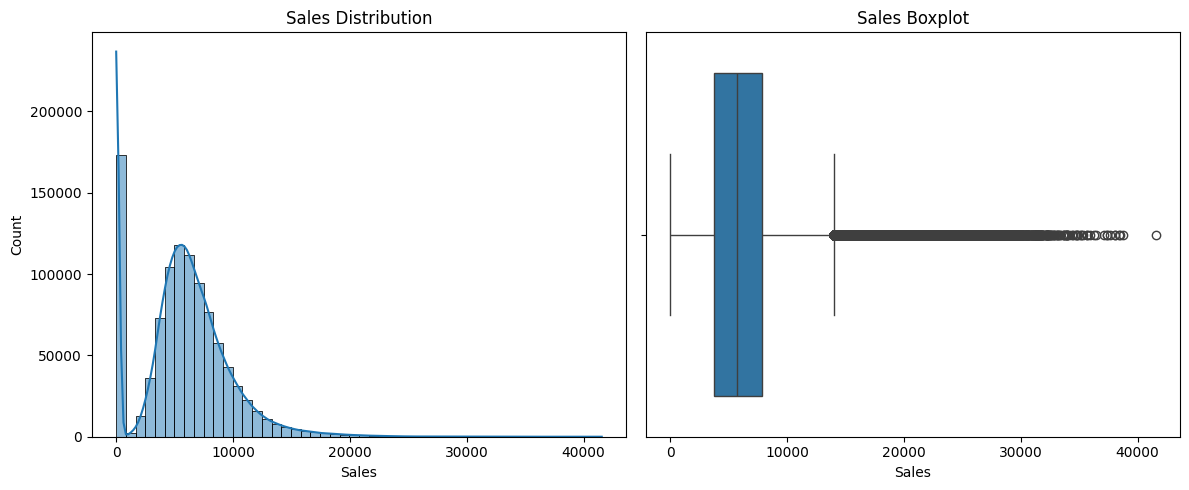

In [21]:
def plot_target_distribution(df, target_col):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[target_col], kde=True, bins=50)
    plt.title(f'{target_col} Distribution')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[target_col])
    plt.title(f'{target_col} Boxplot')
    
    plt.tight_layout()
    plt.show()

plot_target_distribution(train_merged, 'Sales')

Видно много нулевых значение в sales. Скорее всего - связано с тем что магазины в часть дней были преимущественно закрыты \
Также вижно много выбросов в sales. Попробуем изучить их подробнее

In [22]:
def analyze_target_anomalies(df, target_col):
    stats = df[target_col].describe()
    print(f"\nСтатистики {target_col}:")
    print(stats)
    
    Q1, Q3 = df[target_col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    
    outliers = df[(df[target_col] < lower) | (df[target_col] > upper)]
    print(f"\nАномалий по IQR: {len(outliers)} ({100*len(outliers)/len(df):.2f}%)")
    print(f"Диапазон нормы: [{lower:.0f}, {upper:.0f}]")
    
    zeros = (df[target_col] == 0).sum()
    print(f"Нулевых значений: {zeros} ({100*zeros/len(df):.2f}%)")

analyze_target_anomalies(train_merged, 'Sales')


Статистики Sales:
count   1017209.0000
mean       5773.8190
std        3849.9262
min           0.0000
25%        3727.0000
50%        5744.0000
75%        7856.0000
max       41551.0000
Name: Sales, dtype: float64

Аномалий по IQR: 26694 (2.62%)
Диапазон нормы: [-2466, 14050]
Нулевых значений: 172871 (16.99%)


После фильтрации Open==1 & Sales>0 останется правосторонняя асимметрия с длинным хвостом выбросов до 41к.

Boxplot подтверждает много экстремумов справа (праздники, крупные магазины) при нормальной медиане 5700. Думаю, лучше обучать только на открытых магазинах и применить log-трансформацию таргета для стабилизации дисперсии и улучшения работы модели.

,Metric,Anomaly (n=26690),Normal (n=990519),Diff
Feature,,,,
Promo,Mean,0.7187,0.3724,0.3463
Open,Mean,1.0000,0.8255,0.1745
SchoolHoliday,Mean,0.2265,0.1774,0.0491
Customers,Mean,1987.1337,596.6621,1390.4716
CompetitionDistance,Mean,3572.0082,5480.2477,-1908.2394
StoreType,Mode,a,a,True


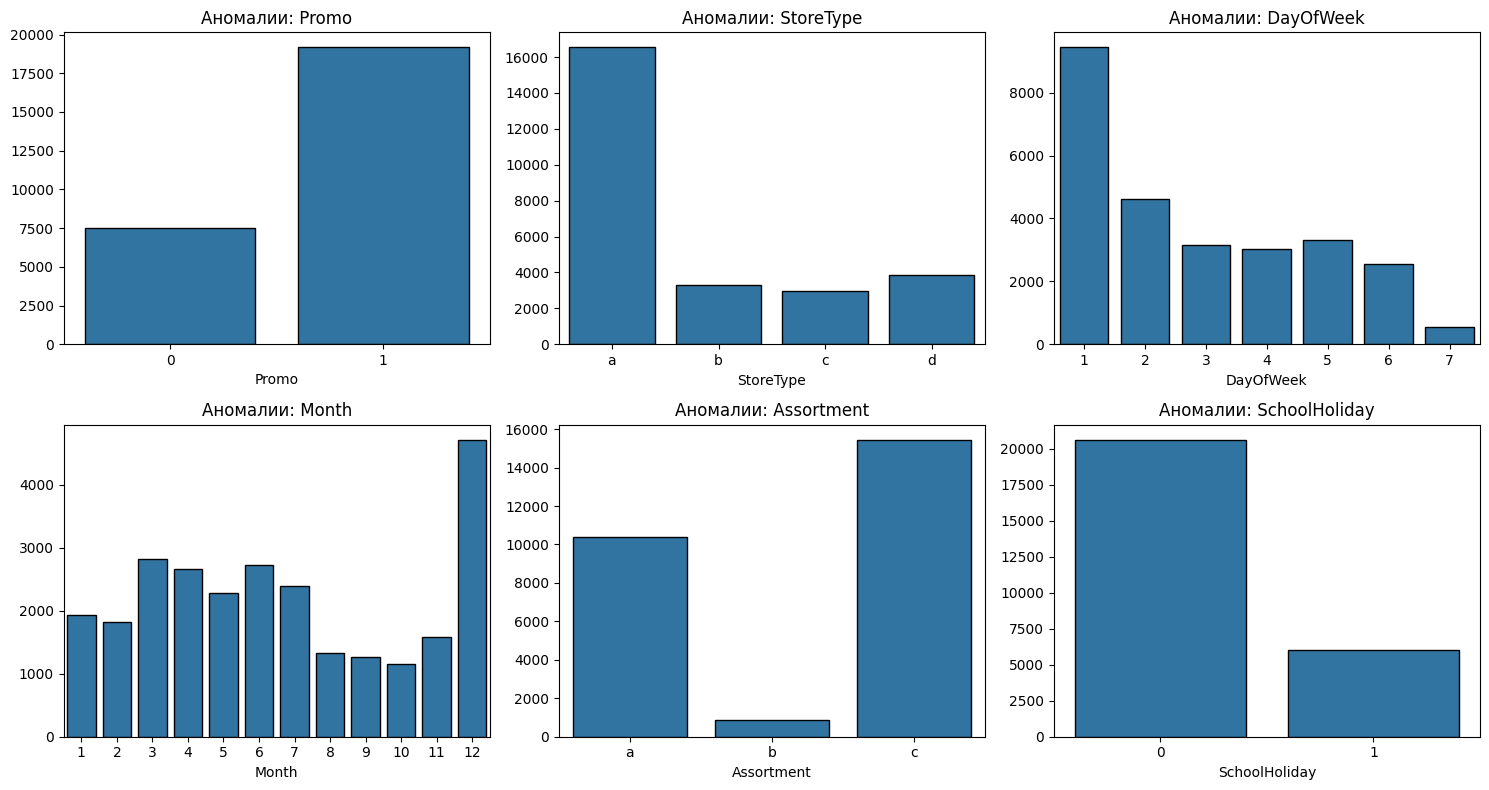

In [23]:
outliers = train_merged[train_merged['Sales'] > 14050]
normal = train_merged[train_merged['Sales'] <= 14050]

def compare_segments(df, mask, mask_name='Anomaly', rest_name='Normal', features=None):
    """
    Сравнивает средние (для чисел) или моду (для категорий) в двух сегментах.
    """
    if features is None:
        features = df.columns
        
    res = []
    
    segment_1 = df[mask]
    segment_2 = df[~mask]
    
    for col in features:
        if pd.api.types.is_numeric_dtype(df[col]):
            val1 = segment_1[col].mean()
            val2 = segment_2[col].mean()
            metric = 'Mean'
        else:
            val1 = segment_1[col].mode()[0]
            val2 = segment_2[col].mode()[0]
            metric = 'Mode'
            
        res.append({
            'Feature': col,
            'Metric': metric,
            f'{mask_name} (n={len(segment_1)})': val1,
            f'{rest_name} (n={len(segment_2)})': val2,
            'Diff': val1 - val2 if metric == 'Mean' else (val1 == val2)
        })
        
    return pd.DataFrame(res).set_index('Feature')

mask_outliers = train_merged['Sales'] > 14050
features_to_check = ['Promo', 'Open', 'SchoolHoliday', 'Customers', 'CompetitionDistance', 'StoreType']
comparison_df = compare_segments(train_merged, mask_outliers, features=features_to_check)
display(comparison_df)

# Визуализация
anom_features = ['Promo', 'StoreType', 'DayOfWeek', 'Month', 'Assortment', 'SchoolHoliday']
plot_grid_bars(outliers, anom_features, title_prefix='Аномалии:')

Аномалии - просто комбо из акций Promo (72% против обычных 37%), понедельников и декабря. Людей в такие дни в 3 раза больше обычного 2000 против 600. Все аномалии только когда магазин открыт, что логично, а ещё там чаще полный ассортимент c вместо базового a.

Promo2 работает наоборот. В аномалиях его меньше (27% против 51%), потому что, видимо, эти долгие акции вешают на слабые магазы. Ещё аномалии чаще когда конкурент ближе (3.5км против 5.5км). SchoolHoliday влияет слабо (23% vs 18%). В общем главное - Promo + понедельник/декабрь + куча людей + широкий ассортимент, вот тебе и выброс в 40к продаж.

### Визуализация статистик

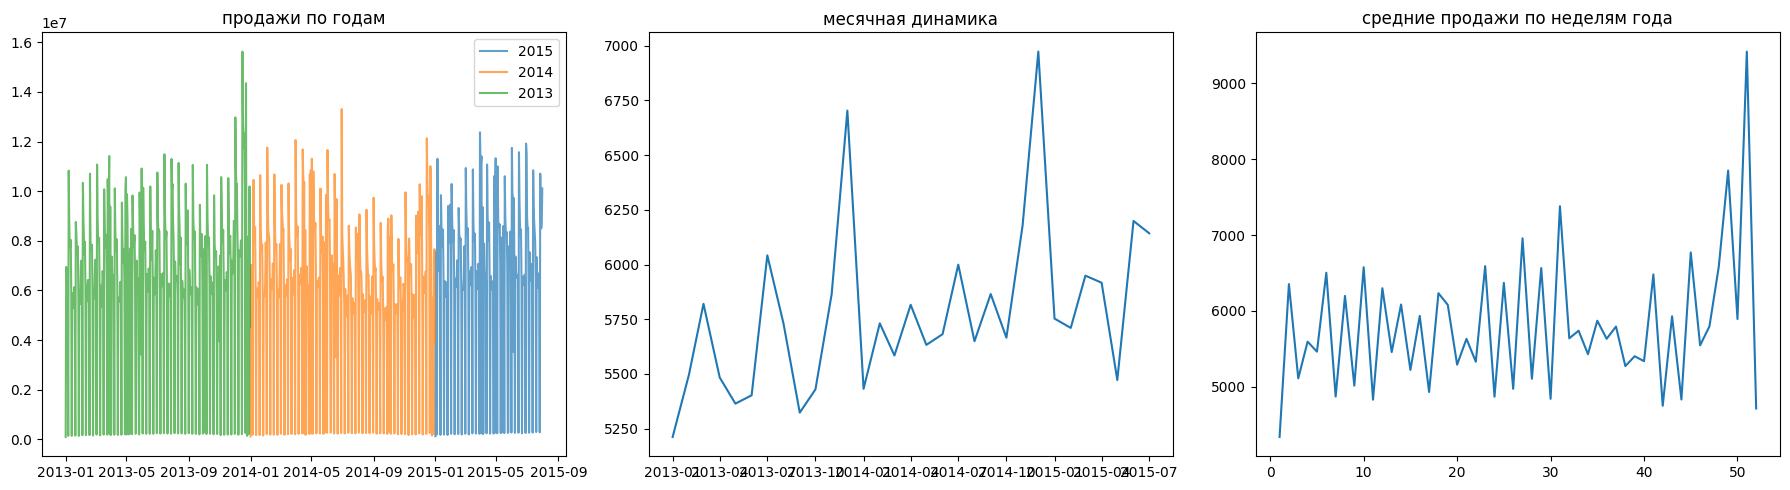

In [24]:
plot_seasonality_analysis(train_merged)

Продажи держатся на плато 6-7М в день без роста, но регулярно же подскакивает до 10. Только два коротковременных провала в январе 2014 и 2015 до 4М после НГ. Декабрь 2013 дает пик примерно 15М, из-за НГ. Тренд слабый.

Сильная циклияность по неделям. Внутри недель амплитуда +-2М каждые 7 дней. Воскресенье всегда провал из-за закрытых магазинов, понедельник всплеск вверх. Паттерн повторяется весь период. Дни недели буду учитывать в моделях, сильный признак.

По годам 2013 и 2014 почти идентичны, 2015 короче но с более высокими пиками. Декабрь взлетает до 15-16М, - в 2-3 раза выше обычного, а в январе обычно спад(ожидаемо). Квартальная сезонность четкая: Q4 лидер, потом Q3, Q2, Q1 худший. Недели 50-52 декабря дают 9500 продаж против базовых 4500-6000, это рождественское безумие.

## Анализ признаков

In [25]:
pd.options.display.float_format = '{:.4f}'.format
train_merged.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear
count,1017209.0000,1017209.0000,1017209,1017209.0000,1017209.0000,1017209.0000,1017209.0000,1017209.0000,1014567.0000,693861.0000,693861.0000,1017209.0000,509178.0000,509178.0000,1017209.0000,1017209.0000,1017209.0000,1017209.0000
mean,558.4297,3.9983,2014-04-11 01:30:42.846061824,5773.8190,633.1459,0.8301,0.3815,0.1786,5430.0857,7.2229,2008.6902,0.5006,23.2691,2011.7528,2013.8323,5.8468,15.7028,23.6155
min,1.0000,1.0000,2013-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,20.0000,1.0000,1900.0000,0.0000,1.0000,2009.0000,2013.0000,1.0000,1.0000,1.0000
25%,280.0000,2.0000,2013-08-17 00:00:00,3727.0000,405.0000,1.0000,0.0000,0.0000,710.0000,4.0000,2006.0000,0.0000,13.0000,2011.0000,2013.0000,3.0000,8.0000,11.0000
50%,558.0000,4.0000,2014-04-02 00:00:00,5744.0000,609.0000,1.0000,0.0000,0.0000,2330.0000,8.0000,2010.0000,1.0000,22.0000,2012.0000,2014.0000,6.0000,16.0000,22.0000
75%,838.0000,6.0000,2014-12-12 00:00:00,7856.0000,837.0000,1.0000,1.0000,0.0000,6890.0000,10.0000,2013.0000,1.0000,37.0000,2013.0000,2014.0000,8.0000,23.0000,35.0000
max,1115.0000,7.0000,2015-07-31 00:00:00,41551.0000,7388.0000,1.0000,1.0000,1.0000,75860.0000,12.0000,2015.0000,1.0000,50.0000,2015.0000,2015.0000,12.0000,31.0000,52.0000
std,321.9087,1.9974,NaN,3849.9262,464.4117,0.3755,0.4858,0.3831,7715.3237,3.2118,5.9926,0.5000,14.0960,1.6629,0.7774,3.3261,8.7876,14.4334


### Описание признаков c kaggle

Sales - выручка за день в евро, целевая переменная для предсказания.

Customers - количество покупателей посетивших магазин в этот день.

Store - уникальный ID магазина от 1 до 1115.

Date - дата записи продаж.

Open - индикатор был ли магазин открыт в этот день, 0 означает закрыт, 1 открыт.

StateHoliday - государственный праздник, где 0 нет праздника, a публичный праздник, b Пасха, c Рождество. В такие дни большинство магазинов закрыто кроме исключений.

SchoolHoliday - индикатор влияния закрытия школ на продажи в этот день.

StoreType - один из 4 типов магазинов, где a базовый малый, b крупный с высоким трафиком, c средний, d мини у дома.

Assortment - уровень ассортимента товаров, где a базовый, b расширенный, c полный.

CompetitionDistance - расстояние в метрах до ближайшего конкурента.

CompetitionOpenSinceMonth и CompetitionOpenSinceYear - примерные месяц и год когда открылся ближайший конкурент.

Promo - индикатор была ли краткосрочная акция в магазине в этот день.

Promo2 - индикатор участия магазина в долгосрочной непрерывной программе акций, где 0 не участвует, 1 участвует.

Promo2SinceWeek и Promo2SinceYear - неделя и год когда магазин начал участвовать в Promo2.

PromoInterval - интервалы когда запускается Promo2, например "Feb,May,Aug,Nov" означает что каждый раунд стартует в феврале, мае, августе, ноябре любого года для этого магазина.

### Типизация признаков (числовые, категориальные, временные) и их распределения

#### Типизация признаков

In [26]:
train_merged.dtypes

Store                                 int64
DayOfWeek                             int32
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Year                                  int32
Month                                 int32
Day                                   int32
WeekOfYear                            int64
dtype: object

Данные состоят из 1.017М записей за период с 2013 по июль 2015 по 1115 магазинам. Всего 22 признака. Из них 4 категориальные (StateHoliday, StoreType, Assortment, PromoInterval), остальные числовые и временные.

Числовые (int64/float64): Sales, Customers, Store, Open, Promo, SchoolHoliday, Promo2, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, Year, Month, Day, WeekOfYear.

Категориальные (object): StateHoliday (0/a/b/c), StoreType (a/b/c/d), Assortment (a/b/c), PromoInterval (строки типа "Feb,May,Aug,Nov").

Временные: Date (datetime64), из которого извлечены Year, Month, Day, WeekOfYear. DayOfWeek формально int32 но дублирует информацию из Date.

#### Распределения

Из describe():

Sales от 0 до 41551, медиана 5744, среднее 5774, std 3850. Много нулей из-за закрытых магазинов, есть правый хвост выбросов до 40к+ в праздники.

Customers от 0 до 7388, медиана 609, среднее 633, std 464. Распределение похоже на Sales, что логично.

CompetitionDistance от 20 до 75860 метров, медиана 2330, среднее 5430, std 7715. Правосторонняя асимметрия, есть магазины с конкурентами очень далеко.

CompetitionOpenSinceMonth от 1 до 12, медиана 8, среднее 7.2. Равномерное распределение по месяцам.

CompetitionOpenSinceYear от 1900 до 2015, медиана 2010, среднее 2009. Год 1900 это явная ошибка в данных.

Promo2SinceWeek от 1 до 50, медиана 22, среднее 23. Покрывает весь год равномерно.

Promo2SinceYear от 2009 до 2015, медиана 2012, среднее 2012. Программа Promo2 запущена в 2009 году.

Open бинарный, 83% это 1 (открыт), 17% это 0 (закрыт).

SchoolHoliday бинарный, 18% это 1 (каникулы), 82% это 0.

Promo бинарный, 38% это 1 (акция), 62% это 0.

Promo2 бинарный, 50% это 1 (участвует), 50% это 0.

StateHoliday категориальный, преобладают нули (обычные дни), праздники a/b/c редкие события.

StoreType категориальный с 4 уровнями a/b/c/d, распределение по типам неравномерное.

Assortment категориальный с 3 уровнями a/b/c, распределение неравномерное.

PromoInterval категориальный, несколько вариантов комбинаций месяцев типа "Jan,Apr,Jul,Oct" или "Feb,May,Aug,Nov".


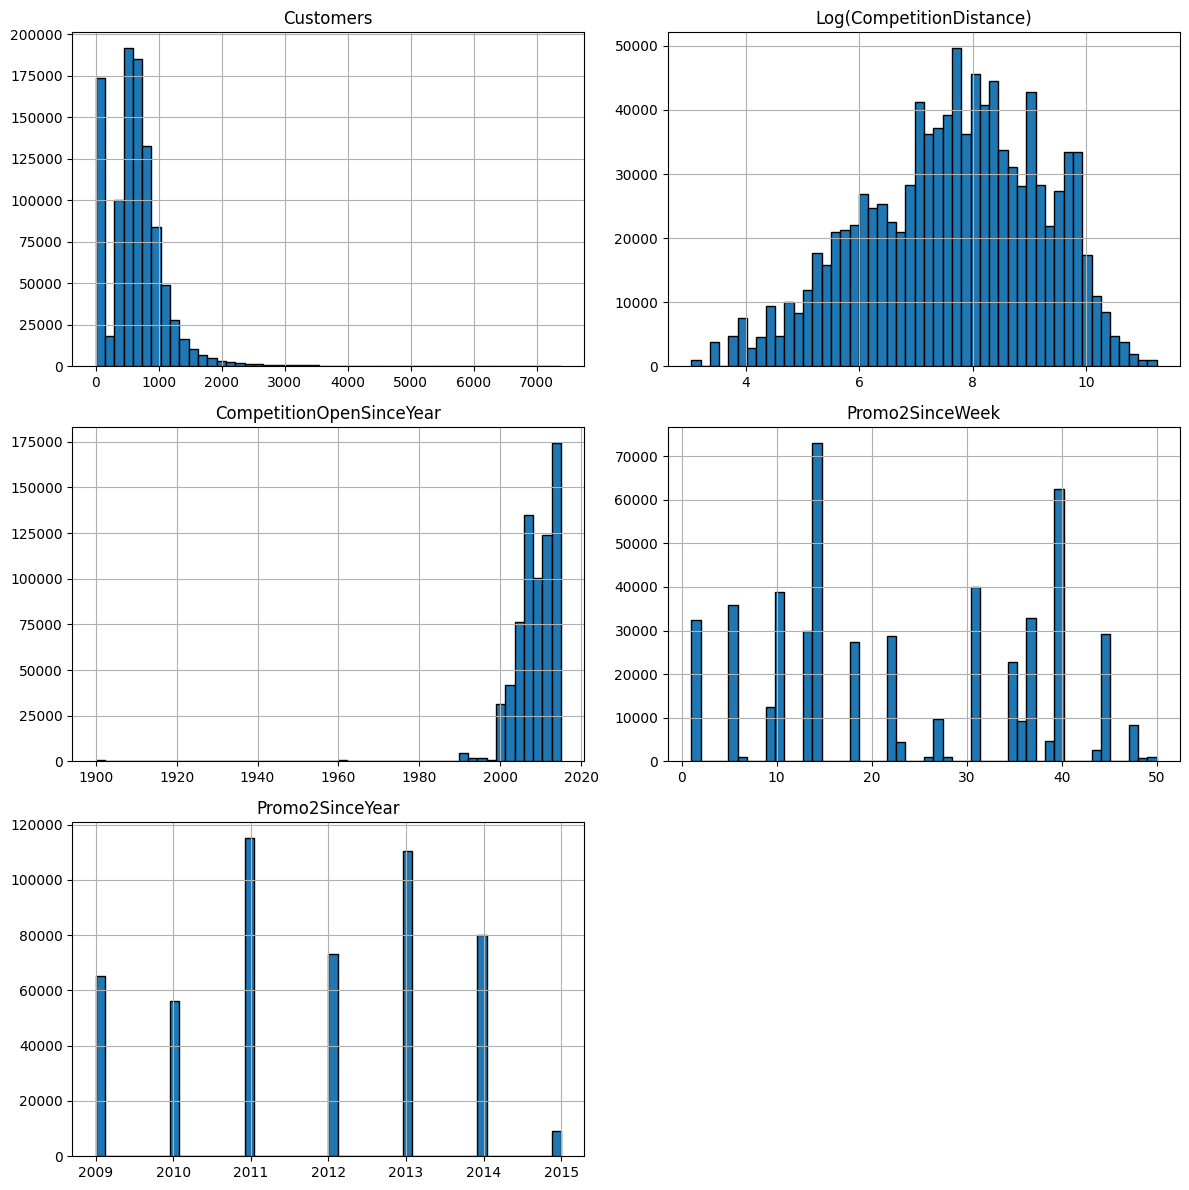

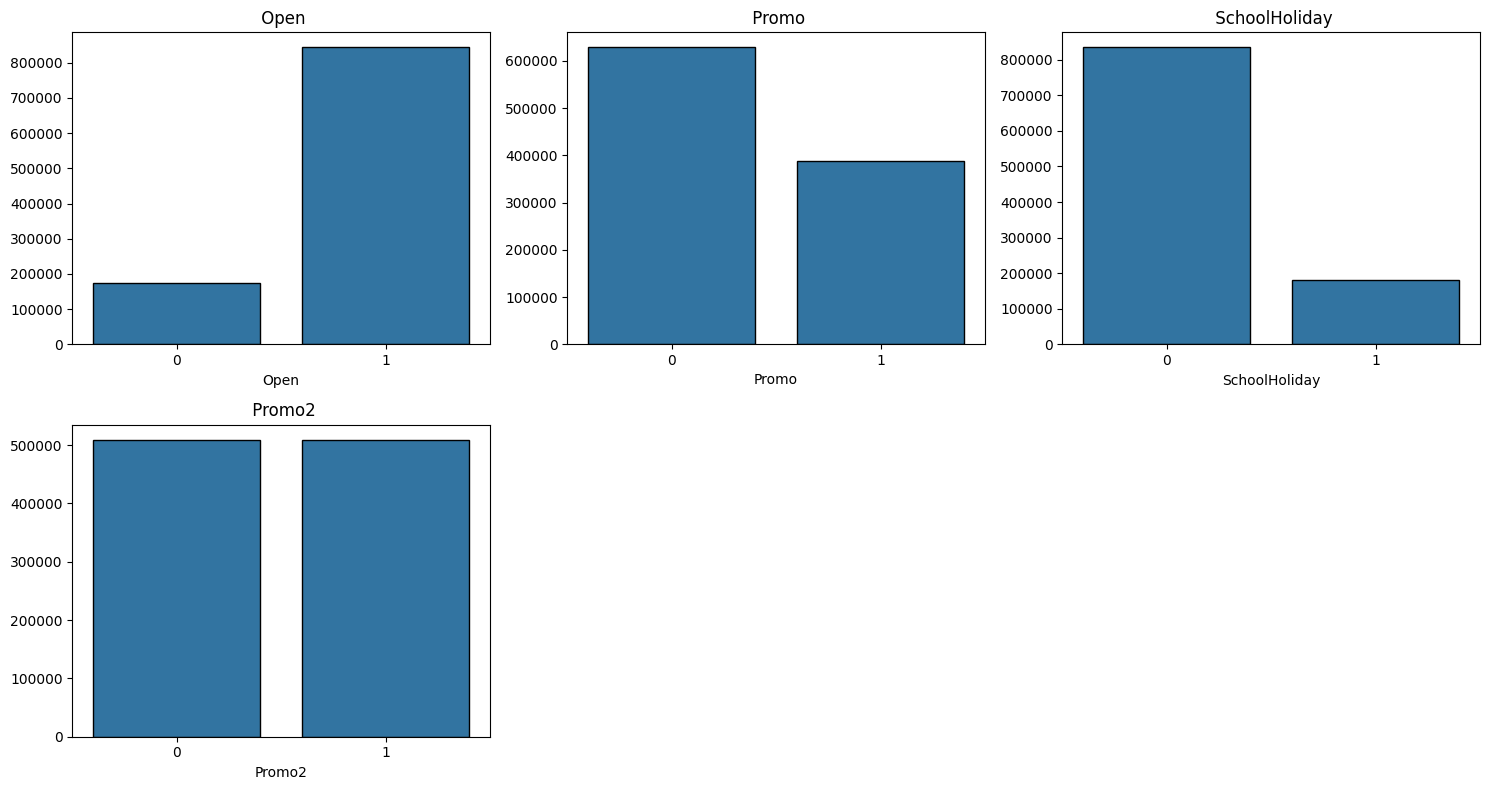

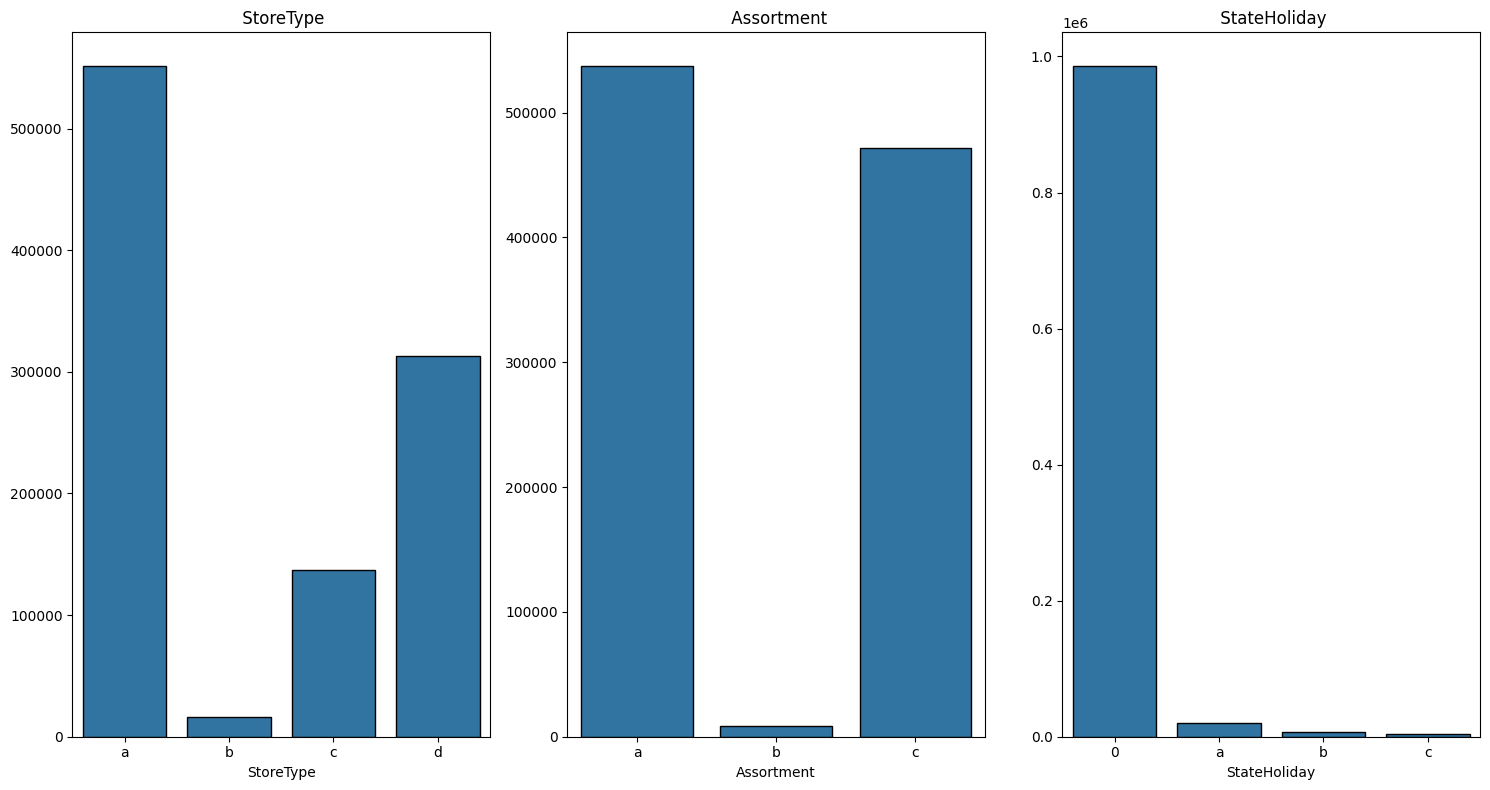

In [27]:
# распределения
num_feats = ['Customers', 'CompetitionDistance', 'CompetitionOpenSinceYear', 
             'Promo2SinceWeek', 'Promo2SinceYear']
plot_grid_histograms(train_merged, num_feats)

# бинарные признаки
binary_features = ['Open', 'Promo', 'SchoolHoliday', 'Promo2']
plot_grid_bars(train_merged, binary_features)

# категориальные признаки
cat_features = ['StoreType', 'Assortment', 'StateHoliday']
plot_grid_bars(train_merged, cat_features)

Sales и Customers похожи по форме. С одинаковой правосторонней асимметрией. Концентрируются слева и с длинным хвостом справа. Customers аналогично: пик у нуля, основная масса 200-1000, хвост до 7000.

CompetitionDistance до 75км, большинство магазинов имеют конкурента в радиусе 5км. После логарифмирования распределение похоже на нормальное. Признак лучше использовать в log-шкале.

CompetitionOpenSinceYear показывает аномалию 1900 года. Видимо ошибка в данных, основная масса открытий конкурентов после 2000 года с пиком в 2010-2015. Promo2SinceWeek равномерный с выбросами на 40 и 14 неделях

Promo2SinceYear концентрируется в 2011-2013. В 2015 таких событий было мало.

Open показывает 83% открытых дней против 17% закрытых, Promo 38% дней с акцией против 62% без, SchoolHoliday 18% дней с каникулами, Promo2 ровно 50/50 разделение магазинов. StoreType сильно перекошен в сторону a (почти 55%), тип b второй по популярности (30%), типы c и d редкие (13% и 2%). Assortment тоже неравномерный: базовый a и расширенный c примерно поровну (по 53% и 45%), а полный b всего в 2% магазинов. StateHoliday почти всегда ноль (тоже логично), праздники a/b/c единичные события. Видимо признак будет довольно слабым так как почти const.

### Выявление и изучение аномальных значений и анализ пропущенных значений

#### Аномалии

In [28]:
# странные комбинации sales/customers при открытом магазине
print("Аномалии в Open=1:")
open_zeros = (train_merged['Open']==1) & (train_merged['Sales']==0) & (train_merged['Customers']==0)
print(f"  Sales=0 и Customers=0: {open_zeros.sum()} записей")
print(f"  Затронуто магазинов: {train_merged[open_zeros]['Store'].nunique()}")

# чек почти ноль при наличии клиентов
sales_per_customer = train_merged[train_merged['Customers']>0]['Sales'] / train_merged[train_merged['Customers']>0]['Customers']
weird_cheap = (train_merged['Customers']>0) & (sales_per_customer<1)
print(f"\nЧек <1 евро при наличии клиентов: {weird_cheap.sum()} записей")
print("Детали:")
print(train_merged[weird_cheap][['Store', 'Date', 'Sales', 'Customers', 'Open', 'Promo']])

print(f"\nВозможные заглушки:")
print(f"  CompetitionOpenSinceYear=1900: {(train_merged['CompetitionOpenSinceYear']==1900).sum()} записей")
print(f"  CompetitionOpenSinceYear <2000: {(train_merged['CompetitionOpenSinceYear']<2000).sum()} записей")
print(f"  CompetitionDistance=20м (минимум): {(train_merged['CompetitionDistance']==20).sum()} записей")

print(f"\nПропуски:")
missing_year = train_merged['CompetitionOpenSinceYear'].isna().sum()
print(f"  CompetitionOpenSinceYear: {missing_year} ({missing_year/len(train_merged)*100:.0f}%)")
has_dist_no_year = ((train_merged['CompetitionDistance'].notna()) & (train_merged['CompetitionOpenSinceYear'].isna())).sum()
print(f"  Есть distance но нет года открытия: {has_dist_no_year}")
print(f"  CompetitionDistance: {train_merged['CompetitionDistance'].isna().sum()}")

print(f"\nВыбросы:")
print(f"  Sales >30k: {(train_merged['Sales']>30000).sum()} записей (max={train_merged['Sales'].max()})")
print(f"  Sales топ 0.1%: >{train_merged['Sales'].quantile(0.999):.0f}")
print(f"  Customers >5k: {(train_merged['Customers']>5000).sum()} записей (max={train_merged['Customers'].max()})")
print(f"  Customers топ 0.1%: >{train_merged['Customers'].quantile(0.999):.0f}")
print(f"  CompetitionDistance >50км: {(train_merged['CompetitionDistance']>50000).sum()} записей (max={train_merged['CompetitionDistance'].max()/1000:.1f}км)")

Аномалии в Open=1:
  Sales=0 и Customers=0: 52 записей
  Затронуто магазинов: 40

Чек <1 евро при наличии клиентов: 2 записей
Детали:
        Store       Date  Sales  Customers  Open  Promo
478649   1100 2014-04-29      0          3     1      1
889932    948 2013-04-25      0          5     1      1

Возможные заглушки:
  CompetitionOpenSinceYear=1900: 758 записей


  CompetitionOpenSinceYear <2000: 18288 записей
  CompetitionDistance=20м (минимум): 942 записей

Пропуски:
  CompetitionOpenSinceYear: 323348 (32%)
  Есть distance но нет года открытия: 320706
  CompetitionDistance: 2642

Выбросы:
  Sales >30k: 153 записей (max=41551)
  Sales топ 0.1%: >23980
  Customers >5k: 19 записей (max=7388)
  Customers топ 0.1%: >3582
  CompetitionDistance >50км: 1884 записей (max=75.9км)


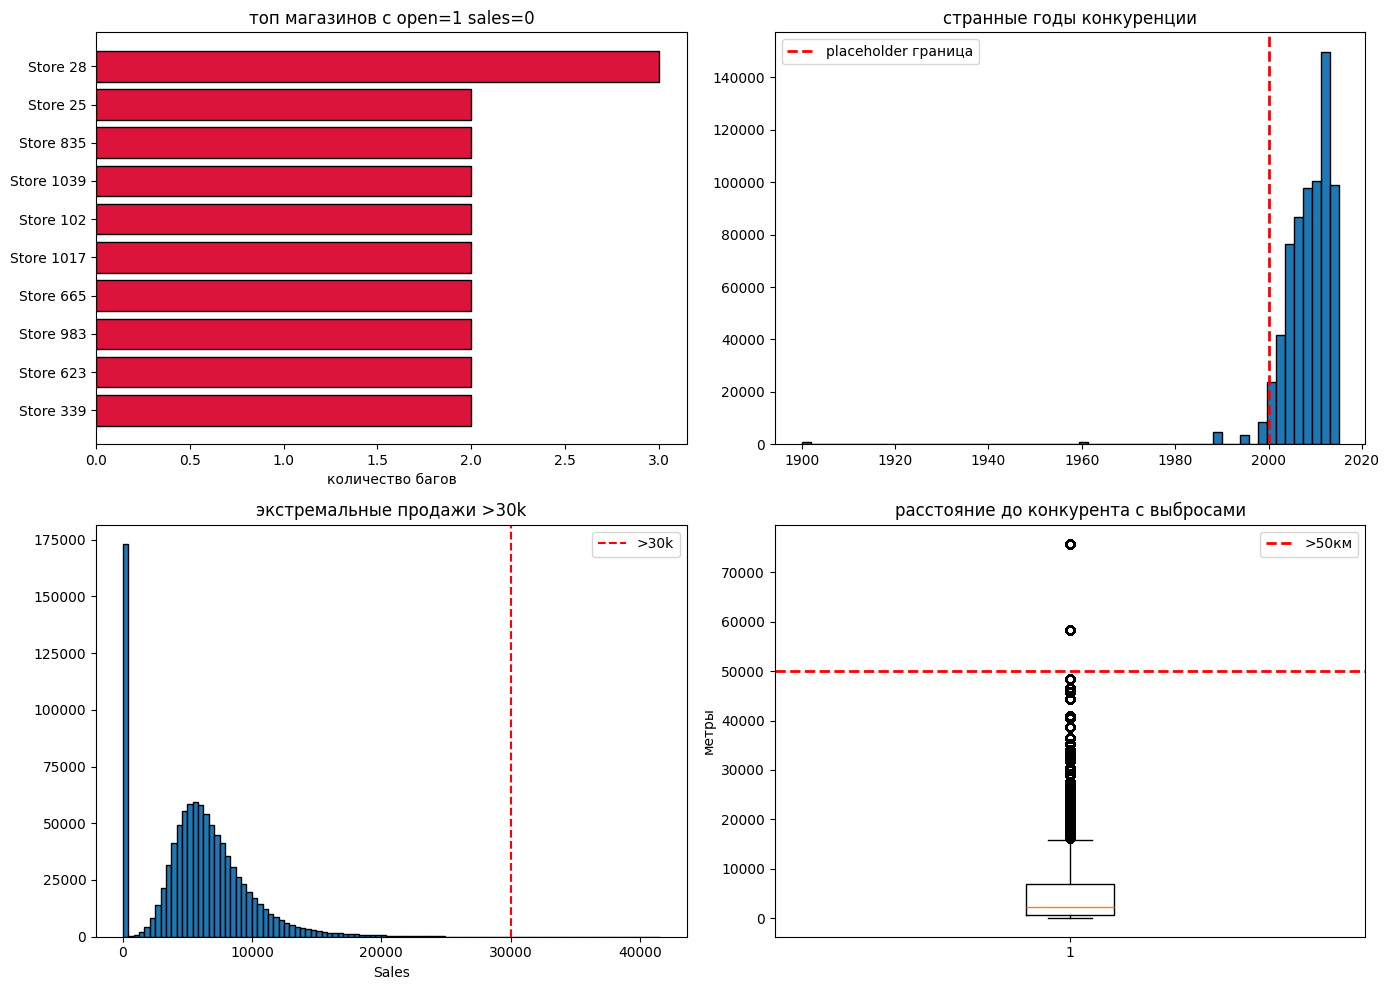

In [29]:
plot_anomaly_dashboard(train_merged)

В итоге:

Есть неправильно заполненные строки (54 штуки): 52 строки когда магазин открыт но продаж и клиентов ноль, плюс 2 записи где клиенты есть а продажи нулевые. Затрагивает 40 магазинов. Таких значений мало. Можно дропныть.

Заглушки (19к записей): Год 1900 и даты до 2000 года для CompetitionOpenSinceYear - заглушки. Еще странные 942 записи с distance=20м тоже похожи на заклушку. Хотя, конкурент в 20 метрах реален в тц. например.

Выбросы (2к+ записей): 153 дня с продажами выше 30k, 19 дней с клиентами больше 5k, 1884 магазина с конкурентом дальше 50км. Не думаю, что это ошибки в данных. Скорее всего, выбросы.

Пропуски (32% данных): Треть записей не знает год открытия конкурента, хотя знает расстояние до него. Самая большая дыра в данных. Думаю, придется создать бинарный признак "есть ли инфа о конкуренте".

#### Пропуски

In [30]:
# все пропуски
print("Пропуски по всем столбцам:")
print(train_merged.isnull().sum()[train_merged.isnull().sum() > 0])

print("\nMedian Sales:")
print(f"С годом конкурента: {train_merged[train_merged['CompetitionOpenSinceYear'].notna()]['Sales'].median():.0f}")
print(f"Без года: {train_merged[train_merged['CompetitionOpenSinceYear'].isna()]['Sales'].median():.0f}")

# уникальные магазины с пропусками
print(f"\nМагазинов без года: {train_merged[train_merged['CompetitionOpenSinceYear'].isna()]['Store'].nunique()}")
print(f"Магазинов без distance: {train_merged[train_merged['CompetitionDistance'].isna()]['Store'].nunique()}")

Пропуски по всем столбцам:
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

Median Sales:
С годом конкурента: 5743
Без года: 5746

Магазинов без года: 354
Магазинов без distance: 3


In [31]:
def check_timeseries_correctness(df, name='dataset'):    
    print(f"{name}:\n")
    
    # диапазон дат
    date_range = pd.date_range(df['Date'].min(), df['Date'].max(), freq='D')
    all_stores = df['Store'].unique()
    
    print(f"Период: {df['Date'].min().date()} - {df['Date'].max().date()}")
    print(f"Дней: {len(date_range)}")
    print(f"Магазинов: {len(all_stores)}")
    
    expected = len(date_range) * len(all_stores)
    actual = len(df)
    print(f"\nОжидаемо записей: {expected}")
    print(f"Фактически: {actual}")
    print(f"Покрытие: {actual/expected*100:.1f}%")
    
    # проверка по магазинам
    records_per_store = df.groupby('Store').size()
    incomplete_stores = records_per_store[records_per_store < len(date_range)]
    print(f"\nМагазинов с пропусками дат: {len(incomplete_stores)}")
    if len(incomplete_stores) > 0:
        print("Примеры худших:")
        print(incomplete_stores.sort_values().head())
    
    records_per_date = df.groupby('Date').size()
    incomplete_dates = records_per_date[records_per_date < len(all_stores)]
    print(f"\nДат с пропусками магазинов: {len(incomplete_dates)}")
    if len(incomplete_dates) > 0:
        print("Примеры:")
        print(incomplete_dates.head())
    
    # дубликаты
    duplicates = df[df.duplicated(subset=['Store', 'Date'], keep=False)]
    print(f"\nДубликаты Store+Date: {len(duplicates)}")
    
    # хронологический порядок
    is_sorted = df['Date'].is_monotonic_increasing
    print(f"Отсортировано по дате: {is_sorted}")
    
    all_dates = set(date_range)
    actual_dates = set(df['Date'].unique())
    missing_dates = all_dates - actual_dates
    print(f"\nПолностью отсутствующих дат: {len(missing_dates)}")
    if len(missing_dates) > 0 and len(missing_dates) < 10:
        print(f"Даты: {sorted(missing_dates)}")
    
    print()
    return {
        'stores': all_stores,
        'date_range': date_range,
        'dates': actual_dates,
        'coverage': actual/expected
    }

train_info = check_timeseries_correctness(train_merged, 'train')
test_info = check_timeseries_correctness(test_merged, 'test')

print("train vs test:\n")

train_stores = set(train_info['stores'])
test_stores = set(test_info['stores'])

print(f"Магазинов train: {len(train_stores)}, test: {len(test_stores)}")
print(f"Пересечение: {len(train_stores & test_stores)}")
print(f"Только в train: {len(train_stores - test_stores)}")
print(f"Только в test: {len(test_stores - train_stores)}")

if len(test_stores - train_stores) > 0:
    print(f"Новые магазины в test: {sorted(test_stores - train_stores)[:10]}")

print(f"\nПоследняя train: {max(train_info['dates']).date()}")
print(f"Первая test: {min(test_info['dates']).date()}")
print(f"Последняя test: {max(test_info['dates']).date()}")

overlap = train_info['dates'] & test_info['dates']
print(f"Пересечение дат: {len(overlap)}")

train:

Период: 2013-01-01 - 2015-07-31
Дней: 942
Магазинов: 1115

Ожидаемо записей: 1050330
Фактически: 1017209
Покрытие: 96.8%

Магазинов с пропусками дат: 181
Примеры худших:
Store
13     758
694    758
701    758
702    758
706    758
dtype: int64

Дат с пропусками магазинов: 185
Примеры:
Date
2013-01-01    1114
2014-07-01     935
2014-07-02     935
2014-07-03     935
2014-07-04     935
dtype: int64

Дубликаты Store+Date: 0
Отсортировано по дате: False

Полностью отсутствующих дат: 0

test:

Период: 2015-08-01 - 2015-09-17
Дней: 48
Магазинов: 856

Ожидаемо записей: 41088
Фактически: 41088
Покрытие: 100.0%

Магазинов с пропусками дат: 0

Дат с пропусками магазинов: 0

Дубликаты Store+Date: 0
Отсортировано по дате: False

Полностью отсутствующих дат: 0

train vs test:

Магазинов train: 1115, test: 856
Пересечение: 856
Только в train: 259
Только в test: 0

Последняя train: 2015-07-31
Первая test: 2015-08-01
Последняя test: 2015-09-17
Пересечение дат: 0


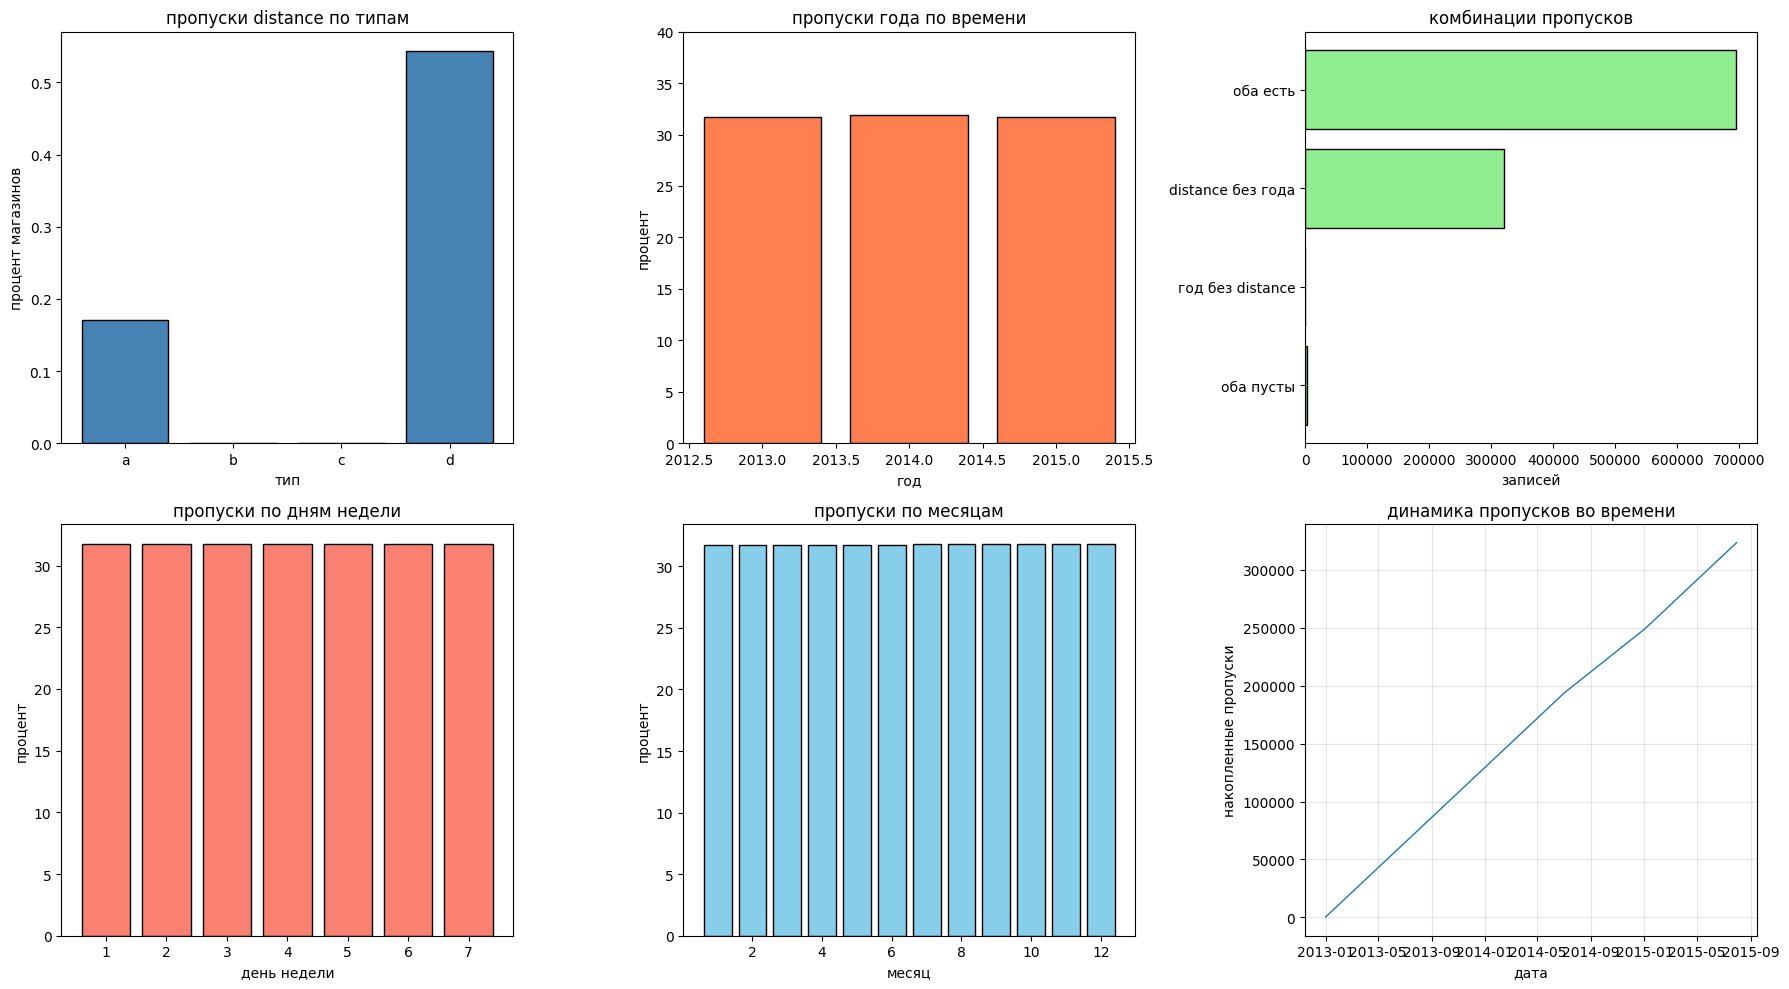

In [32]:
plot_missing_dashboard(train_merged)

CompetitionOpenSinceYear отсутствует у 354 магазинов (32% данных). Из них 3 не знают вообще ничего про конкурентов, остальные 351 знают distance но не знают когда конкурент открылся. Пропуски равномерно распределены по времени, дням недели и месяцам. Получается, это специфика датасете.

Promo2SinceWeek/Year и PromoInterval пропущены у 508к записей (50%). Половина не участвует. Для них Promo2=0 и все три поля логично пустые.

Целостность временного ряда:

Train покрывает 96.8% ожидаемых записей (33к пропусков). 181 магазин имеют неполные даты, причем у некоторых отсутствует по 758 дней из 942. Еще 185 дат имеют неполный набор магазинов.

В теста 100% покрытие, все 856 магазинов присутствуют во всех 48 днях. Все тестовые магазины есть в train. Даты не пересекаются с train (последний день train 31 июля, первый test 1 августа).

Данные не отсортированы по дате.

### Анализ зависимостей между признаками и анализ корреляций

In [33]:
def plot_target_vs_features(df, target, features, plot_type='box', figsize=(18, 5)):
    n_cols = len(features)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize)
    
    if n_cols == 1: axes = [axes]
    
    for ax, col in zip(axes, features):
        if plot_type == 'box':
            sns.boxplot(x=col, y=target, data=df, ax=ax)
        elif plot_type == 'bar':
            sns.barplot(x=col, y=target, data=df, ax=ax)
            
        ax.set_title(f'{target} vs {col}')
        
    plt.tight_layout()
    plt.show()

Columns for pairplot: ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year']


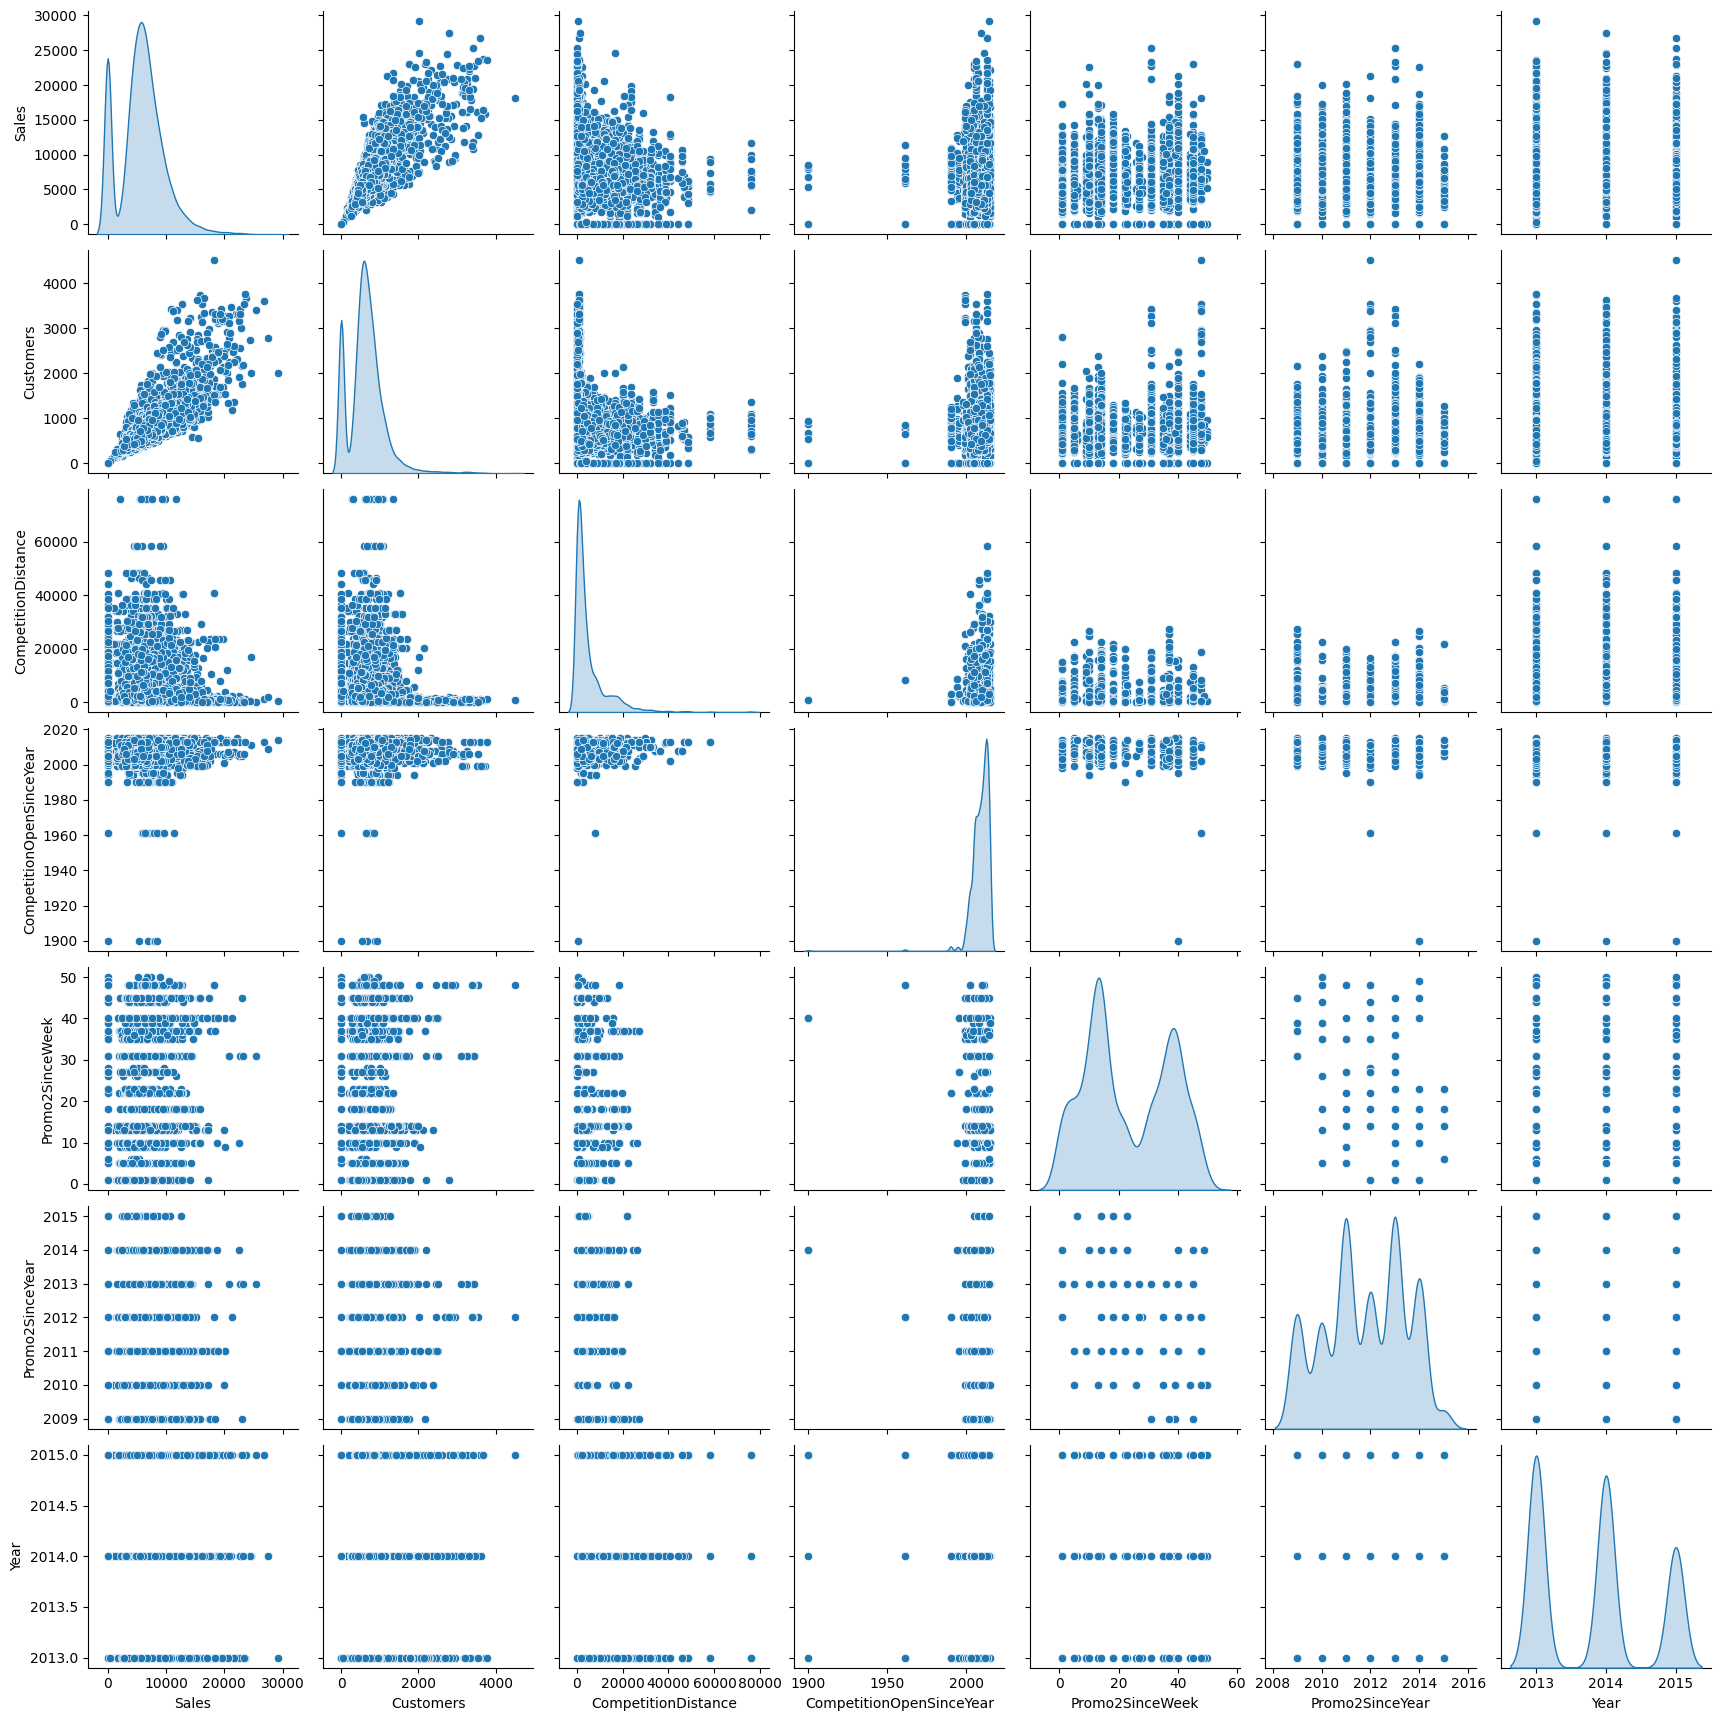

In [34]:
# Remove unnecessary features like 'Id'
cols_to_exclude = ['Id', 'Store', 'Date', 'SchoolHoliday', 'IsStateHoliday', 'Month', 'DayOfWeek', 'Open', 'Promo', 'Day', 
                   'WeekOfYear', 'CompetitionOpenSinceMonth', 'Promo2']


numeric_cols = train_merged.select_dtypes(include=[np.number]).columns.tolist()
pairplot_cols = [c for c in numeric_cols if c not in cols_to_exclude]

if 'Id' in pairplot_cols:
    pairplot_cols.remove('Id')

print("Columns for pairplot:", pairplot_cols)

sample_df = train_merged[pairplot_cols].sample(min(10000, len(train_merged)), random_state=RANDOM_STATE)

sns.pairplot(sample_df, diag_kind='kde')
plt.show()

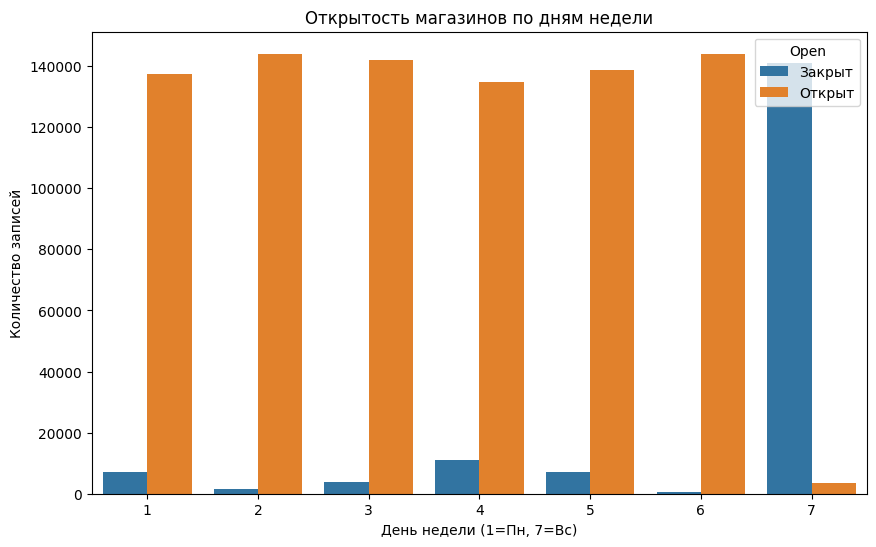

In [35]:
plt.figure(figsize=(10, 6))
open_by_dow = train_merged.groupby(['DayOfWeek', 'Open']).size().reset_index(name='Count')
open_by_dow['Open'] = open_by_dow['Open'].map({0: 'Закрыт', 1: 'Открыт'})

sns.barplot(x='DayOfWeek', y='Count', hue='Open', data=open_by_dow)
plt.title('Открытость магазинов по дням недели')
plt.xlabel('День недели (1=Пн, 7=Вс)')
plt.ylabel('Количество записей')
plt.show()

Чаще всего в воскресенье магазины закрыты

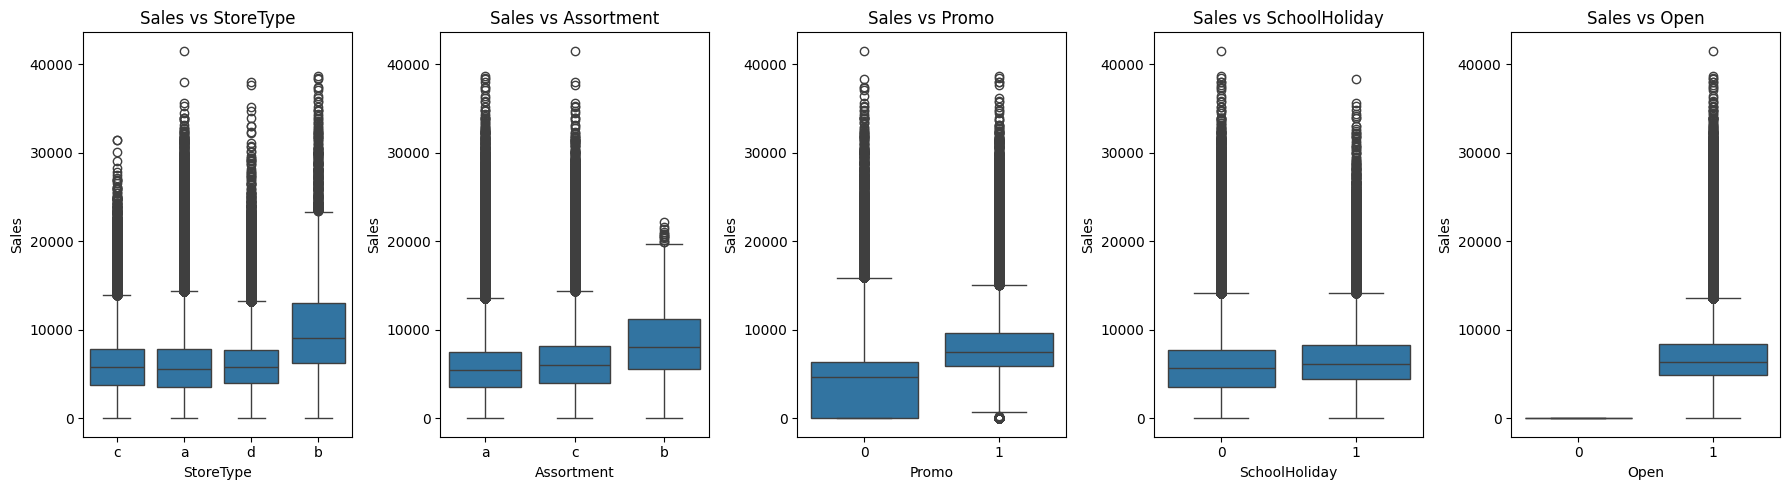

In [36]:
# Анализ влияния категорий на Продажи
cols_to_plot = ['StoreType', 'Assortment', 'Promo', 'SchoolHoliday', 'Open']
plot_target_vs_features(train_merged, 'Sales', cols_to_plot, plot_type='box')

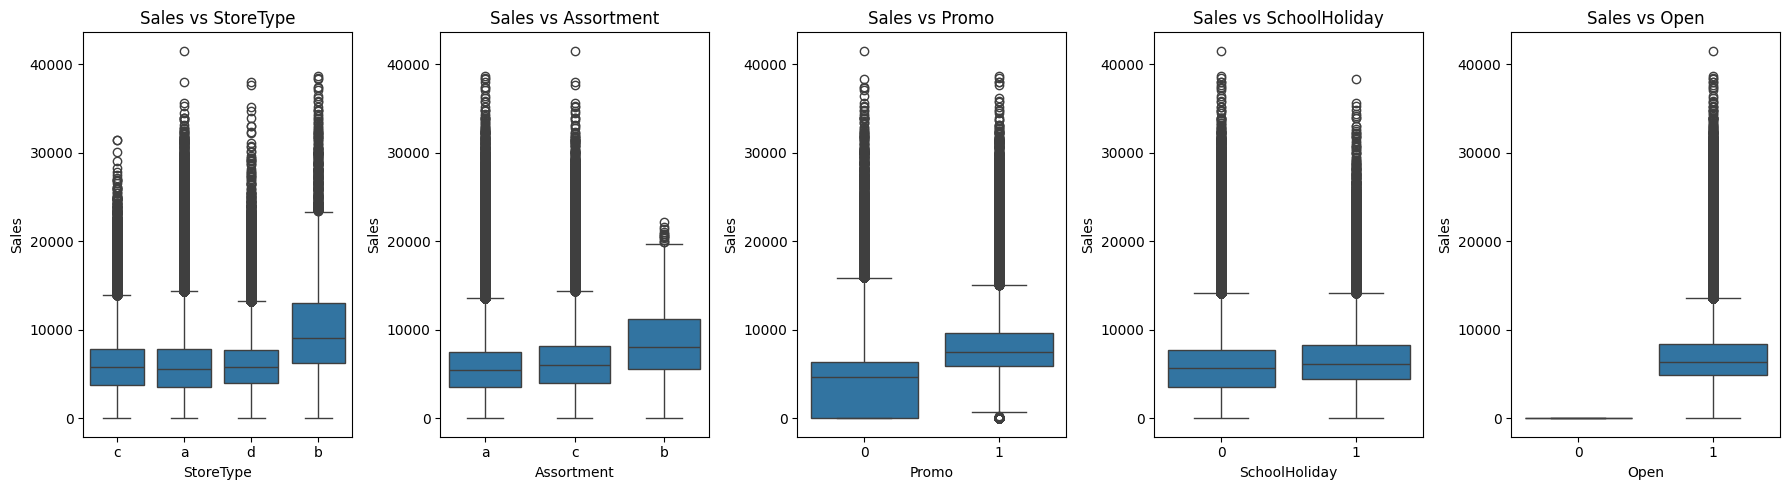

In [37]:
# Анализ влияния категорий на Продажи
cols_to_plot = ['StoreType', 'Assortment', 'Promo', 'SchoolHoliday', 'Open']
plot_target_vs_features(train_merged, 'Sales', cols_to_plot, plot_type='box')

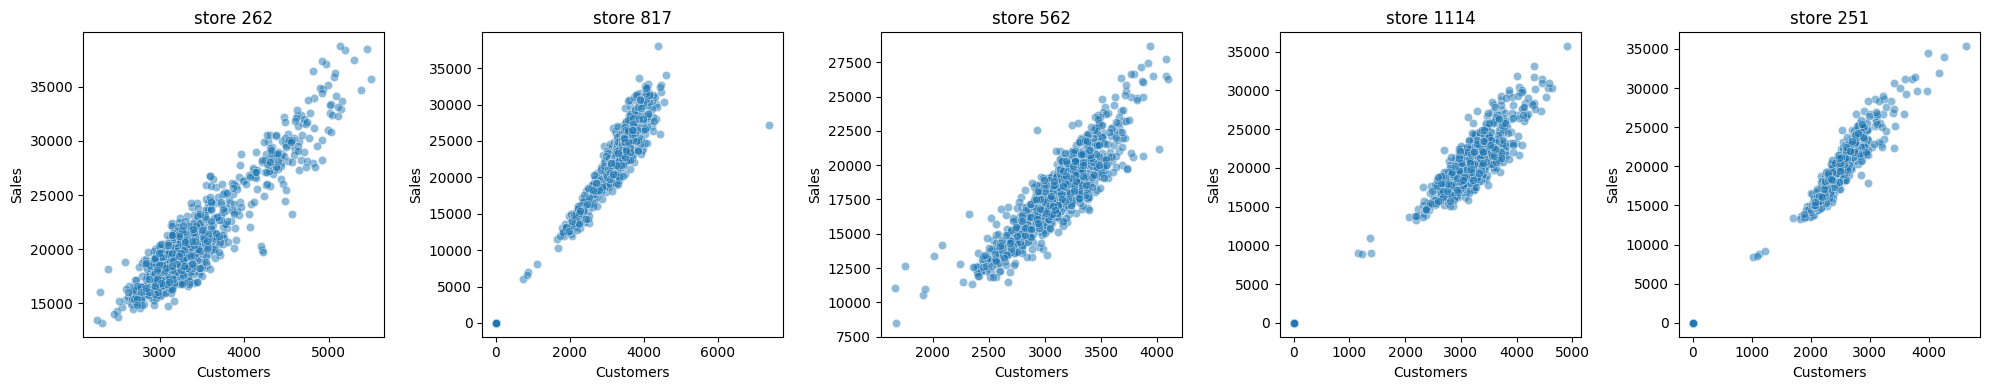

In [38]:
# Глянем на топ магазинов по продажам и их зависимость от кол-во клиентов
top5_stores = train_merged.groupby('Store')['Sales'].sum().nlargest(5).index
plot_store_scatters(train_merged, top5_stores)

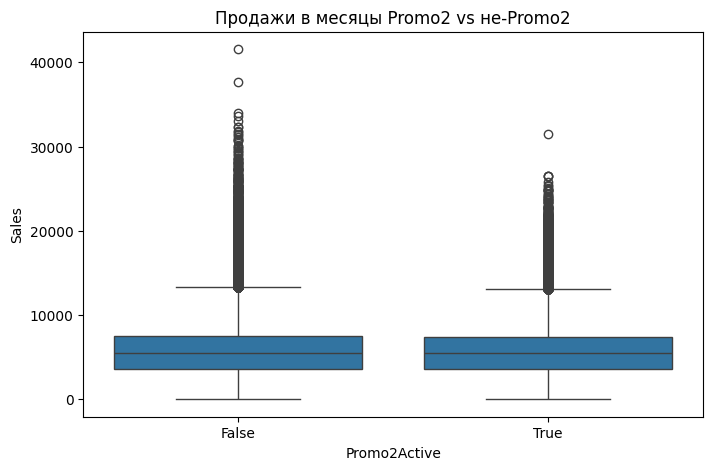

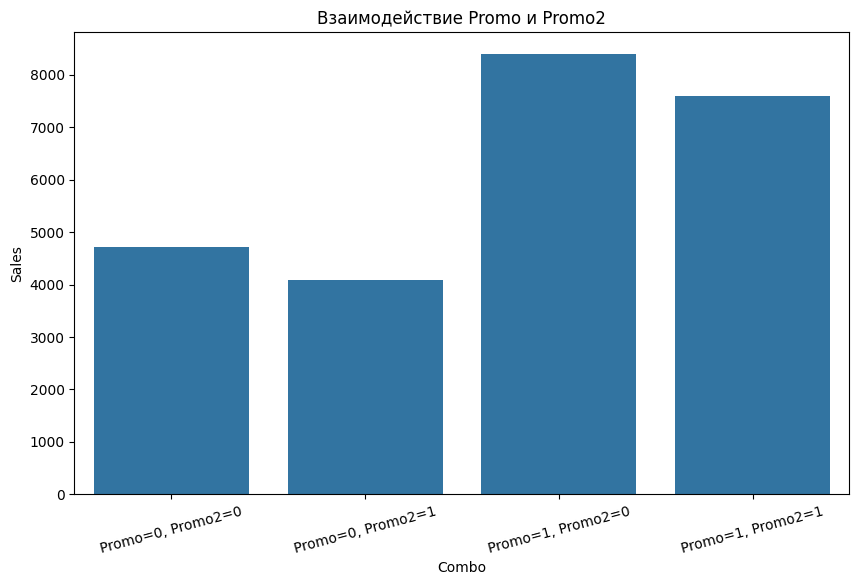

In [39]:
# создаем фичу активности Promo2
month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
             'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}

train_merged['Promo2Active'] = train_merged.apply(
    lambda x: (x['Promo2'] == 1 and 
               pd.notna(x['PromoInterval']) and
               x['Month'] in [month_map[m] for m in x['PromoInterval'].split(',')]),
    axis=1
)

plt.figure(figsize=(8, 5))
sns.boxplot(x='Promo2Active', y='Sales', data=train_merged[train_merged['Promo2']==1])
plt.title('Продажи в месяцы Promo2 vs не-Promo2')
plt.show()

# взаимодействие Promo и Promo2
plt.figure(figsize=(10, 6))
interaction = train_merged.groupby(['Promo', 'Promo2'])['Sales'].mean().reset_index()
interaction['Combo'] = interaction.apply(
    lambda x: f"Promo={int(x['Promo'])}, Promo2={int(x['Promo2'])}", axis=1
)
sns.barplot(x='Combo', y='Sales', data=interaction)
plt.title('Взаимодействие Promo и Promo2')
plt.xticks(rotation=15)
plt.show()

Promo2 коррелирует с низкими продажами \
Предположения:

    1. Не Promo2 снижает продажи, а низкие продажи становятся причиной подключения Promo2
    Promo2 подключают в слабых магазинах для поддержки продаж

    2. Постоянные акции обесцениваются
    Клиенты ждут скидок и не покупают по полной цене

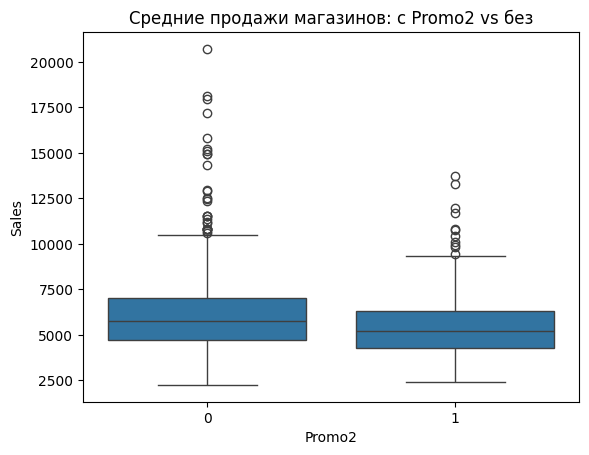

In [40]:
# Сравним характеристики магазинов с/без Promo2
store_stats = train_merged.groupby('Store').agg({
    'Sales': 'mean',
    'Promo2': 'first'
}).reset_index()

sns.boxplot(x='Promo2', y='Sales', data=store_stats)
plt.title('Средние продажи магазинов: с Promo2 vs без')
plt.show()

Проверили магазины с/без Promo2 на предмет продаж
Магазины с Promo2 изначально слабее

    Медиана продаж: Promo2=0 > Promo2=1
    Больше выбросов вверх у магазинов без Promo2
    Распределение у Promo2=1 смещено вниз

Вывод:
Promo2 - не причина, а следствие! Компания подключает долгосрочные акции к проблемным магазинам.

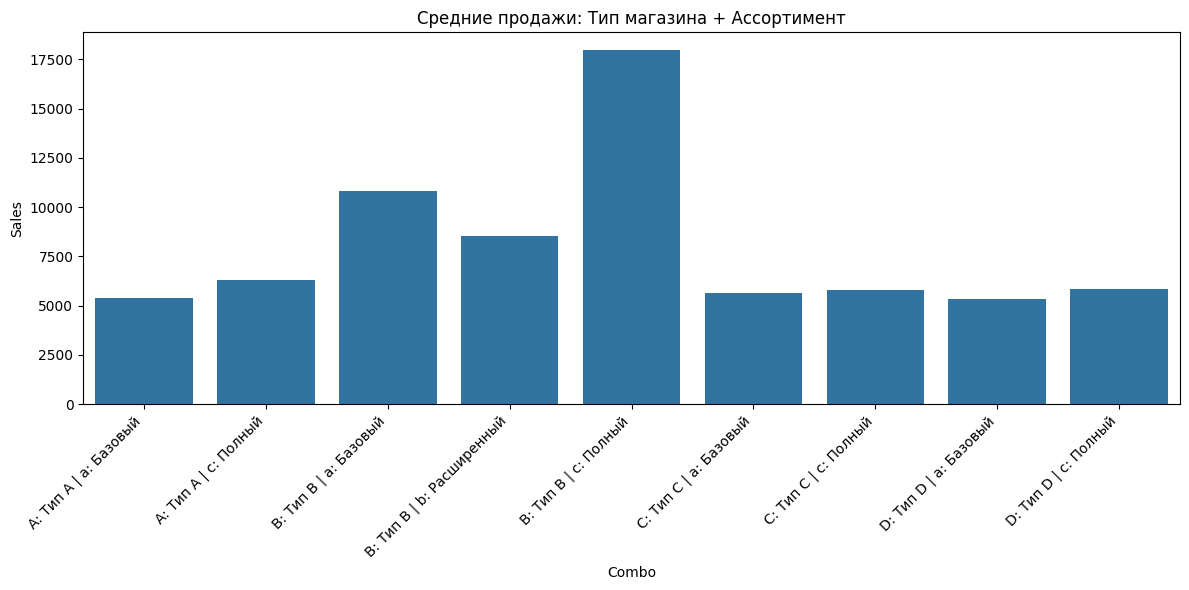

In [41]:
plt.figure(figsize=(12, 6))
combo_sales = train_merged.groupby(['StoreType', 'Assortment'])['Sales'].mean().reset_index()

store_names = {'a': 'A: Тип A', 'b': 'B: Тип B', 'c': 'C: Тип C', 'd': 'D: Тип D'}
assort_names = {'a': 'a: Базовый', 'b': 'b: Расширенный', 'c': 'c: Полный'}

combo_sales['Combo'] = (combo_sales['StoreType'].map(store_names) + ' | ' + 
                        combo_sales['Assortment'].map(assort_names))

sns.barplot(x='Combo', y='Sales', data=combo_sales)
plt.title('Средние продажи: Тип магазина + Ассортимент')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Анализ сезонности
Посмотрим, как продажи зависят от дня недели и месяца

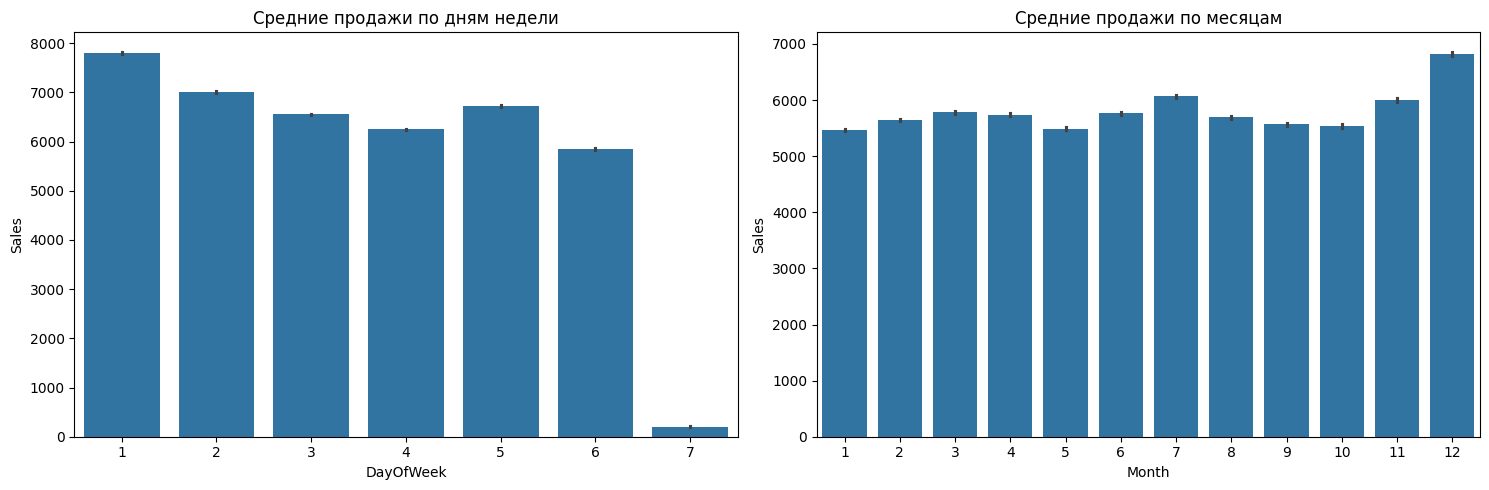

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Средние продажи по дням недели
sns.barplot(x='DayOfWeek', y='Sales', data=train_merged, ax=axes[0])
axes[0].set_title('Средние продажи по дням недели')

# Средние продажи по месяцам
sns.barplot(x='Month', y='Sales', data=train_merged, ax=axes[1])
axes[1].set_title('Средние продажи по месяцам')

plt.tight_layout()
plt.show()

Меньше всего покупают в воскресенье(так как большинство магазинов закрыты), а больше всего в понедельник и пятницу \
Топ месяцев: июль, ноябрь, декабрь \
Продажи явно сезонны по кварталам

#### Корреляционный анализ
Построим тепловую карту корреляций для числовых признаков.

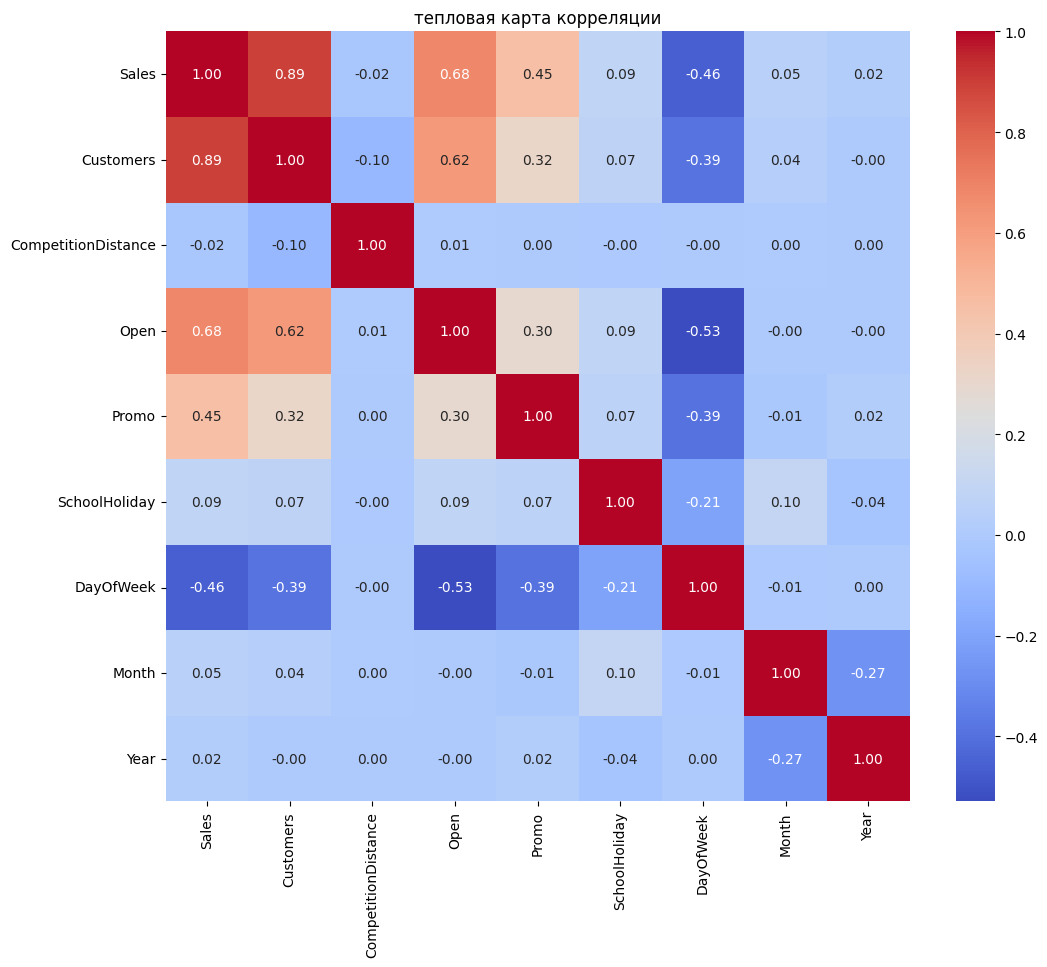

In [43]:
numeric_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Open', 
                'Promo', 'SchoolHoliday', 'DayOfWeek', 'Month', 'Year']
plot_correlation_heatmap(train_merged, numeric_cols)

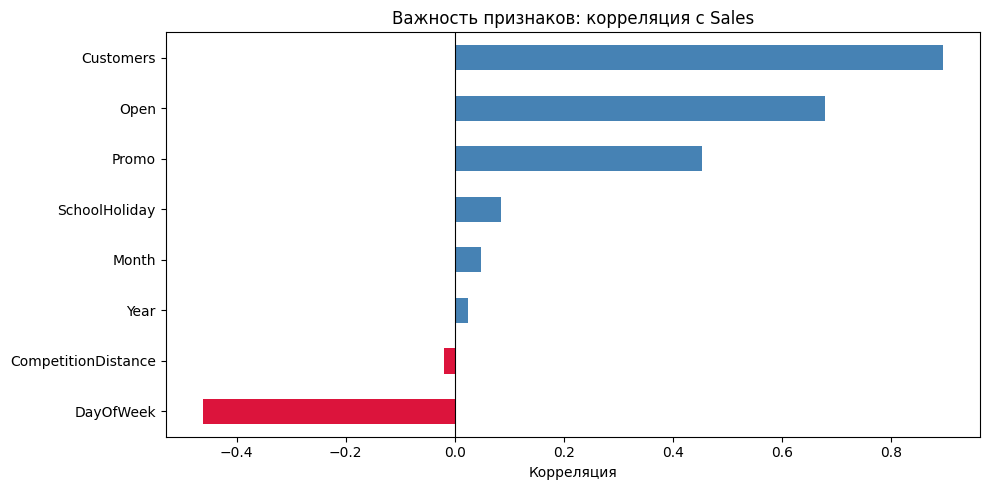

In [58]:
# важность признаков: корреляция с Sales
feature_importance = train_merged[numeric_cols].corr()['Sales'].drop('Sales').sort_values()

plt.figure(figsize=(10, 5))
feature_importance.plot(kind='barh', color=['crimson' if x < 0 else 'steelblue' for x in feature_importance])
plt.title('Важность признаков: корреляция с Sales')
plt.xlabel('Корреляция')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

Продажи сильно коррелируют с количеством покупателей \
Промо бустит продажи \
Отрицательная корреляция дня недели почти со всеми фичами объясняется очень низкими продажами в воскресенье(из-за того что магазы закрыты) 

#### Анализ конкуренции и клиентов
Изучим взаимосвязь продаж с количеством клиентов и расстоянием до конкурентов.

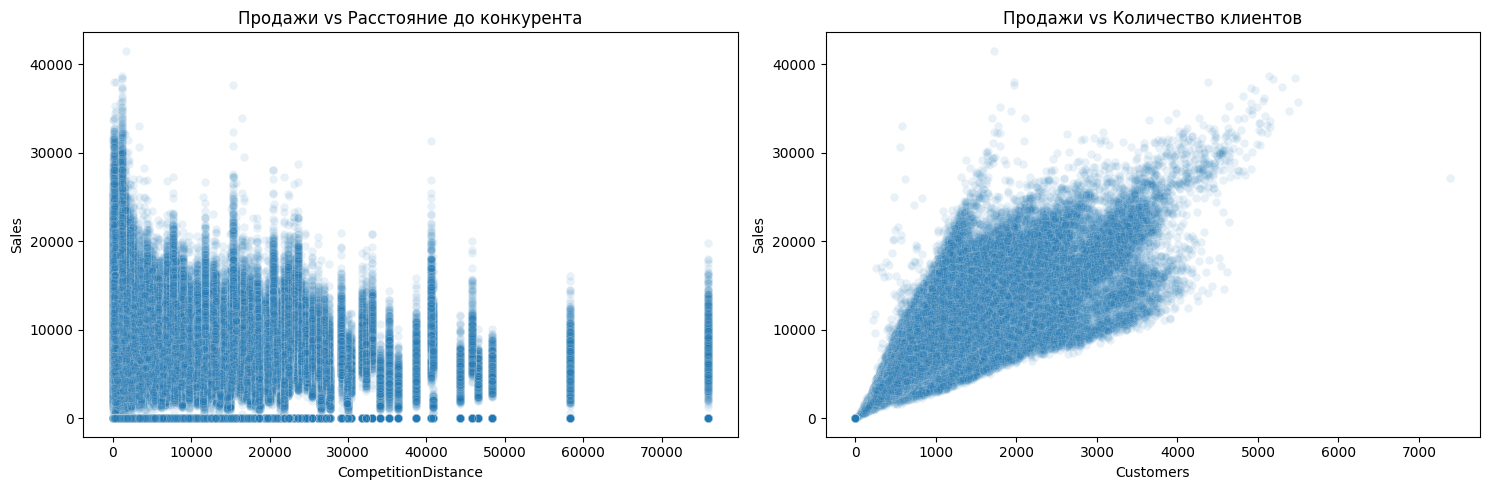

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# продажи vs расстояния до конкурента
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train_merged, alpha=0.1, ax=axes[0])
axes[0].set_title('Продажи vs Расстояние до конкурента')

# продажи vs количества клиентов
sns.scatterplot(x='Customers', y='Sales', data=train_merged, alpha=0.1, ax=axes[1])
axes[1].set_title('Продажи vs Количество клиентов')

plt.tight_layout()
plt.show()

Customers главный драйвер продаж

Корреляция 0.89, на scatter почти линейная зависимость. Где больше трафика там больше выручка, все просто. Customers объясняет большую часть вариации в Sales.

День недели сильнейший фактор

Пик продаж в понедельник и вторник, провал в среду-четверг, пятница средняя, суббота падает, воскресенье почти ноль (магазины закрыты). Недельный паттерн жесткий и неравномерный - при сплите на валидацию резать надо по целым неделям, иначе распределение поедет.

Месяцы показывают сезонность

Декабрь огромный лидер (новогодний спрос), январь слабый, июль тоже сильный. Видна квартальная динамика.

Promo работает, Promo2 нет

Promo дает четкий рост median sales и customers, много выбросов вверх в дни акций. Promo2 почти не влияет - медианы одинаковые с нулем, иногда даже ниже. Promo это короткие всплески продаж, Promo2 долгосрочные акции для слабых магазинов где эффект размазан.

StoreType b встречается чаще всего

Тип b (крупные магазины) лидер по продажам и трафику. Лучшая комбинация StoreType b + Assortment c (полный ассортимент в большом магазине). Ассортимент c работает только в крупных точках, в маленьких разницы между a и c нет.

Open критичен

Закрытый магазин это почти всегда ноль продаж. Open сильно коррелирует с днем недели (воскресенья закрыты).

SchoolHoliday не влияет

Медианы одинаковые, корреляции нет, эффект нулевой или очень слабый.

CompetitionDistance не работает линейно

Корреляция близка к нулю, тренд не виден. Влияние конкуренции либо нелинейное либо зашумленное другими факторами.

### Анализ возможных преобразований и генерация новых признаков

корреляции с Sales:
StoreDowMean     0.8388
Sales_lag7       0.5297
SalesRatio       0.5129
SalesChange      0.4850
AvgBasket        0.1870
CompIntensity    0.0945
PromoCombo       0.0739
Quarter          0.0620
IsMonthEnd       0.0301
IsHoliday        0.0196
LogCompDist     -0.0850
IsWeekend       -0.1518
Name: Sales, dtype: float64


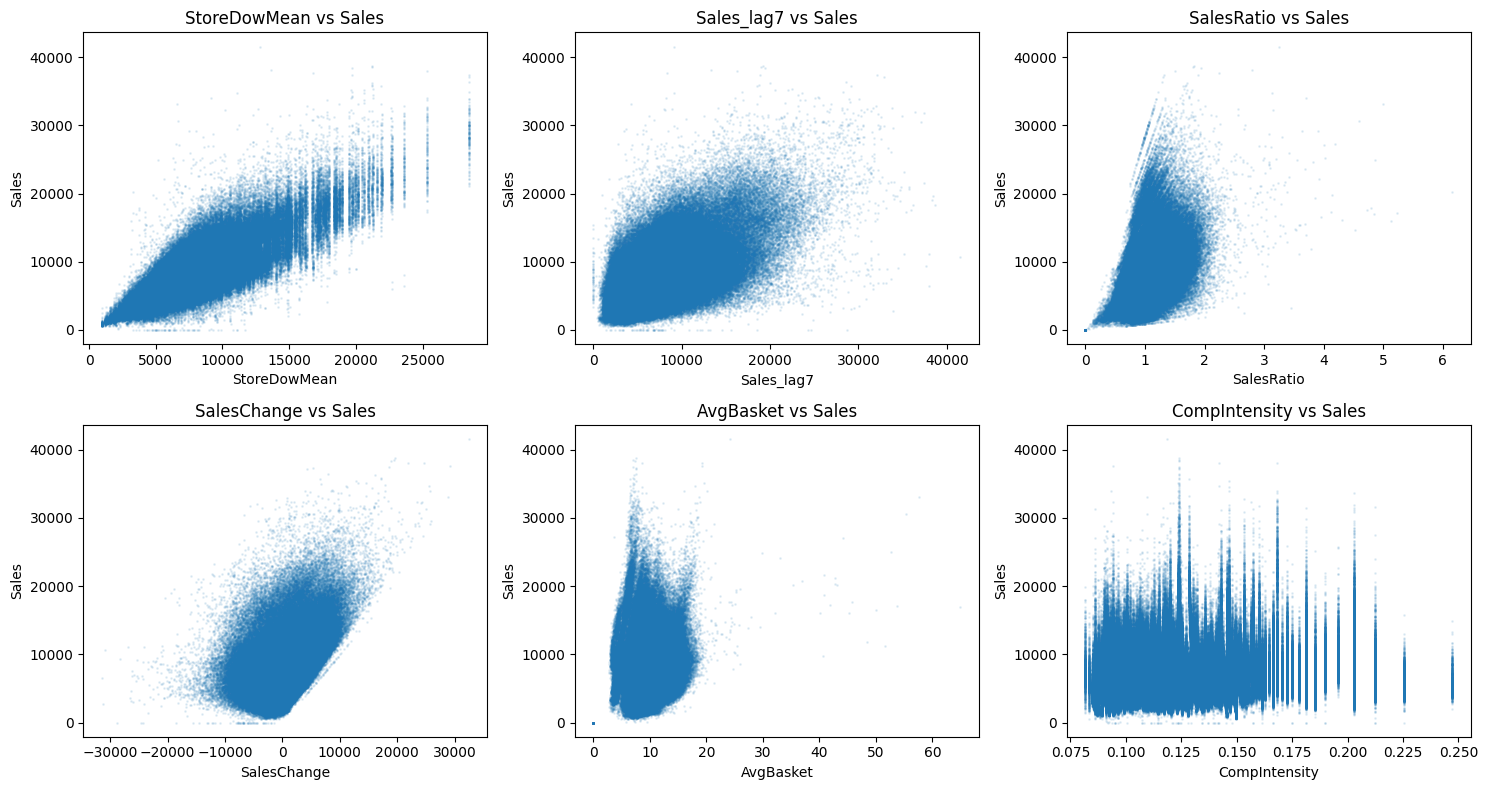

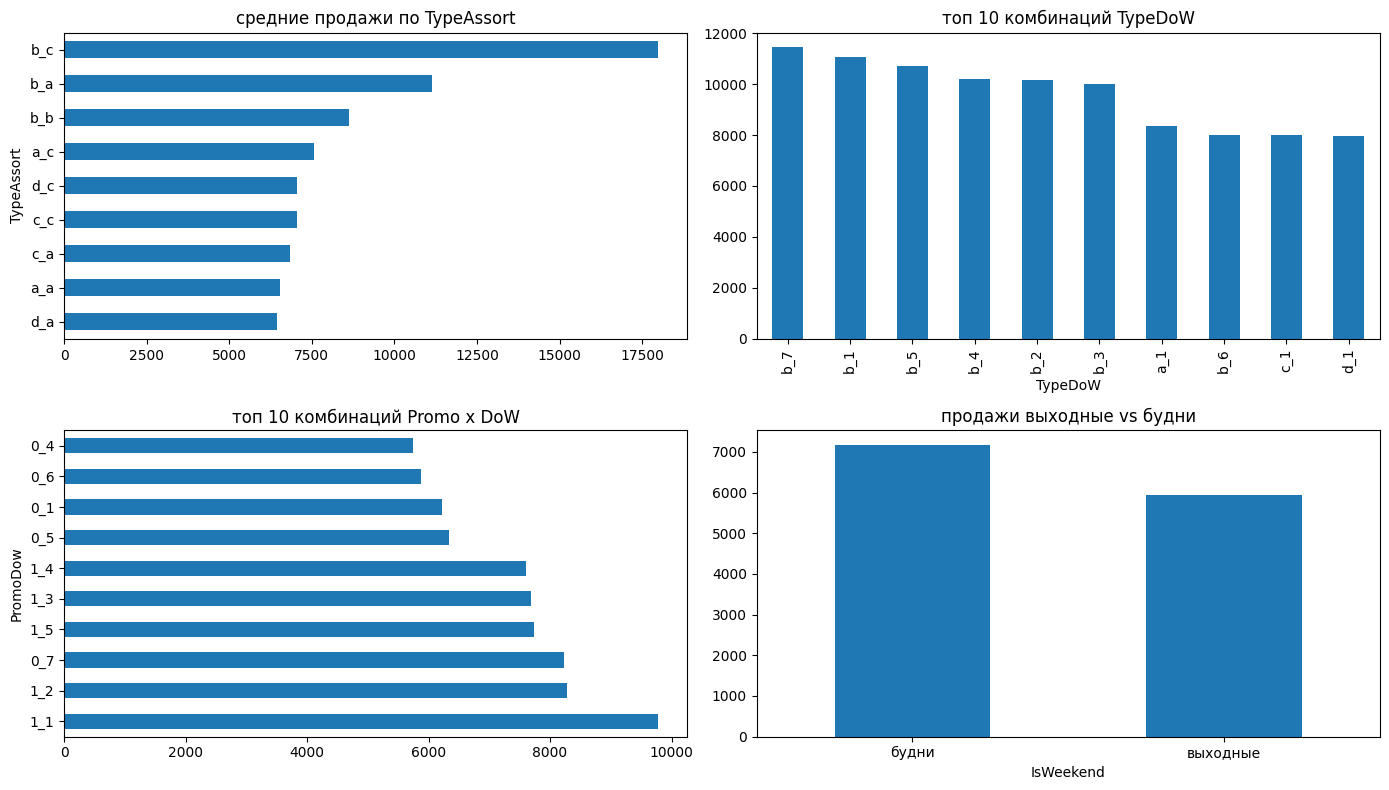

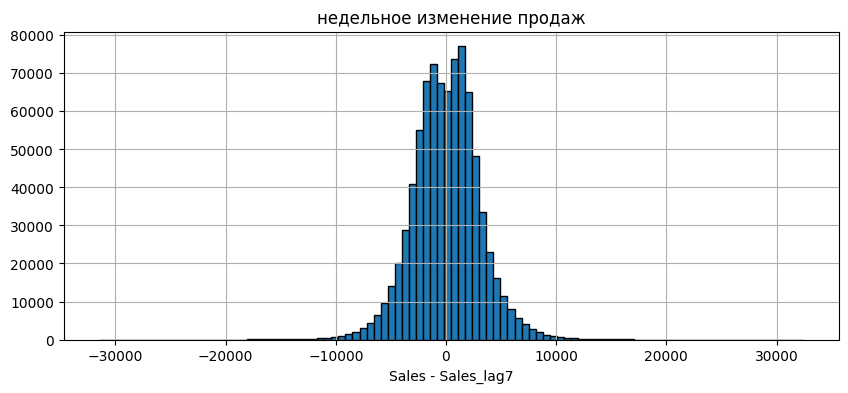


итого значимых: 6
список: ['StoreDowMean', 'Sales_lag7', 'SalesRatio', 'SalesChange', 'AvgBasket', 'IsWeekend']


In [57]:
def add_holiday_distance(df):
    """расстояние до ближайшего праздника в днях"""
    return df.assign(IsHoliday=(df['StateHoliday'] != '0').astype(int))

def add_month_position(df):
    """позиция в месяце"""
    return df.assign(
        IsMonthEnd=(df['Day'] > 25).astype(int),
        IsMonthStart=(df['Day'] <= 7).astype(int),
        Quarter=((df['Month'] - 1) // 3 + 1)
    )

def add_promo_features(df):
    """взаимодействия промо"""
    promo2_val = df['Promo2Active'] if 'Promo2Active' in df.columns else df.get('Promo2', 0)
    promo_freq = df.groupby('Store')['Promo'].transform(lambda x: x.rolling(28, min_periods=1).mean())
    
    return df.assign(
        PromoCombo=df['Promo'] * promo2_val,
        PromoFreq_4w=promo_freq,
        PromoDow=df['Promo'].astype(str) + '_' + df['DayOfWeek'].astype(str)
    )

def add_competition_features(df):
    """признаки конкуренции"""
    median_dist = df['CompetitionDistance'].median()
    comp_open = df['CompetitionOpen'] if 'CompetitionOpen' in df.columns else 0
    log_dist = np.log1p(df['CompetitionDistance'].fillna(median_dist))
    
    return df.assign(
        LogCompDist=log_dist,
        NewCompetition=(comp_open < 6).astype(int) if isinstance(comp_open, pd.Series) else 0,
        CompIntensity=1 / (log_dist + 1)
    )

def add_store_aggregates(df):
    """агрегаты по магазинам"""
    store_dow = df.groupby(['Store', 'DayOfWeek'])['Sales'].mean().rename('StoreDowMean')
    type_month = df.groupby(['StoreType', 'Month'])['Sales'].mean().rename('TypeMonthMean')
    
    return df.merge(store_dow, on=['Store', 'DayOfWeek'], how='left')\
             .merge(type_month, on=['StoreType', 'Month'], how='left')

def add_lag_features(df):
    """лаги продаж"""
    df = df.sort_values(['Store', 'Date'])
    grp = df.groupby('Store')['Sales']
    
    return df.assign(
        Sales_lag7=grp.shift(7),
        Sales_lag14=grp.shift(14),
        Sales_ma7=grp.transform(lambda x: x.rolling(7, min_periods=1).mean()),
        SalesChange=grp.diff(7)
    )

def add_ratio_features(df):
    """соотношения"""
    store_mean = df['StoreMeanSales'] if 'StoreMeanSales' in df.columns else df['Sales'].mean()
    
    return df.assign(
        AvgBasket=df['Sales'] / df['Customers'].replace(0, 1),
        SalesDeviation=df['Sales'] - store_mean,
        SalesRatio=df['Sales'] / df['StoreDowMean']
    )

def add_categorical_combos(df):
    """комбинации категорий"""
    return df.assign(
        TypeAssort=df['StoreType'] + '_' + df['Assortment'],
        TypeDoW=df['StoreType'] + '_' + df['DayOfWeek'].astype(str),
        IsWeekend=(df['DayOfWeek'] >= 6).astype(int)
    )

def build_features(df):
    """собираем все фичи"""
    return (df.pipe(add_holiday_distance)
              .pipe(add_month_position)
              .pipe(add_promo_features)
              .pipe(add_competition_features)
              .pipe(add_store_aggregates)
              .pipe(add_lag_features)
              .pipe(add_ratio_features)
              .pipe(add_categorical_combos))

def analyze_features(df, feature_list, target='Sales'):
    """анализ корреляций и визуализация"""
    corrs = df[feature_list + [target]].corr()[target].drop(target).sort_values(ascending=False)
    
    print("корреляции с Sales:")
    print(corrs)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, feat in enumerate(corrs.head(6).index):
        df.plot.scatter(x=feat, y=target, alpha=0.1, ax=axes[idx], s=1)
        axes[idx].set_title(f'{feat} vs {target}')
    
    plt.tight_layout()
    plt.show()
    
    return corrs

def plot_category_analysis(df):
    """категориальный анализ"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    df.groupby('TypeAssort')['Sales'].mean().sort_values().plot(kind='barh', ax=axes[0,0])
    axes[0,0].set_title('средние продажи по TypeAssort')
    
    df.groupby('TypeDoW')['Sales'].mean().nlargest(10).plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('топ 10 комбинаций TypeDoW')
    
    df.groupby('PromoDow')['Sales'].mean().nlargest(10).plot(kind='barh', ax=axes[1,0])
    axes[1,0].set_title('топ 10 комбинаций Promo x DoW')
    
    df.groupby('IsWeekend')['Sales'].mean().plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('продажи выходные vs будни')
    axes[1,1].set_xticklabels(['будни', 'выходные'], rotation=0)
    
    plt.tight_layout()
    plt.show()

def plot_distributions(df):
    """распределения изменений"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    df['SalesChange'].dropna().hist(bins=100, ax=ax, edgecolor='black')
    ax.set_title('недельное изменение продаж')
    ax.set_xlabel('Sales - Sales_lag7')
    plt.show()

train_featured = build_features(train_merged[train_merged['Open']==1].copy())

features_to_check = ['IsHoliday', 'IsMonthEnd', 'Quarter', 'PromoCombo', 
                     'LogCompDist', 'StoreDowMean', 'Sales_lag7', 'AvgBasket',
                     'SalesRatio', 'SalesChange', 'IsWeekend', 'CompIntensity']

corrs = analyze_features(train_featured, features_to_check)

plot_category_analysis(train_featured)
plot_distributions(train_featured)

significant = corrs[corrs.abs() > 0.15].index.tolist()
print(f"\nитого значимых: {len(significant)}")
print(f"список: {significant}")

День недели дает жесткий цикл с пиками в понедельник и провалами в воскресенье. Декабрь в 2-3 раза выше базы из-за НГ. Так что основывал на них гипотезы при генерации признаков.

Создал temporal features чтобы поймать календарные эффекты. Quarter отражает квартальную динамику, IsMonthEnd/IsMonthStart ловят зарплатное поведение, IsWeekend показал просадку на 15%. IsHoliday оказался слабым но оставил.

Duration features CompetitionOpen и Promo2Open сделал потому что сырые годы бесполезны, но важно сколько времени прошло с события.

Promo interactions критичны. PromoCombo ловит синергию Promo x Promo2, PromoFreq_4w показывает частоту акций за месяц - если слишком часто то обесцениваются, PromoDow оказался довольно мощным. Промо в понедельник дает 10к против 5-6к в обычные дни.

Competition features сделал после того как увидел что сырое расстояние не работает. LogCompDist применил потому что распределение асимметрично с хвостом до 75км - логарифм нормализует. CompBin для деревьев чтобы проще находили пороги. NewCompetition помечает адаптационный период до 6 месяцев. Посчитал CompIntensity предполагая обратную зависимость но корреляция была слабая 0.09.

Агрегаты по магазинам сильные. StoreDowMean дал корреляцию 0.84 - каждый магазин имеет стабильный недельный паттерн. TypeMonthMean ловит сезонность на уровне типа. SalesRatio (текущие/средние) с корреляцией 0.51 показывает отклонение от нормы.

Категориальные комбо TypeAssort и TypeDoW сделал потому что эффекты нелинейны. Полный ассортимент работает только в крупных магазинах, день недели влияет по-разному на разные типы.

Для градиентного бустинга использую все признаки как есть. Таргет в log1p потому что RMSPE штрафует относительную ошибку. Циклические sin/cos не нужны для деревянных моделей.

Для линейных моделей OneHot для низкой кардинальности, target encoding для Store чтобы не плодить тысячи колонок. DayOfWeek и Month в sin/cos. StandardScaler на числовые потому что Ridge да и Lasso чувствительны к масштабу. Взаимодействия Promo x DayOfWeek, StoreType x Assortment создаю руками - линейная модель сама не найдет. Таргет log1p.

Приоритетные признаки: StoreDowMean 0.84, SalesRatio 0.51, SalesChange 0.49, DayOfWeek, Month, Promo, PromoDow, IsWeekend. Слабые можно дропнуть: SchoolHoliday, сырой CompetitionDistance, PromoCombo, Quarter, IsMonthEnd, IsHoliday так как для них все корреляции с тагетом < 0.1.

## Моделирование

In [308]:
def lama_submit(model, X_test):
    '''функция подготовки сабмита'''
    X_test = X_test.reset_index(drop=True).copy()
    test_struct = X_test[['Id', 'Open']].copy()
    test_features = X_test.drop(['Id', 'Open'], axis=1)
    
    lama_predictions = model.predict(test_features)
    predictions = lama_predictions.data[:, 0]
    
    test_struct['Sales'] = predictions
    test_struct.loc[test_struct['Open'] == 0, 'Sales'] = 0
    return test_struct[['Id', 'Sales']]

### Разделение данных

In [295]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

def encode_promo_months(df):
    """one-hot для месяцев из PromoInterval"""
    df = df.copy()
    
    promo_lists = df['PromoInterval'].fillna('').str.split(',')
    
    for month in MONTHS:
        df[f'Promo_{month}'] = promo_lists.map(lambda x: int(month in x))
    
    df['Promo_NaN'] = df['PromoInterval'].isna().astype(bool)
    
    return df.drop(columns=['PromoInterval'])

def load_and_split_data(data_dir='data', val_size=0.1):
    """загрузка, фильтрация нулей и разделение на x/y"""
    train = pd.read_csv(f'{data_dir}/train.csv', dtype={'StateHoliday': str})
    test = pd.read_csv(f'{data_dir}/test.csv', dtype={'StateHoliday': str})
    store = pd.read_csv(f'{data_dir}/store.csv')
    
    # объединяем
    train = train.merge(store, on='Store', how='left')
    test = test.merge(store, on='Store', how='left')
    
    # убираем закрытые магазины и нули сразу, чтобы x и y соответствовали друг другу
    train = train[(train['Open'] == 1) & (train['Sales'] > 0)].reset_index(drop=True)
    
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])
    train = train.sort_values('Date').reset_index(drop=True)
    
    split_idx = int(len(train) * (1 - val_size))
    split_date = train['Date'].iloc[split_idx]
    
    # разбиваем по времени
    train_part = train[train['Date'] < split_date]
    val_part = train[train['Date'] >= split_date]
    
    train_part = encode_promo_months(train_part)
    val_part = encode_promo_months(val_part)
    test = encode_promo_months(test)

    # выделяем таргет и удаляем лик customers
    drop_cols = ['Sales', 'Customers', 'Open']
    
    xtr = train_part.drop(columns=drop_cols)
    ytr = train_part['Sales'] # логарифмировать лучше перед fit
    
    xval = val_part.drop(columns=drop_cols)
    yval = val_part['Sales']
    
    # в тесте sales нет, но open и customers убрать надо если есть
    #X_test = test.drop(columns=['Open', 'Customers', 'Id'], errors='ignore')
    
    print(f"X_train: {xtr.shape}, y_train: {ytr.shape}")
    print(f"X_val: {xval.shape}, y_val: {yval.shape}")
    print(f"Test: {test.shape}")
    
    return xtr, ytr, xval, yval, test

# теперь загружаем чистые данные
X_train, y_train, X_val, y_val, X_test = load_and_split_data()

X_train: (759868, 27), y_train: (759868,)
X_val: (84470, 27), y_val: (84470,)
Test: (41088, 29)


In [316]:
X_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Promo_Jan', 'Promo_Feb',
       'Promo_Mar', 'Promo_Apr', 'Promo_May', 'Promo_June', 'Promo_July',
       'Promo_Aug', 'Promo_Sept', 'Promo_Oct', 'Promo_Nov', 'Promo_Dec',
       'Promo_NaN'],
      dtype='object')

Временной ряд нельзя перемешивать. Рандомный сплит череват утечкой данных. Валидация может получиться необъективной, особенно, если использовать лаги! 

Да и реальный тест идет после трейна (август 2015), так что валидацию надо брать тоже последним периодом. Последние 5% данных = июль 2015, ближайший к тесту период.

Заранее отфильтровываем только Open=1 для обучения, так как при Open=0 известно что Sales=0(из EDA). Тажке дропаем поле Open, так как оно становится контсантным. Предсказывать в test будем все, но потом просто заменим предсказания где Open = 0 на 0.

Также фильтруем Sales>0, так как Sales < 0 - это аномалии.

### Бейзлайны LightAutoML

#### LAMA baseline n1

В первом бейзлайне мы используем стандартный конфиг без огранияений на модели и Optuna оптимизацию

In [169]:
task = Task('reg')
lama1_roles = {
    'target': 'Sales',
}

lama1_automl = TabularAutoML(
    task = task,
    timeout = 5000,
    cpu_limit = 1,
    reader_params = {'n_jobs': 1, 'random_state': RANDOM_STATE},
)

lama1_train = X_train.copy()
lama1_val = X_val.copy()
lama1_train['Sales'] = y_train
lama1_val['Sales'] = y_val
lama1_val_predictions = lama1_automl.fit_predict(train_data=lama1_train, valid_data=lama1_val, roles = lama1_roles, verbose = 1)

[00:46:58] Stdout logging level is INFO.
[00:46:58] Task: reg

[00:46:58] Start automl preset with listed constraints:
[00:46:58] - time: 5000.00 seconds
[00:46:58] - CPU: 1 cores
[00:46:58] - memory: 16 GB

[00:46:58] Train data shape: (759868, 28)

[00:47:00] Layer 1 train process start. Time left 4998.25 secs
[00:47:24] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[00:47:24] Time left 4974.03 secs

[00:47:47] Selector_LightGBM fitting and predicting completed
[00:48:09] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[00:48:09] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s][2025-12-09 00:48:09,188] (INFO): A new study created in memory with name: no-name-f23558d3-655b-4dd5-89cb-23e6bdc241f8
[2025-12-09 00:48:34,879] (INFO): Trial 0 finished with value: -997699.1875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -997699.1875.
Optimization Progress:   8%|▊         | 8/101 [06:01<1:10:02, 45.19s/it, best_trial=1, best_value=-9.16e+5]

[00:54:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[00:55:57] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[00:55:57] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s][2025-12-09 00:55:57,834] (INFO): A new study created in memory with name: no-name-a27af773-4a85-43af-bca3-1329eb88b5cd
[2025-12-09 00:56:35,740] (INFO): Trial 0 finished with value: -1333628.625 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -1333628.625.
Optimization Progress:   7%|▋         | 7/101 [05:18<1:11:22, 45.56s/it, best_trial=6, best_value=-1.28e+6]

[01:01:16] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[01:01:59] Time left 4098.79 secs

[01:01:59] Layer 1 training completed.

[01:01:59] Blending: optimization starts with equal weights. Score = -1125886.6250000
[01:01:59] Blending: iteration 0: score = -915565.0625000, weights = [0. 0. 1. 0. 0.]
[01:01:59] Blending: no improvements for score. Terminated.

[01:01:59] Blending: best score = -915565.0625000, best weights = [0. 0. 1. 0. 0.]
[01:02:00] Automl preset training completed in 901.28 seconds

[01:02:00] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



In [170]:
lama1_y_true = lama1_val.Sales.to_numpy()
lama1_y_pred = lama1_val_predictions.data.squeeze()
rmspe(lama1_y_true, lama1_y_pred)

0.1346409817659902

In [171]:
lama_submit(lama1_automl, X_test).to_csv('submission_lama1.csv', index=False)

#### LAMA baseline n2

Конфигурация с легкими моделями и большим числом итераций для Optuna. Тюнимся без кросс-валидацмм на отложенных данных из "будущего", чтобы не было утечек. \

Отбираем 80% самых важных признаков. 

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

task = Task('reg')

#['Store', 'DayOfWeek', 'Date', 'Promo', 'StateHoliday', 'SchoolHoliday',
# 'StoreType', 'Assortment', 'CompetitionDistance',
# 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
# 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

lama2_roles = {
    'target': 'Sales',
    'drop': ['DayOfWeek'],
    'datetime': ['Date'],
    'numeric': ['CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek'],
    'category': ['Store', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'Promo2', 'Promo2SinceYear',
    'Promo_Jan', 'Promo_Feb', 'Promo_Mar', 'Promo_Apr', 'Promo_May', 'Promo_Jun', 'Promo_Jul', 'Promo_Aug', 'Promo_Sep', 'Promo_Oct', 'Promo_Nov', 'Promo_Dec', 'Promo_NaN']
}

lama2_automl = TabularUtilizedAutoML(
    task=task,
    timeout=5000,
    cpu_limit=4,
    
    # Reader параметры
    reader_params={
        'n_jobs': 1,
        'random_state': RANDOM_STATE,
        'advanced_roles': True,
    },
    
    general_params={
        'use_algos': [['lgb_tuned', 'linear_l2']]
    },
    
    tuning_params={
        'fit_on_holdout': True,
        'max_tuning_iter': 50,
        'max_tuning_time': 2000,
    },
    
    # Feature selection параметры
    selection_params={
        'select_algos': ['gbm', 'linear_l2'],
        'selection_feats_rate': 0.8,  # доля признаков для отбора
        'max_features_cnt_in_result': None,
    }
)

lama2_train = X_train.copy()
lama2_val = X_val.copy()
lama2_train['Sales'] = y_train
lama2_val['Sales'] = y_val

lama2_val_predictions = lama2_automl.fit_predict(
    train_data=lama2_train,
    valid_data=lama2_val,
    roles=lama2_roles,
    verbose=4
)

[04:58:01] Start automl utilizator with listed constraints:
[04:58:01] - time: 5000.00 seconds
[04:58:01] - CPU: 4 cores
[04:58:01] - memory: 16 GB

[04:58:01] If one preset completes earlier, next preset configuration will be started

[04:58:01] ==================================================
[04:58:01] Start 0 automl preset configuration:
[04:58:01] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[04:58:01] Found reader_params in kwargs, need to combine
[04:58:01] Merged variant for reader_params = {'n_jobs': 1, 'random_state': 42, 'advanced_roles': True}
[04:58:01] Found general_params in kwargs, need to combine
[04:58:01] Merged variant for general_params = {'use_algos': [['lgb_tuned', 'linear_l2']], 'return_all_predictions': False}
[04:58:01] Stdout logging level is DEBUG.
[04:58:01] Task: reg

[04:58:01] Start automl preset with listed constraints:
[04:58:01] - 

[2025-12-08 04:58:35,163] (INFO): A new study created in memory with name: no-name-5b0dfab2-c539-4185-9e05-fe30f19f9ca7


[04:58:35] Training until validation scores don't improve for 100 rounds
[04:58:38] [100]	valid's l2: 1.22356e+06
[04:58:41] [200]	valid's l2: 1.11223e+06
[04:58:43] [300]	valid's l2: 1.06797e+06
[04:58:45] [400]	valid's l2: 1.0486e+06
[04:58:47] [500]	valid's l2: 1.03591e+06
[04:58:49] [600]	valid's l2: 1.02335e+06
[04:58:52] [700]	valid's l2: 1.01956e+06
[04:58:54] [800]	valid's l2: 1.01649e+06
[04:58:56] [900]	valid's l2: 1.01273e+06
[04:58:57] [1000]	valid's l2: 1.00777e+06
[04:58:59] [1100]	valid's l2: 1.00458e+06
[04:59:01] [1200]	valid's l2: 1.00204e+06
[04:59:03] [1300]	valid's l2: 1.00018e+06
[04:59:05] [1400]	valid's l2: 999577
[04:59:07] [1500]	valid's l2: 998718
[04:59:09] [1600]	valid's l2: 996481
[04:59:11] [1700]	valid's l2: 995750
[04:59:13] [1800]	valid's l2: 997607
[04:59:13] Early stopping, best iteration is:
[1718]	valid's l2: 994990


[2025-12-08 04:59:16,378] (INFO): Trial 0 finished with value: -994990.0 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125}. Best is trial 0 with value: -994990.0.


[04:59:16] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125} scored -994990.0 in 0:00:41.213998
[04:59:16] Training until validation scores don't improve for 100 rounds
[04:59:18] [100]	valid's l2: 1.50375e+06
[04:59:20] [200]	valid's l2: 1.3358e+06
[04:59:21] [300]	valid's l2: 1.26273e+06
[04:59:23] [400]	valid's l2: 1.21337e+06
[04:59:24] [500]	valid's l2: 1.18771e+06
[04:59:25] [600]	valid's l2: 1.16579e+06
[04:59:27] [700]	valid's l2: 1.14789e+06
[04:59:28] [800]	valid's l2: 1.12899e+06
[04:59:29] [900]	valid's l2: 1.11279e+06
[04:59:31] [1000]	valid's l2: 1.10127e+06
[04:59:32] [1100]	valid's l2: 1.09174e+06
[04:59:33] [1200]	valid's l2: 1.08299e+06
[04:59:35] [1300]	valid's l2: 1.07663e+06
[04:59:36] [1400]	valid's l2: 1.07084e+06
[04:59:37] [1500]	valid's l2: 1.06684e+06
[04:59:39] [1600]	valid's l2: 1.05832e+06
[04:59:40] [1700]	valid's l2: 1.05266e+06


[2025-12-08 04:59:46,408] (INFO): Trial 1 finished with value: -1035232.0 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53, 'bagging_fraction': 0.5290418060840998, 'min_sum_hessian_in_leaf': 2.9154431891537547}. Best is trial 0 with value: -994990.0.


[04:59:46] Trial 2 with hyperparameters {'feature_fraction': 0.5780093202212182, 'num_leaves': 53, 'bagging_fraction': 0.5290418060840998, 'min_sum_hessian_in_leaf': 2.9154431891537547} scored -1035232.0 in 0:00:30.026819
[04:59:46] Training until validation scores don't improve for 100 rounds
[04:59:49] [100]	valid's l2: 1.28375e+06
[04:59:52] [200]	valid's l2: 1.12572e+06
[04:59:54] [300]	valid's l2: 1.07022e+06
[04:59:55] [400]	valid's l2: 1.03848e+06
[04:59:57] [500]	valid's l2: 1.02475e+06
[04:59:59] [600]	valid's l2: 1.01348e+06
[05:00:01] [700]	valid's l2: 1.0028e+06
[05:00:03] [800]	valid's l2: 993163
[05:00:05] [900]	valid's l2: 989097
[05:00:07] [1000]	valid's l2: 987095
[05:00:09] [1100]	valid's l2: 985368
[05:00:12] [1200]	valid's l2: 981381
[05:00:14] [1300]	valid's l2: 977303
[05:00:16] [1400]	valid's l2: 978262
[05:00:16] Early stopping, best iteration is:
[1304]	valid's l2: 977190


[2025-12-08 05:00:18,572] (INFO): Trial 2 finished with value: -977189.5 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185, 'bagging_fraction': 0.5102922471479012, 'min_sum_hessian_in_leaf': 7.579479953348009}. Best is trial 2 with value: -977189.5.


[05:00:18] Trial 3 with hyperparameters {'feature_fraction': 0.8005575058716043, 'num_leaves': 185, 'bagging_fraction': 0.5102922471479012, 'min_sum_hessian_in_leaf': 7.579479953348009} scored -977189.5 in 0:00:32.160798
[05:00:18] Training until validation scores don't improve for 100 rounds
[05:00:20] [100]	valid's l2: 1.46624e+06
[05:00:22] [200]	valid's l2: 1.26767e+06
[05:00:23] [300]	valid's l2: 1.17272e+06
[05:00:24] [400]	valid's l2: 1.12318e+06
[05:00:25] [500]	valid's l2: 1.09825e+06
[05:00:27] [600]	valid's l2: 1.07596e+06
[05:00:28] [700]	valid's l2: 1.05658e+06
[05:00:29] [800]	valid's l2: 1.04536e+06
[05:00:30] [900]	valid's l2: 1.03327e+06
[05:00:31] [1000]	valid's l2: 1.02206e+06
[05:00:32] [1100]	valid's l2: 1.01019e+06
[05:00:33] [1200]	valid's l2: 1.00331e+06
[05:00:34] [1300]	valid's l2: 996390
[05:00:35] [1400]	valid's l2: 994831
[05:00:36] [1500]	valid's l2: 990288
[05:00:37] [1600]	valid's l2: 988015
[05:00:38] [1700]	valid's l2: 985773
[05:00:40] [1800]	valid's 

[2025-12-08 05:00:42,000] (INFO): Trial 3 finished with value: -985135.9375 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254}. Best is trial 2 with value: -977189.5.


[05:00:42] Trial 4 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254} scored -985135.9375 in 0:00:23.424766
[05:00:42] Training until validation scores don't improve for 100 rounds
[05:00:45] [100]	valid's l2: 1.30963e+06
[05:00:47] [200]	valid's l2: 1.18357e+06
[05:00:49] [300]	valid's l2: 1.13606e+06
[05:00:50] [400]	valid's l2: 1.10722e+06
[05:00:52] [500]	valid's l2: 1.08642e+06
[05:00:54] [600]	valid's l2: 1.07272e+06
[05:00:55] [700]	valid's l2: 1.06272e+06
[05:00:57] [800]	valid's l2: 1.05151e+06
[05:00:58] [900]	valid's l2: 1.04287e+06
[05:01:00] [1000]	valid's l2: 1.03494e+06
[05:01:02] [1100]	valid's l2: 1.0302e+06
[05:01:03] [1200]	valid's l2: 1.02854e+06
[05:01:05] [1300]	valid's l2: 1.02876e+06
[05:01:06] Early stopping, best iteration is:
[1253]	valid's l2: 1.02542e+06


[2025-12-08 05:01:07,521] (INFO): Trial 4 finished with value: -1025418.375 and parameters: {'feature_fraction': 0.6521211214797689, 'num_leaves': 141, 'bagging_fraction': 0.7159725093210578, 'min_sum_hessian_in_leaf': 0.014618962793704957}. Best is trial 2 with value: -977189.5.


[05:01:07] Trial 5 with hyperparameters {'feature_fraction': 0.6521211214797689, 'num_leaves': 141, 'bagging_fraction': 0.7159725093210578, 'min_sum_hessian_in_leaf': 0.014618962793704957} scored -1025418.375 in 0:00:25.517522
[05:01:07] Training until validation scores don't improve for 100 rounds
[05:01:09] [100]	valid's l2: 1.51509e+06
[05:01:10] [200]	valid's l2: 1.34146e+06
[05:01:12] [300]	valid's l2: 1.24949e+06
[05:01:13] [400]	valid's l2: 1.19134e+06
[05:01:14] [500]	valid's l2: 1.15689e+06
[05:01:15] [600]	valid's l2: 1.1249e+06
[05:01:16] [700]	valid's l2: 1.10732e+06
[05:01:17] [800]	valid's l2: 1.09073e+06
[05:01:18] [900]	valid's l2: 1.075e+06
[05:01:19] [1000]	valid's l2: 1.06272e+06
[05:01:20] [1100]	valid's l2: 1.04982e+06
[05:01:21] [1200]	valid's l2: 1.04509e+06
[05:01:22] [1300]	valid's l2: 1.03692e+06
[05:01:23] [1400]	valid's l2: 1.03298e+06
[05:01:24] [1500]	valid's l2: 1.02679e+06
[05:01:25] [1600]	valid's l2: 1.02296e+06
[05:01:26] [1700]	valid's l2: 1.01781e+0

[2025-12-08 05:01:30,908] (INFO): Trial 5 finished with value: -1004308.1875 and parameters: {'feature_fraction': 0.8059264473611898, 'num_leaves': 49, 'bagging_fraction': 0.6460723242676091, 'min_sum_hessian_in_leaf': 0.029204338471814112}. Best is trial 2 with value: -977189.5.


[05:01:30] Trial 6 with hyperparameters {'feature_fraction': 0.8059264473611898, 'num_leaves': 49, 'bagging_fraction': 0.6460723242676091, 'min_sum_hessian_in_leaf': 0.029204338471814112} scored -1004308.1875 in 0:00:23.385410
[05:01:31] Training until validation scores don't improve for 100 rounds
[05:01:34] [100]	valid's l2: 1.25937e+06
[05:01:37] [200]	valid's l2: 1.12126e+06
[05:01:40] [300]	valid's l2: 1.0784e+06
[05:01:42] [400]	valid's l2: 1.04755e+06
[05:01:44] [500]	valid's l2: 1.03077e+06
[05:01:47] [600]	valid's l2: 1.01813e+06
[05:01:49] [700]	valid's l2: 1.00731e+06
[05:01:51] [800]	valid's l2: 998958
[05:01:54] [900]	valid's l2: 991956
[05:01:56] [1000]	valid's l2: 987969
[05:01:58] [1100]	valid's l2: 982486
[05:02:01] [1200]	valid's l2: 979324
[05:02:03] [1300]	valid's l2: 977237
[05:02:06] [1400]	valid's l2: 976656
[05:02:08] [1500]	valid's l2: 975398
[05:02:10] [1600]	valid's l2: 978426
[05:02:11] Early stopping, best iteration is:
[1512]	valid's l2: 974840


[2025-12-08 05:02:14,431] (INFO): Trial 6 finished with value: -974839.6875 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326}. Best is trial 6 with value: -974839.6875.


[05:02:14] Trial 7 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326} scored -974839.6875 in 0:00:43.518353
[05:02:14] Training until validation scores don't improve for 100 rounds
[05:02:16] [100]	valid's l2: 1.6501e+06
[05:02:18] [200]	valid's l2: 1.45467e+06
[05:02:19] [300]	valid's l2: 1.34544e+06
[05:02:20] [400]	valid's l2: 1.29406e+06
[05:02:21] [500]	valid's l2: 1.2548e+06
[05:02:22] [600]	valid's l2: 1.22093e+06
[05:02:23] [700]	valid's l2: 1.19232e+06
[05:02:24] [800]	valid's l2: 1.17243e+06
[05:02:25] [900]	valid's l2: 1.15822e+06
[05:02:26] [1000]	valid's l2: 1.14591e+06
[05:02:27] [1100]	valid's l2: 1.13303e+06
[05:02:28] [1200]	valid's l2: 1.12164e+06
[05:02:29] [1300]	valid's l2: 1.10902e+06
[05:02:30] [1400]	valid's l2: 1.09896e+06
[05:02:31] [1500]	valid's l2: 1.0925e+06
[05:02:31] [1600]	valid's l2: 1.08574e+06
[05:02:32] [1700]	valid's l2: 1.08041e+06


[2025-12-08 05:02:37,852] (INFO): Trial 7 finished with value: -1062599.625 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 27, 'bagging_fraction': 0.8037724259507192, 'min_sum_hessian_in_leaf': 0.004809461967501573}. Best is trial 6 with value: -974839.6875.


[05:02:37] Trial 8 with hyperparameters {'feature_fraction': 0.7962072844310213, 'num_leaves': 27, 'bagging_fraction': 0.8037724259507192, 'min_sum_hessian_in_leaf': 0.004809461967501573} scored -1062599.625 in 0:00:23.414405
[05:02:38] Training until validation scores don't improve for 100 rounds
[05:02:43] [100]	valid's l2: 1.22829e+06
[05:02:46] [200]	valid's l2: 1.11493e+06
[05:02:50] [300]	valid's l2: 1.07383e+06
[05:02:53] [400]	valid's l2: 1.06845e+06
[05:02:56] [500]	valid's l2: 1.05165e+06
[05:03:00] [600]	valid's l2: 1.04089e+06
[05:03:03] [700]	valid's l2: 1.03156e+06
[05:03:06] [800]	valid's l2: 1.02658e+06
[05:03:09] [900]	valid's l2: 1.02164e+06
[05:03:12] [1000]	valid's l2: 1.01804e+06
[05:03:15] [1100]	valid's l2: 1.01599e+06
[05:03:18] [1200]	valid's l2: 1.01399e+06
[05:03:21] [1300]	valid's l2: 1.01223e+06
[05:03:24] [1400]	valid's l2: 1.01083e+06
[05:03:27] [1500]	valid's l2: 1.00924e+06
[05:03:29] [1600]	valid's l2: 1.0084e+06
[05:03:32] [1700]	valid's l2: 1.00777e+

[2025-12-08 05:03:43,855] (INFO): Trial 8 finished with value: -1006820.75 and parameters: {'feature_fraction': 0.5325257964926398, 'num_leaves': 243, 'bagging_fraction': 0.9828160165372797, 'min_sum_hessian_in_leaf': 1.7123375973163988}. Best is trial 6 with value: -974839.6875.


[05:03:43] Trial 9 with hyperparameters {'feature_fraction': 0.5325257964926398, 'num_leaves': 243, 'bagging_fraction': 0.9828160165372797, 'min_sum_hessian_in_leaf': 1.7123375973163988} scored -1006820.75 in 0:01:05.997216
[05:03:44] Training until validation scores don't improve for 100 rounds
[05:03:46] [100]	valid's l2: 1.53799e+06
[05:03:47] [200]	valid's l2: 1.39678e+06
[05:03:49] [300]	valid's l2: 1.31534e+06
[05:03:50] [400]	valid's l2: 1.268e+06
[05:03:51] [500]	valid's l2: 1.22637e+06
[05:03:52] [600]	valid's l2: 1.19793e+06
[05:03:53] [700]	valid's l2: 1.17827e+06
[05:03:55] [800]	valid's l2: 1.15927e+06
[05:03:56] [900]	valid's l2: 1.16024e+06
[05:03:56] Early stopping, best iteration is:
[801]	valid's l2: 1.1589e+06


[2025-12-08 05:03:56,864] (INFO): Trial 9 finished with value: -1158897.5 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026}. Best is trial 6 with value: -974839.6875.


[05:03:56] Trial 10 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026} scored -1158897.5 in 0:00:13.002875
[05:03:57] Training until validation scores don't improve for 100 rounds
[05:04:00] [100]	valid's l2: 1.27268e+06
[05:04:03] [200]	valid's l2: 1.11326e+06
[05:04:05] [300]	valid's l2: 1.0475e+06
[05:04:07] [400]	valid's l2: 1.02071e+06
[05:04:09] [500]	valid's l2: 1.00724e+06
[05:04:11] [600]	valid's l2: 996107
[05:04:13] [700]	valid's l2: 989363
[05:04:15] [800]	valid's l2: 981486
[05:04:16] [900]	valid's l2: 979539
[05:04:18] [1000]	valid's l2: 975446
[05:04:20] [1100]	valid's l2: 973861
[05:04:22] Early stopping, best iteration is:
[1090]	valid's l2: 971500


[2025-12-08 05:04:24,317] (INFO): Trial 10 finished with value: -971500.1875 and parameters: {'feature_fraction': 0.9725682721151933, 'num_leaves': 185, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.36240382475490457}. Best is trial 10 with value: -971500.1875.


[05:04:24] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151933, 'num_leaves': 185, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.36240382475490457} scored -971500.1875 in 0:00:27.449518
[05:04:24] Training until validation scores don't improve for 100 rounds
[05:04:28] [100]	valid's l2: 1.26015e+06
[05:04:31] [200]	valid's l2: 1.10141e+06
[05:04:33] [300]	valid's l2: 1.04295e+06
[05:04:35] [400]	valid's l2: 1.01393e+06
[05:04:37] [500]	valid's l2: 1.00267e+06
[05:04:39] [600]	valid's l2: 992493
[05:04:40] [700]	valid's l2: 984773
[05:04:42] [800]	valid's l2: 977363
[05:04:44] [900]	valid's l2: 973035
[05:04:46] [1000]	valid's l2: 971535
[05:04:48] [1100]	valid's l2: 967123
[05:04:50] [1200]	valid's l2: 963995
[05:04:52] [1300]	valid's l2: 961998
[05:04:54] [1400]	valid's l2: 962707
[05:04:55] Early stopping, best iteration is:
[1356]	valid's l2: 961553


[2025-12-08 05:04:57,534] (INFO): Trial 11 finished with value: -961553.4375 and parameters: {'feature_fraction': 0.9678789072601194, 'num_leaves': 186, 'bagging_fraction': 0.6881338098310429, 'min_sum_hessian_in_leaf': 0.3135697131356357}. Best is trial 11 with value: -961553.4375.


[05:04:57] Trial 12 with hyperparameters {'feature_fraction': 0.9678789072601194, 'num_leaves': 186, 'bagging_fraction': 0.6881338098310429, 'min_sum_hessian_in_leaf': 0.3135697131356357} scored -961553.4375 in 0:00:33.212070
[05:04:57] Training until validation scores don't improve for 100 rounds
[05:05:00] [100]	valid's l2: 1.31008e+06
[05:05:03] [200]	valid's l2: 1.12988e+06
[05:05:05] [300]	valid's l2: 1.06675e+06
[05:05:07] [400]	valid's l2: 1.03854e+06
[05:05:09] [500]	valid's l2: 1.02213e+06
[05:05:10] [600]	valid's l2: 1.00789e+06
[05:05:12] [700]	valid's l2: 996842
[05:05:14] [800]	valid's l2: 988429
[05:05:15] [900]	valid's l2: 979386
[05:05:17] [1000]	valid's l2: 978730
[05:05:18] Early stopping, best iteration is:
[973]	valid's l2: 976672


[2025-12-08 05:05:19,998] (INFO): Trial 12 finished with value: -976671.625 and parameters: {'feature_fraction': 0.9906631440001684, 'num_leaves': 146, 'bagging_fraction': 0.7254130503749228, 'min_sum_hessian_in_leaf': 0.427058242999968}. Best is trial 11 with value: -961553.4375.


[05:05:20] Trial 13 with hyperparameters {'feature_fraction': 0.9906631440001684, 'num_leaves': 146, 'bagging_fraction': 0.7254130503749228, 'min_sum_hessian_in_leaf': 0.427058242999968} scored -976671.625 in 0:00:22.459852
[05:05:20] Training until validation scores don't improve for 100 rounds
[05:05:23] [100]	valid's l2: 1.27239e+06
[05:05:26] [200]	valid's l2: 1.11009e+06
[05:05:28] [300]	valid's l2: 1.06179e+06
[05:05:30] [400]	valid's l2: 1.0445e+06
[05:05:32] [500]	valid's l2: 1.02616e+06
[05:05:34] [600]	valid's l2: 1.01335e+06
[05:05:36] [700]	valid's l2: 1.00502e+06
[05:05:38] [800]	valid's l2: 995642
[05:05:40] [900]	valid's l2: 990268
[05:05:42] [1000]	valid's l2: 985273
[05:05:44] [1100]	valid's l2: 986061
[05:05:46] [1200]	valid's l2: 982782
[05:05:48] [1300]	valid's l2: 980556
[05:05:50] [1400]	valid's l2: 978352
[05:05:52] [1500]	valid's l2: 975493
[05:05:54] [1600]	valid's l2: 974462
[05:05:56] [1700]	valid's l2: 977012
[05:05:56] Early stopping, best iteration is:
[16

[2025-12-08 05:05:58,969] (INFO): Trial 13 finished with value: -974150.5 and parameters: {'feature_fraction': 0.924992027022795, 'num_leaves': 186, 'bagging_fraction': 0.6712579968688783, 'min_sum_hessian_in_leaf': 0.5861227027991693}. Best is trial 11 with value: -961553.4375.


[05:05:58] Trial 14 with hyperparameters {'feature_fraction': 0.924992027022795, 'num_leaves': 186, 'bagging_fraction': 0.6712579968688783, 'min_sum_hessian_in_leaf': 0.5861227027991693} scored -974150.5 in 0:00:38.967413
[05:05:59] Training until validation scores don't improve for 100 rounds
[05:06:01] [100]	valid's l2: 1.38773e+06
[05:06:04] [200]	valid's l2: 1.19496e+06
[05:06:05] [300]	valid's l2: 1.12968e+06
[05:06:07] [400]	valid's l2: 1.08121e+06
[05:06:08] [500]	valid's l2: 1.05147e+06
[05:06:10] [600]	valid's l2: 1.02619e+06
[05:06:11] [700]	valid's l2: 1.01222e+06
[05:06:12] [800]	valid's l2: 1.00141e+06
[05:06:14] [900]	valid's l2: 989056
[05:06:15] [1000]	valid's l2: 981602
[05:06:17] [1100]	valid's l2: 974820
[05:06:18] [1200]	valid's l2: 971755
[05:06:20] [1300]	valid's l2: 971805
[05:06:21] [1400]	valid's l2: 968040
[05:06:22] [1500]	valid's l2: 965897
[05:06:24] [1600]	valid's l2: 962232
[05:06:25] [1700]	valid's l2: 960424
[05:06:27] [1800]	valid's l2: 960136
[05:06:2

[2025-12-08 05:06:30,462] (INFO): Trial 14 finished with value: -958460.3125 and parameters: {'feature_fraction': 0.9954644260439489, 'num_leaves': 100, 'bagging_fraction': 0.7638459379148994, 'min_sum_hessian_in_leaf': 1.0930408906547875}. Best is trial 14 with value: -958460.3125.


[05:06:30] Trial 15 with hyperparameters {'feature_fraction': 0.9954644260439489, 'num_leaves': 100, 'bagging_fraction': 0.7638459379148994, 'min_sum_hessian_in_leaf': 1.0930408906547875} scored -958460.3125 in 0:00:31.487245
[05:06:30] Training until validation scores don't improve for 100 rounds
[05:06:34] [100]	valid's l2: 1.38474e+06
[05:06:38] [200]	valid's l2: 1.20176e+06
[05:06:40] [300]	valid's l2: 1.13426e+06
[05:06:41] [400]	valid's l2: 1.0962e+06
[05:06:43] [500]	valid's l2: 1.07735e+06
[05:06:45] [600]	valid's l2: 1.05819e+06
[05:06:46] [700]	valid's l2: 1.03836e+06
[05:06:48] [800]	valid's l2: 1.02555e+06
[05:06:49] [900]	valid's l2: 1.01618e+06
[05:06:51] [1000]	valid's l2: 1.00989e+06
[05:06:52] [1100]	valid's l2: 1.00231e+06
[05:06:53] [1200]	valid's l2: 995291
[05:06:55] [1300]	valid's l2: 989048
[05:06:56] [1400]	valid's l2: 984812
[05:06:58] [1500]	valid's l2: 979351
[05:06:59] [1600]	valid's l2: 976902
[05:07:00] [1700]	valid's l2: 974819
[05:07:02] [1800]	valid's l

[2025-12-08 05:07:07,031] (INFO): Trial 15 finished with value: -970001.375 and parameters: {'feature_fraction': 0.8837488567000081, 'num_leaves': 97, 'bagging_fraction': 0.7944396132631653, 'min_sum_hessian_in_leaf': 1.438494697238285}. Best is trial 14 with value: -958460.3125.


[05:07:07] Trial 16 with hyperparameters {'feature_fraction': 0.8837488567000081, 'num_leaves': 97, 'bagging_fraction': 0.7944396132631653, 'min_sum_hessian_in_leaf': 1.438494697238285} scored -970001.375 in 0:00:36.564517
[05:07:07] Training until validation scores don't improve for 100 rounds
[05:07:10] [100]	valid's l2: 1.34947e+06
[05:07:12] [200]	valid's l2: 1.17101e+06
[05:07:14] [300]	valid's l2: 1.11865e+06
[05:07:16] [400]	valid's l2: 1.12292e+06
[05:07:16] Early stopping, best iteration is:
[302]	valid's l2: 1.11781e+06


[2025-12-08 05:07:16,904] (INFO): Trial 16 finished with value: -1117812.25 and parameters: {'feature_fraction': 0.85058129769688, 'num_leaves': 115, 'bagging_fraction': 0.9483866661160958, 'min_sum_hessian_in_leaf': 9.639757903159516}. Best is trial 14 with value: -958460.3125.


[05:07:16] Trial 17 with hyperparameters {'feature_fraction': 0.85058129769688, 'num_leaves': 115, 'bagging_fraction': 0.9483866661160958, 'min_sum_hessian_in_leaf': 9.639757903159516} scored -1117812.25 in 0:00:09.866539
[05:07:17] Training until validation scores don't improve for 100 rounds
[05:07:19] [100]	valid's l2: 1.39361e+06
[05:07:22] [200]	valid's l2: 1.18462e+06
[05:07:23] [300]	valid's l2: 1.12209e+06
[05:07:25] [400]	valid's l2: 1.08058e+06
[05:07:26] [500]	valid's l2: 1.05221e+06
[05:07:28] [600]	valid's l2: 1.04847e+06
[05:07:29] Early stopping, best iteration is:
[556]	valid's l2: 1.03798e+06


[2025-12-08 05:07:30,044] (INFO): Trial 17 finished with value: -1037976.0625 and parameters: {'feature_fraction': 0.9953882578143592, 'num_leaves': 99, 'bagging_fraction': 0.8999612751508559, 'min_sum_hessian_in_leaf': 0.16188581290200016}. Best is trial 14 with value: -958460.3125.


[05:07:30] Trial 18 with hyperparameters {'feature_fraction': 0.9953882578143592, 'num_leaves': 99, 'bagging_fraction': 0.8999612751508559, 'min_sum_hessian_in_leaf': 0.16188581290200016} scored -1037976.0625 in 0:00:13.137032
[05:07:30] Training until validation scores don't improve for 100 rounds
[05:07:33] [100]	valid's l2: 1.30734e+06
[05:07:36] [200]	valid's l2: 1.13931e+06
[05:07:38] [300]	valid's l2: 1.08322e+06
[05:07:39] [400]	valid's l2: 1.0454e+06
[05:07:41] [500]	valid's l2: 1.03138e+06
[05:07:43] [600]	valid's l2: 1.01978e+06
[05:07:45] [700]	valid's l2: 1.01044e+06
[05:07:46] [800]	valid's l2: 1.0036e+06
[05:07:48] [900]	valid's l2: 998160
[05:07:50] [1000]	valid's l2: 994815
[05:07:51] [1100]	valid's l2: 991316
[05:07:53] [1200]	valid's l2: 990279
[05:07:55] [1300]	valid's l2: 987022
[05:07:56] [1400]	valid's l2: 988569
[05:07:57] Early stopping, best iteration is:
[1367]	valid's l2: 984650


[2025-12-08 05:08:00,157] (INFO): Trial 18 finished with value: -984650.25 and parameters: {'feature_fraction': 0.9347033136633977, 'num_leaves': 149, 'bagging_fraction': 0.7780595673581756, 'min_sum_hessian_in_leaf': 0.7654824343497966}. Best is trial 14 with value: -958460.3125.


[05:08:00] Trial 19 with hyperparameters {'feature_fraction': 0.9347033136633977, 'num_leaves': 149, 'bagging_fraction': 0.7780595673581756, 'min_sum_hessian_in_leaf': 0.7654824343497966} scored -984650.25 in 0:00:30.109714
[05:08:00] Training until validation scores don't improve for 100 rounds
[05:08:04] [100]	valid's l2: 1.25242e+06
[05:08:07] [200]	valid's l2: 1.10923e+06
[05:08:10] [300]	valid's l2: 1.06835e+06
[05:08:12] [400]	valid's l2: 1.04651e+06
[05:08:14] [500]	valid's l2: 1.02837e+06
[05:08:17] [600]	valid's l2: 1.01802e+06
[05:08:19] [700]	valid's l2: 1.0081e+06
[05:08:21] [800]	valid's l2: 999415
[05:08:23] [900]	valid's l2: 994218
[05:08:25] [1000]	valid's l2: 990663
[05:08:27] [1100]	valid's l2: 992000
[05:08:29] Early stopping, best iteration is:
[1089]	valid's l2: 985725


[2025-12-08 05:08:31,824] (INFO): Trial 19 finished with value: -985725.0 and parameters: {'feature_fraction': 0.8649174147658507, 'num_leaves': 214, 'bagging_fraction': 0.6093256098076263, 'min_sum_hessian_in_leaf': 3.2995575446337964}. Best is trial 14 with value: -958460.3125.


[05:08:31] Trial 20 with hyperparameters {'feature_fraction': 0.8649174147658507, 'num_leaves': 214, 'bagging_fraction': 0.6093256098076263, 'min_sum_hessian_in_leaf': 3.2995575446337964} scored -985725.0 in 0:00:31.660526
[05:08:32] Training until validation scores don't improve for 100 rounds
[05:08:34] [100]	valid's l2: 1.44096e+06
[05:08:36] [200]	valid's l2: 1.24394e+06
[05:08:38] [300]	valid's l2: 1.15557e+06
[05:08:39] [400]	valid's l2: 1.10496e+06
[05:08:40] [500]	valid's l2: 1.073e+06
[05:08:42] [600]	valid's l2: 1.05388e+06
[05:08:43] [700]	valid's l2: 1.04271e+06
[05:08:44] [800]	valid's l2: 1.02694e+06
[05:08:45] [900]	valid's l2: 1.01586e+06
[05:08:47] [1000]	valid's l2: 1.00906e+06
[05:08:48] [1100]	valid's l2: 1.00281e+06
[05:08:49] [1200]	valid's l2: 999322
[05:08:50] [1300]	valid's l2: 993416
[05:08:52] [1400]	valid's l2: 989293
[05:08:53] [1500]	valid's l2: 983943
[05:08:54] [1600]	valid's l2: 980036
[05:08:55] [1700]	valid's l2: 975684
[05:08:57] [1800]	valid's l2: 9

[2025-12-08 05:08:59,188] (INFO): Trial 20 finished with value: -974027.9375 and parameters: {'feature_fraction': 0.9406806371773824, 'num_leaves': 77, 'bagging_fraction': 0.7506756086151852, 'min_sum_hessian_in_leaf': 0.043411746522328674}. Best is trial 14 with value: -958460.3125.


[05:08:59] Trial 21 with hyperparameters {'feature_fraction': 0.9406806371773824, 'num_leaves': 77, 'bagging_fraction': 0.7506756086151852, 'min_sum_hessian_in_leaf': 0.043411746522328674} scored -974027.9375 in 0:00:27.357586
[05:08:59] Training until validation scores don't improve for 100 rounds
[05:09:02] [100]	valid's l2: 1.3629e+06
[05:09:04] [200]	valid's l2: 1.18813e+06
[05:09:06] [300]	valid's l2: 1.12184e+06
[05:09:07] [400]	valid's l2: 1.07205e+06
[05:09:09] [500]	valid's l2: 1.04265e+06
[05:09:10] [600]	valid's l2: 1.02438e+06
[05:09:12] [700]	valid's l2: 1.01337e+06
[05:09:13] [800]	valid's l2: 1.00374e+06
[05:09:14] [900]	valid's l2: 998407
[05:09:16] [1000]	valid's l2: 993143
[05:09:17] [1100]	valid's l2: 987267
[05:09:19] [1200]	valid's l2: 982696
[05:09:20] [1300]	valid's l2: 978554
[05:09:21] [1400]	valid's l2: 975500
[05:09:23] [1500]	valid's l2: 972628
[05:09:24] [1600]	valid's l2: 969543
[05:09:25] [1700]	valid's l2: 967871
[05:09:27] [1800]	valid's l2: 965762
[05:

[2025-12-08 05:09:32,147] (INFO): Trial 21 finished with value: -963314.25 and parameters: {'feature_fraction': 0.870576595589974, 'num_leaves': 109, 'bagging_fraction': 0.8063203321211707, 'min_sum_hessian_in_leaf': 1.3634532478389527}. Best is trial 14 with value: -958460.3125.


[05:09:32] Trial 22 with hyperparameters {'feature_fraction': 0.870576595589974, 'num_leaves': 109, 'bagging_fraction': 0.8063203321211707, 'min_sum_hessian_in_leaf': 1.3634532478389527} scored -963314.25 in 0:00:32.954434
[05:09:32] Training until validation scores don't improve for 100 rounds
[05:09:35] [100]	valid's l2: 1.3516e+06
[05:09:37] [200]	valid's l2: 1.18771e+06
[05:09:39] [300]	valid's l2: 1.11487e+06
[05:09:41] [400]	valid's l2: 1.07184e+06
[05:09:43] [500]	valid's l2: 1.04913e+06
[05:09:44] [600]	valid's l2: 1.03297e+06
[05:09:46] [700]	valid's l2: 1.01992e+06
[05:09:48] [800]	valid's l2: 1.00918e+06
[05:09:49] [900]	valid's l2: 1.00245e+06
[05:09:50] [1000]	valid's l2: 998650
[05:09:52] [1100]	valid's l2: 995271
[05:09:53] [1200]	valid's l2: 989388
[05:09:55] [1300]	valid's l2: 985895
[05:09:56] [1400]	valid's l2: 980950
[05:09:58] Early stopping, best iteration is:
[1382]	valid's l2: 980687


[2025-12-08 05:09:59,649] (INFO): Trial 22 finished with value: -980686.625 and parameters: {'feature_fraction': 0.8931599931138894, 'num_leaves': 119, 'bagging_fraction': 0.8175871485859281, 'min_sum_hessian_in_leaf': 0.9613570847269919}. Best is trial 14 with value: -958460.3125.


[05:09:59] Trial 23 with hyperparameters {'feature_fraction': 0.8931599931138894, 'num_leaves': 119, 'bagging_fraction': 0.8175871485859281, 'min_sum_hessian_in_leaf': 0.9613570847269919} scored -980686.625 in 0:00:27.497863
[05:10:00] Training until validation scores don't improve for 100 rounds
[05:10:03] [100]	valid's l2: 1.29198e+06
[05:10:05] [200]	valid's l2: 1.12737e+06
[05:10:07] [300]	valid's l2: 1.06419e+06
[05:10:09] [400]	valid's l2: 1.04335e+06
[05:10:11] [500]	valid's l2: 1.02722e+06
[05:10:13] [600]	valid's l2: 1.0147e+06
[05:10:14] [700]	valid's l2: 1.00657e+06
[05:10:16] [800]	valid's l2: 996253
[05:10:18] [900]	valid's l2: 992256
[05:10:20] [1000]	valid's l2: 991535
[05:10:22] [1100]	valid's l2: 987091
[05:10:24] [1200]	valid's l2: 981754
[05:10:26] [1300]	valid's l2: 980021
[05:10:27] [1400]	valid's l2: 979180
[05:10:29] [1500]	valid's l2: 979510
[05:10:30] Early stopping, best iteration is:
[1447]	valid's l2: 978531


[2025-12-08 05:10:32,242] (INFO): Trial 23 finished with value: -978530.6875 and parameters: {'feature_fraction': 0.9583110794262947, 'num_leaves': 163, 'bagging_fraction': 0.7467753570781248, 'min_sum_hessian_in_leaf': 0.0012124232777004015}. Best is trial 14 with value: -958460.3125.


[05:10:32] Trial 24 with hyperparameters {'feature_fraction': 0.9583110794262947, 'num_leaves': 163, 'bagging_fraction': 0.7467753570781248, 'min_sum_hessian_in_leaf': 0.0012124232777004015} scored -978530.6875 in 0:00:32.586990
[05:10:32] Training until validation scores don't improve for 100 rounds
[05:10:35] [100]	valid's l2: 1.36786e+06
[05:10:37] [200]	valid's l2: 1.17191e+06
[05:10:39] [300]	valid's l2: 1.10273e+06
[05:10:41] [400]	valid's l2: 1.06342e+06
[05:10:42] [500]	valid's l2: 1.03439e+06
[05:10:44] [600]	valid's l2: 1.01818e+06
[05:10:45] [700]	valid's l2: 1.00838e+06
[05:10:47] [800]	valid's l2: 1.00008e+06
[05:10:48] [900]	valid's l2: 991959
[05:10:50] [1000]	valid's l2: 986932
[05:10:51] [1100]	valid's l2: 983509
[05:10:53] [1200]	valid's l2: 979190
[05:10:54] [1300]	valid's l2: 977977
[05:10:56] [1400]	valid's l2: 975218
[05:10:57] [1500]	valid's l2: 972757
[05:10:59] [1600]	valid's l2: 969681
[05:11:00] [1700]	valid's l2: 968681
[05:11:01] [1800]	valid's l2: 967490
[

[2025-12-08 05:11:03,955] (INFO): Trial 24 finished with value: -967160.3125 and parameters: {'feature_fraction': 0.9966472256173728, 'num_leaves': 123, 'bagging_fraction': 0.8818736974574264, 'min_sum_hessian_in_leaf': 3.5571148147112863}. Best is trial 14 with value: -958460.3125.


[05:11:03] Trial 25 with hyperparameters {'feature_fraction': 0.9966472256173728, 'num_leaves': 123, 'bagging_fraction': 0.8818736974574264, 'min_sum_hessian_in_leaf': 3.5571148147112863} scored -967160.3125 in 0:00:31.708667
[05:11:04] Training until validation scores don't improve for 100 rounds
[05:11:06] [100]	valid's l2: 1.40156e+06
[05:11:08] [200]	valid's l2: 1.21223e+06
[05:11:10] [300]	valid's l2: 1.13755e+06
[05:11:11] [400]	valid's l2: 1.09871e+06
[05:11:13] [500]	valid's l2: 1.07401e+06
[05:11:14] [600]	valid's l2: 1.0552e+06
[05:11:15] [700]	valid's l2: 1.04148e+06
[05:11:17] [800]	valid's l2: 1.02982e+06
[05:11:18] [900]	valid's l2: 1.02062e+06
[05:11:19] [1000]	valid's l2: 1.01579e+06
[05:11:21] [1100]	valid's l2: 1.01028e+06
[05:11:22] [1200]	valid's l2: 1.00426e+06
[05:11:23] [1300]	valid's l2: 999158
[05:11:24] [1400]	valid's l2: 993493
[05:11:26] [1500]	valid's l2: 993860
[05:11:27] [1600]	valid's l2: 989801
[05:11:28] [1700]	valid's l2: 987476
[05:11:30] [1800]	vali

[2025-12-08 05:11:34,736] (INFO): Trial 25 finished with value: -979638.75 and parameters: {'feature_fraction': 0.8471637738429746, 'num_leaves': 92, 'bagging_fraction': 0.7037069510750641, 'min_sum_hessian_in_leaf': 0.18404936696632965}. Best is trial 14 with value: -958460.3125.


[05:11:34] Trial 26 with hyperparameters {'feature_fraction': 0.8471637738429746, 'num_leaves': 92, 'bagging_fraction': 0.7037069510750641, 'min_sum_hessian_in_leaf': 0.18404936696632965} scored -979638.75 in 0:00:30.776866
[05:11:35] Training until validation scores don't improve for 100 rounds
[05:11:38] [100]	valid's l2: 1.30037e+06
[05:11:40] [200]	valid's l2: 1.12945e+06
[05:11:42] [300]	valid's l2: 1.05779e+06
[05:11:44] [400]	valid's l2: 1.02963e+06
[05:11:46] [500]	valid's l2: 1.00895e+06
[05:11:48] [600]	valid's l2: 997571
[05:11:49] [700]	valid's l2: 990060
[05:11:51] [800]	valid's l2: 981982
[05:11:53] [900]	valid's l2: 977679
[05:11:54] [1000]	valid's l2: 978334
[05:11:55] Early stopping, best iteration is:
[904]	valid's l2: 977347


[2025-12-08 05:11:56,268] (INFO): Trial 26 finished with value: -977347.0 and parameters: {'feature_fraction': 0.9052877994883253, 'num_leaves': 165, 'bagging_fraction': 0.7646209251314703, 'min_sum_hessian_in_leaf': 1.161712815001093}. Best is trial 14 with value: -958460.3125.


[05:11:56] Trial 27 with hyperparameters {'feature_fraction': 0.9052877994883253, 'num_leaves': 165, 'bagging_fraction': 0.7646209251314703, 'min_sum_hessian_in_leaf': 1.161712815001093} scored -977347.0 in 0:00:21.525636
[05:11:56] Training until validation scores don't improve for 100 rounds
[05:11:58] [100]	valid's l2: 1.44915e+06
[05:12:00] [200]	valid's l2: 1.25006e+06
[05:12:02] [300]	valid's l2: 1.15773e+06
[05:12:03] [400]	valid's l2: 1.09547e+06
[05:12:04] [500]	valid's l2: 1.07486e+06
[05:12:06] [600]	valid's l2: 1.05465e+06
[05:12:07] [700]	valid's l2: 1.03476e+06
[05:12:08] [800]	valid's l2: 1.02285e+06
[05:12:10] [900]	valid's l2: 1.01486e+06
[05:12:11] [1000]	valid's l2: 1.01035e+06
[05:12:12] [1100]	valid's l2: 1.00154e+06
[05:12:14] [1200]	valid's l2: 993747
[05:12:15] [1300]	valid's l2: 990127
[05:12:16] [1400]	valid's l2: 986636
[05:12:18] [1500]	valid's l2: 984195
[05:12:19] [1600]	valid's l2: 982577
[05:12:20] [1700]	valid's l2: 979469
[05:12:21] [1800]	valid's l2: 

[2025-12-08 05:12:26,145] (INFO): Trial 27 finished with value: -973134.125 and parameters: {'feature_fraction': 0.9531567247162671, 'num_leaves': 75, 'bagging_fraction': 0.8289297032623467, 'min_sum_hessian_in_leaf': 1.982695461812034}. Best is trial 14 with value: -958460.3125.


[05:12:26] Trial 28 with hyperparameters {'feature_fraction': 0.9531567247162671, 'num_leaves': 75, 'bagging_fraction': 0.8289297032623467, 'min_sum_hessian_in_leaf': 1.982695461812034} scored -973134.125 in 0:00:29.870488
[05:12:26] Training until validation scores don't improve for 100 rounds
[05:12:29] [100]	valid's l2: 1.34398e+06
[05:12:31] [200]	valid's l2: 1.19379e+06
[05:12:33] [300]	valid's l2: 1.11086e+06
[05:12:35] [400]	valid's l2: 1.07791e+06
[05:12:36] [500]	valid's l2: 1.0548e+06
[05:12:38] [600]	valid's l2: 1.03359e+06
[05:12:40] [700]	valid's l2: 1.0172e+06
[05:12:41] [800]	valid's l2: 1.00535e+06
[05:12:43] [900]	valid's l2: 998289
[05:12:45] [1000]	valid's l2: 998094
[05:12:45] Early stopping, best iteration is:
[907]	valid's l2: 997562


[2025-12-08 05:12:46,335] (INFO): Trial 28 finished with value: -997561.6875 and parameters: {'feature_fraction': 0.8286484437373952, 'num_leaves': 126, 'bagging_fraction': 0.6504924967952073, 'min_sum_hessian_in_leaf': 5.703176724420544}. Best is trial 14 with value: -958460.3125.


[05:12:46] Trial 29 with hyperparameters {'feature_fraction': 0.8286484437373952, 'num_leaves': 126, 'bagging_fraction': 0.6504924967952073, 'min_sum_hessian_in_leaf': 5.703176724420544} scored -997561.6875 in 0:00:20.184147
[05:12:46] Training until validation scores don't improve for 100 rounds
[05:12:50] [100]	valid's l2: 1.23552e+06
[05:12:53] [200]	valid's l2: 1.11049e+06
[05:12:56] [300]	valid's l2: 1.06566e+06
[05:12:58] [400]	valid's l2: 1.04563e+06
[05:13:00] [500]	valid's l2: 1.02929e+06
[05:13:02] [600]	valid's l2: 1.01247e+06
[05:13:04] [700]	valid's l2: 1.0041e+06
[05:13:07] [800]	valid's l2: 998181
[05:13:09] [900]	valid's l2: 994175
[05:13:11] [1000]	valid's l2: 989781
[05:13:13] [1100]	valid's l2: 986499
[05:13:15] [1200]	valid's l2: 982981
[05:13:17] [1300]	valid's l2: 980932
[05:13:19] [1400]	valid's l2: 980713
[05:13:20] Early stopping, best iteration is:
[1367]	valid's l2: 978515


[2025-12-08 05:13:22,580] (INFO): Trial 29 finished with value: -978515.5625 and parameters: {'feature_fraction': 0.7600593232286157, 'num_leaves': 239, 'bagging_fraction': 0.9093784190410645, 'min_sum_hessian_in_leaf': 0.3506256493093522}. Best is trial 14 with value: -958460.3125.


[05:13:22] Trial 30 with hyperparameters {'feature_fraction': 0.7600593232286157, 'num_leaves': 239, 'bagging_fraction': 0.9093784190410645, 'min_sum_hessian_in_leaf': 0.3506256493093522} scored -978515.5625 in 0:00:36.241070
[05:13:22] Training until validation scores don't improve for 100 rounds
[05:13:25] [100]	valid's l2: 1.3781e+06
[05:13:27] [200]	valid's l2: 1.2257e+06
[05:13:29] [300]	valid's l2: 1.14973e+06
[05:13:31] [400]	valid's l2: 1.10537e+06
[05:13:32] [500]	valid's l2: 1.08406e+06
[05:13:34] [600]	valid's l2: 1.06552e+06
[05:13:35] [700]	valid's l2: 1.05129e+06
[05:13:37] [800]	valid's l2: 1.03987e+06
[05:13:38] [900]	valid's l2: 1.03014e+06
[05:13:40] [1000]	valid's l2: 1.02376e+06
[05:13:41] [1100]	valid's l2: 1.01632e+06
[05:13:43] [1200]	valid's l2: 1.01182e+06
[05:13:44] [1300]	valid's l2: 1.00737e+06
[05:13:46] [1400]	valid's l2: 1.00404e+06
[05:13:47] [1500]	valid's l2: 999958
[05:13:48] [1600]	valid's l2: 996316
[05:13:50] [1700]	valid's l2: 992967
[05:13:51] [1

[2025-12-08 05:13:56,718] (INFO): Trial 30 finished with value: -985703.3125 and parameters: {'feature_fraction': 0.749128939402021, 'num_leaves': 108, 'bagging_fraction': 0.8476966576686695, 'min_sum_hessian_in_leaf': 0.23754332234863051}. Best is trial 14 with value: -958460.3125.


[05:13:56] Trial 31 with hyperparameters {'feature_fraction': 0.749128939402021, 'num_leaves': 108, 'bagging_fraction': 0.8476966576686695, 'min_sum_hessian_in_leaf': 0.23754332234863051} scored -985703.3125 in 0:00:34.133225
[05:13:57] Training until validation scores don't improve for 100 rounds
[05:13:59] [100]	valid's l2: 1.34062e+06
[05:14:02] [200]	valid's l2: 1.14785e+06
[05:14:04] [300]	valid's l2: 1.09284e+06
[05:14:05] [400]	valid's l2: 1.05486e+06
[05:14:07] [500]	valid's l2: 1.03974e+06
[05:14:09] [600]	valid's l2: 1.02744e+06
[05:14:10] [700]	valid's l2: 1.01267e+06
[05:14:12] [800]	valid's l2: 999969
[05:14:14] [900]	valid's l2: 994944
[05:14:15] [1000]	valid's l2: 989328
[05:14:17] [1100]	valid's l2: 984031
[05:14:19] [1200]	valid's l2: 980299
[05:14:21] [1300]	valid's l2: 986010
[05:14:22] Early stopping, best iteration is:
[1276]	valid's l2: 978988


[2025-12-08 05:14:23,969] (INFO): Trial 31 finished with value: -978987.5625 and parameters: {'feature_fraction': 0.9977517758607692, 'num_leaves': 132, 'bagging_fraction': 0.8831209135872384, 'min_sum_hessian_in_leaf': 3.7937581602563197}. Best is trial 14 with value: -958460.3125.


[05:14:23] Trial 32 with hyperparameters {'feature_fraction': 0.9977517758607692, 'num_leaves': 132, 'bagging_fraction': 0.8831209135872384, 'min_sum_hessian_in_leaf': 3.7937581602563197} scored -978987.5625 in 0:00:27.247138
[05:14:24] Training until validation scores don't improve for 100 rounds
[05:14:27] [100]	valid's l2: 1.42198e+06
[05:14:29] [200]	valid's l2: 1.23021e+06
[05:14:30] [300]	valid's l2: 1.14352e+06
[05:14:32] [400]	valid's l2: 1.09491e+06
[05:14:33] [500]	valid's l2: 1.10162e+06
[05:14:34] Early stopping, best iteration is:
[471]	valid's l2: 1.07981e+06


[2025-12-08 05:14:35,382] (INFO): Trial 32 finished with value: -1079811.5 and parameters: {'feature_fraction': 0.968135502743328, 'num_leaves': 84, 'bagging_fraction': 0.9347857833974422, 'min_sum_hessian_in_leaf': 3.5633864975536476}. Best is trial 14 with value: -958460.3125.


[05:14:35] Trial 33 with hyperparameters {'feature_fraction': 0.968135502743328, 'num_leaves': 84, 'bagging_fraction': 0.9347857833974422, 'min_sum_hessian_in_leaf': 3.5633864975536476} scored -1079811.5 in 0:00:11.406031
[05:14:35] Training until validation scores don't improve for 100 rounds
[05:14:38] [100]	valid's l2: 1.29705e+06
[05:14:41] [200]	valid's l2: 1.12871e+06
[05:14:43] [300]	valid's l2: 1.06662e+06
[05:14:45] [400]	valid's l2: 1.04523e+06
[05:14:47] [500]	valid's l2: 1.02566e+06
[05:14:49] [600]	valid's l2: 1.00797e+06
[05:14:50] [700]	valid's l2: 1.00032e+06
[05:14:52] [800]	valid's l2: 993746
[05:14:54] [900]	valid's l2: 990302
[05:14:55] [1000]	valid's l2: 985107
[05:14:57] [1100]	valid's l2: 980468
[05:14:59] [1200]	valid's l2: 976268
[05:15:00] [1300]	valid's l2: 973313
[05:15:02] [1400]	valid's l2: 970979
[05:15:03] [1500]	valid's l2: 969605
[05:15:05] [1600]	valid's l2: 967517
[05:15:07] [1700]	valid's l2: 967178
[05:15:08] Early stopping, best iteration is:
[165

[2025-12-08 05:15:10,066] (INFO): Trial 33 finished with value: -966949.6875 and parameters: {'feature_fraction': 0.970291382786684, 'num_leaves': 161, 'bagging_fraction': 0.873709153458684, 'min_sum_hessian_in_leaf': 0.6636923389306043}. Best is trial 14 with value: -958460.3125.


[05:15:10] Trial 34 with hyperparameters {'feature_fraction': 0.970291382786684, 'num_leaves': 161, 'bagging_fraction': 0.873709153458684, 'min_sum_hessian_in_leaf': 0.6636923389306043} scored -966949.6875 in 0:00:34.679490
[05:15:10] Training until validation scores don't improve for 100 rounds
[05:15:13] [100]	valid's l2: 1.29687e+06
[05:15:16] [200]	valid's l2: 1.12948e+06
[05:15:18] [300]	valid's l2: 1.07465e+06
[05:15:20] [400]	valid's l2: 1.04457e+06
[05:15:21] [500]	valid's l2: 1.02953e+06
[05:15:23] [600]	valid's l2: 1.01724e+06
[05:15:25] [700]	valid's l2: 1.00575e+06
[05:15:27] [800]	valid's l2: 994642
[05:15:29] [900]	valid's l2: 988782
[05:15:31] [1000]	valid's l2: 984729
[05:15:32] [1100]	valid's l2: 980669
[05:15:34] [1200]	valid's l2: 976528
[05:15:36] [1300]	valid's l2: 972360
[05:15:38] [1400]	valid's l2: 971010
[05:15:40] [1500]	valid's l2: 968069
[05:15:42] [1600]	valid's l2: 967636
[05:15:44] [1700]	valid's l2: 967799
[05:15:46] [1800]	valid's l2: 967982
[05:15:46] 

[2025-12-08 05:15:49,424] (INFO): Trial 34 finished with value: -966795.0625 and parameters: {'feature_fraction': 0.882590941993983, 'num_leaves': 163, 'bagging_fraction': 0.5585411765875962, 'min_sum_hessian_in_leaf': 0.5811829020334617}. Best is trial 14 with value: -958460.3125.


[05:15:49] Trial 35 with hyperparameters {'feature_fraction': 0.882590941993983, 'num_leaves': 163, 'bagging_fraction': 0.5585411765875962, 'min_sum_hessian_in_leaf': 0.5811829020334617} scored -966795.0625 in 0:00:39.354543
[05:15:49] Training until validation scores don't improve for 100 rounds
[05:15:53] [100]	valid's l2: 1.24001e+06
[05:15:56] [200]	valid's l2: 1.08689e+06
[05:15:58] [300]	valid's l2: 1.04675e+06
[05:16:00] [400]	valid's l2: 1.02268e+06
[05:16:02] [500]	valid's l2: 1.00625e+06
[05:16:04] [600]	valid's l2: 995992
[05:16:06] [700]	valid's l2: 986699
[05:16:08] [800]	valid's l2: 978897
[05:16:11] [900]	valid's l2: 974584
[05:16:13] [1000]	valid's l2: 971678
[05:16:15] [1100]	valid's l2: 973102
[05:16:17] Early stopping, best iteration is:
[1074]	valid's l2: 968750


[2025-12-08 05:16:19,197] (INFO): Trial 35 finished with value: -968750.0 and parameters: {'feature_fraction': 0.8854727942000828, 'num_leaves': 206, 'bagging_fraction': 0.5351224760224349, 'min_sum_hessian_in_leaf': 0.12479113911099753}. Best is trial 14 with value: -958460.3125.


[05:16:19] Trial 36 with hyperparameters {'feature_fraction': 0.8854727942000828, 'num_leaves': 206, 'bagging_fraction': 0.5351224760224349, 'min_sum_hessian_in_leaf': 0.12479113911099753} scored -968750.0 in 0:00:29.765985
[05:16:19] Training until validation scores don't improve for 100 rounds
[05:16:22] [100]	valid's l2: 1.27647e+06
[05:16:25] [200]	valid's l2: 1.11413e+06
[05:16:27] [300]	valid's l2: 1.05841e+06
[05:16:29] [400]	valid's l2: 1.03202e+06
[05:16:31] [500]	valid's l2: 1.02048e+06
[05:16:33] [600]	valid's l2: 1.008e+06
[05:16:35] [700]	valid's l2: 1.00284e+06
[05:16:37] [800]	valid's l2: 994438
[05:16:39] [900]	valid's l2: 989989
[05:16:41] [1000]	valid's l2: 987715
[05:16:43] [1100]	valid's l2: 988196
[05:16:45] Early stopping, best iteration is:
[1089]	valid's l2: 983641


[2025-12-08 05:16:47,206] (INFO): Trial 36 finished with value: -983640.8125 and parameters: {'feature_fraction': 0.925308566320651, 'num_leaves': 182, 'bagging_fraction': 0.5233023212706542, 'min_sum_hessian_in_leaf': 0.06998674574487307}. Best is trial 14 with value: -958460.3125.


[05:16:47] Trial 37 with hyperparameters {'feature_fraction': 0.925308566320651, 'num_leaves': 182, 'bagging_fraction': 0.5233023212706542, 'min_sum_hessian_in_leaf': 0.06998674574487307} scored -983640.8125 in 0:00:28.002085
[05:16:47] Training until validation scores don't improve for 100 rounds
[05:16:52] [100]	valid's l2: 1.24383e+06
[05:16:56] [200]	valid's l2: 1.09984e+06
[05:16:58] [300]	valid's l2: 1.04457e+06
[05:17:01] [400]	valid's l2: 1.02258e+06
[05:17:04] [500]	valid's l2: 1.01479e+06
[05:17:07] [600]	valid's l2: 1.00336e+06
[05:17:10] [700]	valid's l2: 994914
[05:17:14] [800]	valid's l2: 987381
[05:17:17] [900]	valid's l2: 982561
[05:17:20] [1000]	valid's l2: 979586
[05:17:24] [1100]	valid's l2: 979488
[05:17:27] Early stopping, best iteration is:
[1087]	valid's l2: 975753


[2025-12-08 05:17:30,069] (INFO): Trial 37 finished with value: -975753.0 and parameters: {'feature_fraction': 0.8275453950573142, 'num_leaves': 226, 'bagging_fraction': 0.5630137534864743, 'min_sum_hessian_in_leaf': 0.47006739869434716}. Best is trial 14 with value: -958460.3125.


[05:17:30] Trial 38 with hyperparameters {'feature_fraction': 0.8275453950573142, 'num_leaves': 226, 'bagging_fraction': 0.5630137534864743, 'min_sum_hessian_in_leaf': 0.47006739869434716} scored -975753.0 in 0:00:42.857160
[05:17:30] Training until validation scores don't improve for 100 rounds
[05:17:33] [100]	valid's l2: 1.4683e+06
[05:17:36] [200]	valid's l2: 1.29556e+06
[05:17:38] [300]	valid's l2: 1.21997e+06
[05:17:40] [400]	valid's l2: 1.17653e+06
[05:17:42] [500]	valid's l2: 1.14275e+06
[05:17:43] [600]	valid's l2: 1.11918e+06
[05:17:45] [700]	valid's l2: 1.10209e+06
[05:17:47] [800]	valid's l2: 1.08823e+06
[05:17:49] [900]	valid's l2: 1.07506e+06
[05:17:51] [1000]	valid's l2: 1.06907e+06
[05:17:52] [1100]	valid's l2: 1.0579e+06
[05:17:54] [1200]	valid's l2: 1.05298e+06
[05:17:56] [1300]	valid's l2: 1.0456e+06
[05:17:57] [1400]	valid's l2: 1.04199e+06
[05:17:59] [1500]	valid's l2: 1.03692e+06
[05:18:01] [1600]	valid's l2: 1.03112e+06
[05:18:02] [1700]	valid's l2: 1.02767e+06
[

[2025-12-08 05:18:10,304] (INFO): Trial 38 finished with value: -1017538.125 and parameters: {'feature_fraction': 0.707289201615861, 'num_leaves': 65, 'bagging_fraction': 0.5649219197366665, 'min_sum_hessian_in_leaf': 0.3056058157685999}. Best is trial 14 with value: -958460.3125.


[05:18:10] Trial 39 with hyperparameters {'feature_fraction': 0.707289201615861, 'num_leaves': 65, 'bagging_fraction': 0.5649219197366665, 'min_sum_hessian_in_leaf': 0.3056058157685999} scored -1017538.125 in 0:00:40.225966
[05:18:10] Training until validation scores don't improve for 100 rounds
[05:18:14] [100]	valid's l2: 1.31753e+06
[05:18:18] [200]	valid's l2: 1.14264e+06
[05:18:20] [300]	valid's l2: 1.081e+06
[05:18:22] [400]	valid's l2: 1.05158e+06
[05:18:24] [500]	valid's l2: 1.03147e+06
[05:18:27] [600]	valid's l2: 1.01828e+06
[05:18:29] [700]	valid's l2: 1.00928e+06
[05:18:31] [800]	valid's l2: 997149
[05:18:33] [900]	valid's l2: 987701
[05:18:35] [1000]	valid's l2: 983219
[05:18:37] [1100]	valid's l2: 983008
[05:18:39] Early stopping, best iteration is:
[1094]	valid's l2: 979364


[2025-12-08 05:18:41,593] (INFO): Trial 39 finished with value: -979363.5625 and parameters: {'feature_fraction': 0.9097596029252133, 'num_leaves': 137, 'bagging_fraction': 0.6288341013782048, 'min_sum_hessian_in_leaf': 2.2198817967058675}. Best is trial 14 with value: -958460.3125.


[05:18:41] Trial 40 with hyperparameters {'feature_fraction': 0.9097596029252133, 'num_leaves': 137, 'bagging_fraction': 0.6288341013782048, 'min_sum_hessian_in_leaf': 2.2198817967058675} scored -979363.5625 in 0:00:31.279900
[05:18:42] Training until validation scores don't improve for 100 rounds
[05:18:46] [100]	valid's l2: 1.28029e+06
[05:18:49] [200]	valid's l2: 1.11782e+06
[05:18:52] [300]	valid's l2: 1.06135e+06
[05:18:55] [400]	valid's l2: 1.0377e+06
[05:18:57] [500]	valid's l2: 1.01952e+06
[05:19:00] [600]	valid's l2: 1.00162e+06
[05:19:02] [700]	valid's l2: 993588
[05:19:04] [800]	valid's l2: 986028
[05:19:07] [900]	valid's l2: 980371
[05:19:09] [1000]	valid's l2: 978119
[05:19:11] [1100]	valid's l2: 975695
[05:19:14] [1200]	valid's l2: 971411
[05:19:16] [1300]	valid's l2: 969806
[05:19:18] [1400]	valid's l2: 968171
[05:19:21] [1500]	valid's l2: 967451
[05:19:23] [1600]	valid's l2: 966539
[05:19:24] Early stopping, best iteration is:
[1522]	valid's l2: 966302


[2025-12-08 05:19:26,761] (INFO): Trial 40 finished with value: -966301.625 and parameters: {'feature_fraction': 0.8729878494083105, 'num_leaves': 176, 'bagging_fraction': 0.7333087033041222, 'min_sum_hessian_in_leaf': 1.1080185855974176}. Best is trial 14 with value: -958460.3125.


[05:19:26] Trial 41 with hyperparameters {'feature_fraction': 0.8729878494083105, 'num_leaves': 176, 'bagging_fraction': 0.7333087033041222, 'min_sum_hessian_in_leaf': 1.1080185855974176} scored -966301.625 in 0:00:45.158981
[05:19:27] Training until validation scores don't improve for 100 rounds
[05:19:31] [100]	valid's l2: 1.28888e+06
[05:19:34] [200]	valid's l2: 1.1446e+06
[05:19:37] [300]	valid's l2: 1.09773e+06
[05:19:39] [400]	valid's l2: 1.07396e+06
[05:19:42] [500]	valid's l2: 1.05997e+06
[05:19:44] [600]	valid's l2: 1.04241e+06
[05:19:47] [700]	valid's l2: 1.03367e+06
[05:19:49] [800]	valid's l2: 1.02536e+06
[05:19:51] [900]	valid's l2: 1.01874e+06
[05:19:54] [1000]	valid's l2: 1.01293e+06
[05:19:56] [1100]	valid's l2: 1.01428e+06
[05:19:58] Early stopping, best iteration is:
[1087]	valid's l2: 1.01008e+06


[2025-12-08 05:20:00,504] (INFO): Trial 41 finished with value: -1010082.3125 and parameters: {'feature_fraction': 0.7894006552518994, 'num_leaves': 174, 'bagging_fraction': 0.7311213963056294, 'min_sum_hessian_in_leaf': 1.0442350756219756}. Best is trial 14 with value: -958460.3125.


[05:20:00] Trial 42 with hyperparameters {'feature_fraction': 0.7894006552518994, 'num_leaves': 174, 'bagging_fraction': 0.7311213963056294, 'min_sum_hessian_in_leaf': 1.0442350756219756} scored -1010082.3125 in 0:00:33.734112
[05:20:00] Training until validation scores don't improve for 100 rounds
[05:20:04] [100]	valid's l2: 1.29883e+06
[05:20:07] [200]	valid's l2: 1.14885e+06
[05:20:10] [300]	valid's l2: 1.09531e+06
[05:20:12] [400]	valid's l2: 1.06418e+06
[05:20:14] [500]	valid's l2: 1.04334e+06
[05:20:17] [600]	valid's l2: 1.03023e+06
[05:20:19] [700]	valid's l2: 1.01621e+06
[05:20:21] [800]	valid's l2: 1.00476e+06
[05:20:23] [900]	valid's l2: 998194
[05:20:26] [1000]	valid's l2: 996685
[05:20:28] [1100]	valid's l2: 995459
[05:20:30] [1200]	valid's l2: 993329
[05:20:32] [1300]	valid's l2: 988246
[05:20:34] [1400]	valid's l2: 984690
[05:20:36] [1500]	valid's l2: 982586
[05:20:39] [1600]	valid's l2: 981208
[05:20:41] [1700]	valid's l2: 980286
[05:20:43] [1800]	valid's l2: 980514
[05

[2025-12-08 05:20:47,237] (INFO): Trial 42 finished with value: -979464.625 and parameters: {'feature_fraction': 0.8634870611399593, 'num_leaves': 153, 'bagging_fraction': 0.696551673653629, 'min_sum_hessian_in_leaf': 0.7327102327965198}. Best is trial 14 with value: -958460.3125.


[05:20:47] Trial 43 with hyperparameters {'feature_fraction': 0.8634870611399593, 'num_leaves': 153, 'bagging_fraction': 0.696551673653629, 'min_sum_hessian_in_leaf': 0.7327102327965198} scored -979464.625 in 0:00:46.727248
[05:20:47] Training until validation scores don't improve for 100 rounds
[05:20:52] [100]	valid's l2: 1.26811e+06
[05:20:55] [200]	valid's l2: 1.12986e+06
[05:20:58] [300]	valid's l2: 1.08071e+06
[05:21:01] [400]	valid's l2: 1.05786e+06
[05:21:03] [500]	valid's l2: 1.04045e+06
[05:21:05] [600]	valid's l2: 1.02667e+06
[05:21:07] [700]	valid's l2: 1.01889e+06
[05:21:09] [800]	valid's l2: 1.01073e+06
[05:21:11] [900]	valid's l2: 1.00511e+06
[05:21:13] [1000]	valid's l2: 1.00088e+06
[05:21:16] [1100]	valid's l2: 995679
[05:21:18] [1200]	valid's l2: 994935
[05:21:20] [1300]	valid's l2: 992514
[05:21:22] [1400]	valid's l2: 995943
[05:21:23] Early stopping, best iteration is:
[1361]	valid's l2: 991640


[2025-12-08 05:21:25,785] (INFO): Trial 43 finished with value: -991640.0 and parameters: {'feature_fraction': 0.8219293698872991, 'num_leaves': 196, 'bagging_fraction': 0.7785442684918075, 'min_sum_hessian_in_leaf': 1.4700079126609138}. Best is trial 14 with value: -958460.3125.


[05:21:25] Trial 44 with hyperparameters {'feature_fraction': 0.8219293698872991, 'num_leaves': 196, 'bagging_fraction': 0.7785442684918075, 'min_sum_hessian_in_leaf': 1.4700079126609138} scored -991640.0 in 0:00:38.537535
[05:21:26] Training until validation scores don't improve for 100 rounds
[05:21:29] [100]	valid's l2: 1.27618e+06
[05:21:32] [200]	valid's l2: 1.14228e+06
[05:21:34] [300]	valid's l2: 1.10123e+06
[05:21:36] [400]	valid's l2: 1.074e+06
[05:21:38] [500]	valid's l2: 1.05876e+06
[05:21:40] [600]	valid's l2: 1.04286e+06
[05:21:43] [700]	valid's l2: 1.03006e+06
[05:21:44] [800]	valid's l2: 1.02382e+06
[05:21:47] [900]	valid's l2: 1.01717e+06
[05:21:49] [1000]	valid's l2: 1.01329e+06
[05:21:51] [1100]	valid's l2: 1.0081e+06
[05:21:53] Early stopping, best iteration is:
[1099]	valid's l2: 1.00794e+06


[2025-12-08 05:21:55,211] (INFO): Trial 44 finished with value: -1007942.625 and parameters: {'feature_fraction': 0.6648958679659673, 'num_leaves': 176, 'bagging_fraction': 0.6675878368593039, 'min_sum_hessian_in_leaf': 0.23767083697047744}. Best is trial 14 with value: -958460.3125.


[05:21:55] Trial 45 with hyperparameters {'feature_fraction': 0.6648958679659673, 'num_leaves': 176, 'bagging_fraction': 0.6675878368593039, 'min_sum_hessian_in_leaf': 0.23767083697047744} scored -1007942.625 in 0:00:29.416043
[05:21:55] Training until validation scores don't improve for 100 rounds
[05:21:59] [100]	valid's l2: 1.25273e+06
[05:22:02] [200]	valid's l2: 1.14329e+06
[05:22:05] [300]	valid's l2: 1.09388e+06
[05:22:07] [400]	valid's l2: 1.06722e+06
[05:22:10] [500]	valid's l2: 1.05794e+06
[05:22:12] [600]	valid's l2: 1.04648e+06
[05:22:14] [700]	valid's l2: 1.0373e+06
[05:22:17] [800]	valid's l2: 1.03131e+06
[05:22:19] [900]	valid's l2: 1.02652e+06
[05:22:22] [1000]	valid's l2: 1.022e+06
[05:22:24] [1100]	valid's l2: 1.01868e+06
[05:22:26] [1200]	valid's l2: 1.01405e+06
[05:22:29] [1300]	valid's l2: 1.01445e+06
[05:22:31] [1400]	valid's l2: 1.01221e+06
[05:22:33] [1500]	valid's l2: 1.01008e+06
[05:22:36] [1600]	valid's l2: 1.00878e+06
[05:22:38] [1700]	valid's l2: 1.0086e+06

[2025-12-08 05:22:43,651] (INFO): Trial 45 finished with value: -1008090.75 and parameters: {'feature_fraction': 0.620071494794409, 'num_leaves': 199, 'bagging_fraction': 0.7254426108920369, 'min_sum_hessian_in_leaf': 2.377836664899614}. Best is trial 14 with value: -958460.3125.


[05:22:43] Trial 46 with hyperparameters {'feature_fraction': 0.620071494794409, 'num_leaves': 199, 'bagging_fraction': 0.7254426108920369, 'min_sum_hessian_in_leaf': 2.377836664899614} scored -1008090.75 in 0:00:48.434153
[05:22:44] Training until validation scores don't improve for 100 rounds
[05:22:45] [100]	valid's l2: 1.72263e+06
[05:22:46] [200]	valid's l2: 1.537e+06
[05:22:47] [300]	valid's l2: 1.44542e+06
[05:22:48] [400]	valid's l2: 1.38466e+06
[05:22:49] [500]	valid's l2: 1.35468e+06
[05:22:50] [600]	valid's l2: 1.31966e+06
[05:22:50] [700]	valid's l2: 1.29403e+06
[05:22:51] [800]	valid's l2: 1.27778e+06
[05:22:52] [900]	valid's l2: 1.26376e+06
[05:22:53] [1000]	valid's l2: 1.24325e+06
[05:22:54] [1100]	valid's l2: 1.22732e+06
[05:22:55] [1200]	valid's l2: 1.21099e+06
[05:22:56] [1300]	valid's l2: 1.19935e+06
[05:22:57] [1400]	valid's l2: 1.1889e+06
[05:22:58] [1500]	valid's l2: 1.18175e+06
[05:22:58] [1600]	valid's l2: 1.17322e+06
[05:22:59] [1700]	valid's l2: 1.1649e+06
[05

[2025-12-08 05:23:03,774] (INFO): Trial 46 finished with value: -1144321.0 and parameters: {'feature_fraction': 0.7780459481024657, 'num_leaves': 16, 'bagging_fraction': 0.8032138576636763, 'min_sum_hessian_in_leaf': 5.759272583083677}. Best is trial 14 with value: -958460.3125.


[05:23:03] Trial 47 with hyperparameters {'feature_fraction': 0.7780459481024657, 'num_leaves': 16, 'bagging_fraction': 0.8032138576636763, 'min_sum_hessian_in_leaf': 5.759272583083677} scored -1144321.0 in 0:00:20.115886
[05:23:04] Training until validation scores don't improve for 100 rounds
[05:23:07] [100]	valid's l2: 1.36188e+06
[05:23:09] [200]	valid's l2: 1.17504e+06
[05:23:11] [300]	valid's l2: 1.10068e+06
[05:23:13] [400]	valid's l2: 1.05532e+06
[05:23:15] [500]	valid's l2: 1.03467e+06
[05:23:16] [600]	valid's l2: 1.01767e+06
[05:23:18] [700]	valid's l2: 1.00515e+06
[05:23:19] [800]	valid's l2: 994049
[05:23:21] [900]	valid's l2: 990406
[05:23:22] [1000]	valid's l2: 984751
[05:23:24] [1100]	valid's l2: 981290
[05:23:25] [1200]	valid's l2: 979746
[05:23:26] [1300]	valid's l2: 975788
[05:23:28] [1400]	valid's l2: 971650
[05:23:29] [1500]	valid's l2: 968041
[05:23:31] [1600]	valid's l2: 967607
[05:23:32] [1700]	valid's l2: 965940
[05:23:34] [1800]	valid's l2: 963544
[05:23:35] [1

[2025-12-08 05:23:39,467] (INFO): Trial 47 finished with value: -960317.1875 and parameters: {'feature_fraction': 0.9454959031321104, 'num_leaves': 108, 'bagging_fraction': 0.7500131611627416, 'min_sum_hessian_in_leaf': 0.5005167677266923}. Best is trial 14 with value: -958460.3125.


[05:23:39] Trial 48 with hyperparameters {'feature_fraction': 0.9454959031321104, 'num_leaves': 108, 'bagging_fraction': 0.7500131611627416, 'min_sum_hessian_in_leaf': 0.5005167677266923} scored -960317.1875 in 0:00:35.688714
[05:23:39] Training until validation scores don't improve for 100 rounds
[05:23:42] [100]	valid's l2: 1.35942e+06
[05:23:44] [200]	valid's l2: 1.17518e+06
[05:23:46] [300]	valid's l2: 1.10197e+06
[05:23:48] [400]	valid's l2: 1.06421e+06
[05:23:49] [500]	valid's l2: 1.037e+06
[05:23:51] [600]	valid's l2: 1.02625e+06
[05:23:52] [700]	valid's l2: 1.0109e+06
[05:23:54] [800]	valid's l2: 995177
[05:23:55] [900]	valid's l2: 992101
[05:23:57] [1000]	valid's l2: 988305
[05:23:58] [1100]	valid's l2: 978544
[05:24:00] [1200]	valid's l2: 972932
[05:24:01] [1300]	valid's l2: 973663
[05:24:02] Early stopping, best iteration is:
[1266]	valid's l2: 970079


[2025-12-08 05:24:04,106] (INFO): Trial 48 finished with value: -970078.9375 and parameters: {'feature_fraction': 0.9402061416005116, 'num_leaves': 108, 'bagging_fraction': 0.7486278451432078, 'min_sum_hessian_in_leaf': 0.10346703505905651}. Best is trial 14 with value: -958460.3125.


[05:24:04] Trial 49 with hyperparameters {'feature_fraction': 0.9402061416005116, 'num_leaves': 108, 'bagging_fraction': 0.7486278451432078, 'min_sum_hessian_in_leaf': 0.10346703505905651} scored -970078.9375 in 0:00:24.633597
[05:24:04] Training until validation scores don't improve for 100 rounds
[05:24:06] [100]	valid's l2: 1.50216e+06
[05:24:08] [200]	valid's l2: 1.30956e+06
[05:24:09] [300]	valid's l2: 1.21643e+06
[05:24:10] [400]	valid's l2: 1.1648e+06
[05:24:12] [500]	valid's l2: 1.12324e+06
[05:24:13] [600]	valid's l2: 1.10216e+06
[05:24:14] [700]	valid's l2: 1.08135e+06
[05:24:15] [800]	valid's l2: 1.05579e+06
[05:24:17] [900]	valid's l2: 1.0396e+06
[05:24:18] [1000]	valid's l2: 1.03048e+06
[05:24:19] [1100]	valid's l2: 1.01737e+06
[05:24:20] [1200]	valid's l2: 1.01104e+06
[05:24:21] [1300]	valid's l2: 1.00272e+06
[05:24:22] [1400]	valid's l2: 1.00061e+06
[05:24:23] [1500]	valid's l2: 997155
[05:24:24] [1600]	valid's l2: 992225
[05:24:26] [1700]	valid's l2: 987733
[05:24:27] [

[2025-12-08 05:24:31,376] (INFO): Trial 49 finished with value: -979345.875 and parameters: {'feature_fraction': 0.916408799865386, 'num_leaves': 54, 'bagging_fraction': 0.7032182087655262, 'min_sum_hessian_in_leaf': 0.4556432332151267}. Best is trial 14 with value: -958460.3125.


[05:24:31] Trial 50 with hyperparameters {'feature_fraction': 0.916408799865386, 'num_leaves': 54, 'bagging_fraction': 0.7032182087655262, 'min_sum_hessian_in_leaf': 0.4556432332151267} scored -979345.875 in 0:00:27.264955
[05:24:31] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed
[05:24:31] The set of hyperparameters {'feature_fraction': 0.9954644260439489, 'num_leaves': 100, 'bagging_fraction': 0.7638459379148994, 'min_sum_hessian_in_leaf': 1.0930408906547875}
 achieve -958460.3125 mse
[05:24:31] Training until validation scores don't improve for 100 rounds
[05:24:34] [100]	valid's l2: 1.38773e+06
[05:24:36] [200]	valid's l2: 1.19496e+06
[05:24:38] [300]	valid's l2: 1.12968e+06
[05:24:39] [400]	valid's l2: 1.08121e+06
[05:24:41] [500]	valid's l2: 1.05147e+06
[05:24:42] [600]	valid's l2: 1.02619e+06
[05:24:44] [700]	valid's l2: 1.01222e+06
[05:24:45] [800]	valid's l2: 1.00141e+06
[05:24:47] [900]	valid's l2: 989056
[05:24:48] [1000]	valid's l2: 981602
[05:

[2025-12-08 05:25:47,143] (INFO): A new study created in memory with name: no-name-ceb34a50-0553-425f-8b75-018043aa026f


[05:25:47] Training until validation scores don't improve for 100 rounds
[05:25:50] [100]	valid's l2: 1.19011e+06
[05:25:53] [200]	valid's l2: 1.07315e+06
[05:25:56] [300]	valid's l2: 1.02339e+06
[05:25:58] [400]	valid's l2: 1.00356e+06
[05:26:00] [500]	valid's l2: 992457
[05:26:02] [600]	valid's l2: 981021
[05:26:04] [700]	valid's l2: 977813
[05:26:06] [800]	valid's l2: 971565
[05:26:09] [900]	valid's l2: 964538
[05:26:11] [1000]	valid's l2: 959459
[05:26:13] [1100]	valid's l2: 960152
[05:26:14] Early stopping, best iteration is:
[1077]	valid's l2: 957586


[2025-12-08 05:26:16,819] (INFO): Trial 0 finished with value: -957586.0 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125}. Best is trial 0 with value: -957586.0.


[05:26:16] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125} scored -957586.0 in 0:00:29.675800
[05:26:17] Training until validation scores don't improve for 100 rounds
[05:26:19] [100]	valid's l2: 1.45087e+06
[05:26:21] [200]	valid's l2: 1.30147e+06
[05:26:23] [300]	valid's l2: 1.23516e+06
[05:26:25] [400]	valid's l2: 1.19991e+06
[05:26:27] [500]	valid's l2: 1.16863e+06
[05:26:28] [600]	valid's l2: 1.14994e+06
[05:26:30] [700]	valid's l2: 1.13022e+06
[05:26:32] [800]	valid's l2: 1.11438e+06
[05:26:33] [900]	valid's l2: 1.10046e+06
[05:26:35] [1000]	valid's l2: 1.08812e+06
[05:26:37] [1100]	valid's l2: 1.07648e+06
[05:26:38] [1200]	valid's l2: 1.06758e+06
[05:26:40] [1300]	valid's l2: 1.06103e+06
[05:26:42] [1400]	valid's l2: 1.0535e+06
[05:26:43] [1500]	valid's l2: 1.04882e+06
[05:26:45] [1600]	valid's l2: 1.04428e+06
[05:26:47] [1700]	valid's l2: 1.04113e+06


[2025-12-08 05:26:54,277] (INFO): Trial 1 finished with value: -1029783.75 and parameters: {'feature_fraction': 0.5780093202212182, 'num_leaves': 53, 'bagging_fraction': 0.5290418060840998, 'min_sum_hessian_in_leaf': 2.9154431891537547}. Best is trial 0 with value: -957586.0.


[05:26:54] Trial 2 with hyperparameters {'feature_fraction': 0.5780093202212182, 'num_leaves': 53, 'bagging_fraction': 0.5290418060840998, 'min_sum_hessian_in_leaf': 2.9154431891537547} scored -1029783.75 in 0:00:37.452787
[05:26:54] Training until validation scores don't improve for 100 rounds
[05:26:57] [100]	valid's l2: 1.24185e+06
[05:27:00] [200]	valid's l2: 1.10964e+06
[05:27:02] [300]	valid's l2: 1.06625e+06
[05:27:04] [400]	valid's l2: 1.03919e+06
[05:27:06] [500]	valid's l2: 1.02282e+06
[05:27:08] [600]	valid's l2: 1.00927e+06
[05:27:10] [700]	valid's l2: 1.00041e+06
[05:27:12] [800]	valid's l2: 989390
[05:27:14] [900]	valid's l2: 986447
[05:27:16] [1000]	valid's l2: 983271
[05:27:19] [1100]	valid's l2: 979674
[05:27:21] [1200]	valid's l2: 978750
[05:27:23] [1300]	valid's l2: 978175
[05:27:25] [1400]	valid's l2: 976199
[05:27:27] [1500]	valid's l2: 975295
[05:27:29] [1600]	valid's l2: 972892
[05:27:31] [1700]	valid's l2: 972020
[05:27:33] [1800]	valid's l2: 971085
[05:27:35] [

[2025-12-08 05:27:41,422] (INFO): Trial 2 finished with value: -967712.875 and parameters: {'feature_fraction': 0.8005575058716043, 'num_leaves': 185, 'bagging_fraction': 0.5102922471479012, 'min_sum_hessian_in_leaf': 7.579479953348009}. Best is trial 0 with value: -957586.0.


[05:27:41] Trial 3 with hyperparameters {'feature_fraction': 0.8005575058716043, 'num_leaves': 185, 'bagging_fraction': 0.5102922471479012, 'min_sum_hessian_in_leaf': 7.579479953348009} scored -967712.875 in 0:00:47.141871
[05:27:41] Training until validation scores don't improve for 100 rounds
[05:27:44] [100]	valid's l2: 1.39369e+06
[05:27:45] [200]	valid's l2: 1.24202e+06
[05:27:47] [300]	valid's l2: 1.17069e+06
[05:27:48] [400]	valid's l2: 1.13339e+06
[05:27:49] [500]	valid's l2: 1.10261e+06
[05:27:51] [600]	valid's l2: 1.08891e+06
[05:27:52] [700]	valid's l2: 1.0721e+06
[05:27:53] [800]	valid's l2: 1.06018e+06
[05:27:54] [900]	valid's l2: 1.04643e+06
[05:27:55] [1000]	valid's l2: 1.04123e+06
[05:27:57] [1100]	valid's l2: 1.03377e+06
[05:27:58] [1200]	valid's l2: 1.03036e+06
[05:27:59] [1300]	valid's l2: 1.02615e+06
[05:28:00] [1400]	valid's l2: 1.02192e+06
[05:28:01] [1500]	valid's l2: 1.01971e+06
[05:28:03] [1600]	valid's l2: 1.01606e+06
[05:28:04] [1700]	valid's l2: 1.01519e+06


[2025-12-08 05:28:09,796] (INFO): Trial 3 finished with value: -1005413.1875 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254}. Best is trial 0 with value: -957586.0.


[05:28:09] Trial 4 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254} scored -1005413.1875 in 0:00:28.368581
[05:28:10] Training until validation scores don't improve for 100 rounds
[05:28:13] [100]	valid's l2: 1.28234e+06
[05:28:15] [200]	valid's l2: 1.16692e+06
[05:28:17] [300]	valid's l2: 1.11696e+06
[05:28:19] [400]	valid's l2: 1.09213e+06
[05:28:21] [500]	valid's l2: 1.07385e+06
[05:28:23] [600]	valid's l2: 1.05655e+06
[05:28:24] [700]	valid's l2: 1.04509e+06
[05:28:26] [800]	valid's l2: 1.03677e+06
[05:28:28] [900]	valid's l2: 1.02615e+06
[05:28:29] [1000]	valid's l2: 1.02004e+06
[05:28:31] [1100]	valid's l2: 1.02032e+06
[05:28:33] [1200]	valid's l2: 1.01422e+06
[05:28:35] [1300]	valid's l2: 1.01103e+06
[05:28:36] [1400]	valid's l2: 1.00876e+06
[05:28:38] [1500]	valid's l2: 1.00668e+06
[05:28:40] [1600]	valid's l2: 1.00325e+06
[05:28:41] [1700]	valid's l2: 1.00157e

[2025-12-08 05:28:49,480] (INFO): Trial 4 finished with value: -995277.875 and parameters: {'feature_fraction': 0.6521211214797689, 'num_leaves': 141, 'bagging_fraction': 0.7159725093210578, 'min_sum_hessian_in_leaf': 0.014618962793704957}. Best is trial 0 with value: -957586.0.


[05:28:49] Trial 5 with hyperparameters {'feature_fraction': 0.6521211214797689, 'num_leaves': 141, 'bagging_fraction': 0.7159725093210578, 'min_sum_hessian_in_leaf': 0.014618962793704957} scored -995277.875 in 0:00:39.680189
[05:28:49] Training until validation scores don't improve for 100 rounds
[05:28:51] [100]	valid's l2: 1.44206e+06
[05:28:53] [200]	valid's l2: 1.30878e+06
[05:28:54] [300]	valid's l2: 1.22658e+06
[05:28:55] [400]	valid's l2: 1.19404e+06
[05:28:56] [500]	valid's l2: 1.16032e+06
[05:28:57] [600]	valid's l2: 1.14208e+06
[05:28:59] [700]	valid's l2: 1.12923e+06
[05:29:00] [800]	valid's l2: 1.11935e+06
[05:29:01] [900]	valid's l2: 1.10698e+06
[05:29:02] [1000]	valid's l2: 1.09627e+06
[05:29:03] [1100]	valid's l2: 1.08777e+06
[05:29:04] [1200]	valid's l2: 1.07719e+06
[05:29:05] [1300]	valid's l2: 1.07083e+06
[05:29:06] [1400]	valid's l2: 1.06667e+06
[05:29:07] [1500]	valid's l2: 1.06333e+06
[05:29:08] [1600]	valid's l2: 1.05777e+06
[05:29:09] [1700]	valid's l2: 1.0546e+

[2025-12-08 05:29:13,498] (INFO): Trial 5 finished with value: -1040779.5 and parameters: {'feature_fraction': 0.8059264473611898, 'num_leaves': 49, 'bagging_fraction': 0.6460723242676091, 'min_sum_hessian_in_leaf': 0.029204338471814112}. Best is trial 0 with value: -957586.0.


[05:29:13] Trial 6 with hyperparameters {'feature_fraction': 0.8059264473611898, 'num_leaves': 49, 'bagging_fraction': 0.6460723242676091, 'min_sum_hessian_in_leaf': 0.029204338471814112} scored -1040779.5 in 0:00:24.012425
[05:29:13] Training until validation scores don't improve for 100 rounds
[05:29:17] [100]	valid's l2: 1.22441e+06
[05:29:20] [200]	valid's l2: 1.11506e+06
[05:29:22] [300]	valid's l2: 1.06965e+06
[05:29:24] [400]	valid's l2: 1.04001e+06
[05:29:26] [500]	valid's l2: 1.02796e+06
[05:29:28] [600]	valid's l2: 1.01948e+06
[05:29:30] [700]	valid's l2: 1.01336e+06
[05:29:32] [800]	valid's l2: 1.00867e+06
[05:29:34] [900]	valid's l2: 1.00162e+06
[05:29:36] [1000]	valid's l2: 996077
[05:29:38] [1100]	valid's l2: 996508
[05:29:40] [1200]	valid's l2: 992286
[05:29:42] [1300]	valid's l2: 990808
[05:29:44] [1400]	valid's l2: 988182
[05:29:46] [1500]	valid's l2: 986170
[05:29:49] [1600]	valid's l2: 985426
[05:29:51] [1700]	valid's l2: 984430
[05:29:53] [1800]	valid's l2: 983276
[

[2025-12-08 05:30:01,228] (INFO): Trial 6 finished with value: -981850.9375 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326}. Best is trial 0 with value: -957586.0.


[05:30:01] Trial 7 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326} scored -981850.9375 in 0:00:47.725782
[05:30:01] Training until validation scores don't improve for 100 rounds
[05:30:03] [100]	valid's l2: 1.52146e+06
[05:30:04] [200]	valid's l2: 1.36471e+06
[05:30:05] [300]	valid's l2: 1.28168e+06
[05:30:06] [400]	valid's l2: 1.24139e+06
[05:30:07] [500]	valid's l2: 1.21358e+06
[05:30:08] [600]	valid's l2: 1.18712e+06
[05:30:09] [700]	valid's l2: 1.16413e+06
[05:30:10] [800]	valid's l2: 1.14508e+06
[05:30:11] [900]	valid's l2: 1.13366e+06
[05:30:12] [1000]	valid's l2: 1.12296e+06
[05:30:12] [1100]	valid's l2: 1.11469e+06
[05:30:13] [1200]	valid's l2: 1.10899e+06
[05:30:14] [1300]	valid's l2: 1.10084e+06
[05:30:15] [1400]	valid's l2: 1.09333e+06
[05:30:16] [1500]	valid's l2: 1.08587e+06
[05:30:17] [1600]	valid's l2: 1.07752e+06
[05:30:18] [1700]	valid's l2: 1.07376e+

[2025-12-08 05:30:21,059] (INFO): Trial 7 finished with value: -1067317.0 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 27, 'bagging_fraction': 0.8037724259507192, 'min_sum_hessian_in_leaf': 0.004809461967501573}. Best is trial 0 with value: -957586.0.


[05:30:21] Trial 8 with hyperparameters {'feature_fraction': 0.7962072844310213, 'num_leaves': 27, 'bagging_fraction': 0.8037724259507192, 'min_sum_hessian_in_leaf': 0.004809461967501573} scored -1067317.0 in 0:00:19.827331
[05:30:21] Training until validation scores don't improve for 100 rounds
[05:30:25] [100]	valid's l2: 1.26804e+06
[05:30:28] [200]	valid's l2: 1.2172e+06
[05:30:32] [300]	valid's l2: 1.27374e+06
[05:30:32] Early stopping, best iteration is:
[203]	valid's l2: 1.21508e+06


[2025-12-08 05:30:32,760] (INFO): Trial 8 finished with value: -1215078.125 and parameters: {'feature_fraction': 0.5325257964926398, 'num_leaves': 243, 'bagging_fraction': 0.9828160165372797, 'min_sum_hessian_in_leaf': 1.7123375973163988}. Best is trial 0 with value: -957586.0.


[05:30:32] Trial 9 with hyperparameters {'feature_fraction': 0.5325257964926398, 'num_leaves': 243, 'bagging_fraction': 0.9828160165372797, 'min_sum_hessian_in_leaf': 1.7123375973163988} scored -1215078.125 in 0:00:11.697579
[05:30:33] Training until validation scores don't improve for 100 rounds
[05:30:34] [100]	valid's l2: 1.46322e+06
[05:30:36] [200]	valid's l2: 1.31376e+06
[05:30:37] [300]	valid's l2: 1.24818e+06
[05:30:38] [400]	valid's l2: 1.20939e+06
[05:30:40] [500]	valid's l2: 1.18089e+06
[05:30:41] [600]	valid's l2: 1.15458e+06
[05:30:42] [700]	valid's l2: 1.1471e+06
[05:30:43] [800]	valid's l2: 1.12986e+06
[05:30:44] [900]	valid's l2: 1.11867e+06
[05:30:45] [1000]	valid's l2: 1.10771e+06
[05:30:46] [1100]	valid's l2: 1.09985e+06
[05:30:47] [1200]	valid's l2: 1.09268e+06
[05:30:48] [1300]	valid's l2: 1.11579e+06
[05:30:49] Early stopping, best iteration is:
[1267]	valid's l2: 1.08762e+06


[2025-12-08 05:30:50,361] (INFO): Trial 9 finished with value: -1087615.375 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026}. Best is trial 0 with value: -957586.0.


[05:30:50] Trial 10 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026} scored -1087615.375 in 0:00:17.598250
[05:30:50] Training until validation scores don't improve for 100 rounds
[05:30:53] [100]	valid's l2: 1.29606e+06
[05:30:55] [200]	valid's l2: 1.27394e+06
[05:30:56] Early stopping, best iteration is:
[145]	valid's l2: 1.19502e+06


[2025-12-08 05:30:56,777] (INFO): Trial 10 finished with value: -1195020.25 and parameters: {'feature_fraction': 0.9725682721151933, 'num_leaves': 129, 'bagging_fraction': 0.9294172356616488, 'min_sum_hessian_in_leaf': 0.36240382475490457}. Best is trial 0 with value: -957586.0.


[05:30:56] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151933, 'num_leaves': 129, 'bagging_fraction': 0.9294172356616488, 'min_sum_hessian_in_leaf': 0.36240382475490457} scored -1195020.25 in 0:00:06.411999
[05:30:57] Training until validation scores don't improve for 100 rounds
[05:31:00] [100]	valid's l2: 1.22618e+06
[05:31:03] [200]	valid's l2: 1.15087e+06
[05:31:04] Early stopping, best iteration is:
[177]	valid's l2: 1.10599e+06


[2025-12-08 05:31:05,330] (INFO): Trial 11 finished with value: -1105992.5 and parameters: {'feature_fraction': 0.8687346027840074, 'num_leaves': 203, 'bagging_fraction': 0.8969429871405751, 'min_sum_hessian_in_leaf': 7.671237135086113}. Best is trial 0 with value: -957586.0.


[05:31:05] Trial 12 with hyperparameters {'feature_fraction': 0.8687346027840074, 'num_leaves': 203, 'bagging_fraction': 0.8969429871405751, 'min_sum_hessian_in_leaf': 7.671237135086113} scored -1105992.5 in 0:00:08.550086
[05:31:05] Training until validation scores don't improve for 100 rounds
[05:31:09] [100]	valid's l2: 1.20882e+06
[05:31:12] [200]	valid's l2: 1.09092e+06
[05:31:15] [300]	valid's l2: 1.05408e+06
[05:31:17] [400]	valid's l2: 1.03572e+06
[05:31:19] [500]	valid's l2: 1.02092e+06
[05:31:21] [600]	valid's l2: 1.01106e+06
[05:31:23] [700]	valid's l2: 1.00188e+06
[05:31:26] [800]	valid's l2: 994654
[05:31:28] [900]	valid's l2: 989571
[05:31:30] [1000]	valid's l2: 987161
[05:31:32] Early stopping, best iteration is:
[984]	valid's l2: 984576


[2025-12-08 05:31:34,168] (INFO): Trial 12 finished with value: -984575.875 and parameters: {'feature_fraction': 0.7287104201226786, 'num_leaves': 254, 'bagging_fraction': 0.7323841915246062, 'min_sum_hessian_in_leaf': 0.5029574318029466}. Best is trial 0 with value: -957586.0.


[05:31:34] Trial 13 with hyperparameters {'feature_fraction': 0.7287104201226786, 'num_leaves': 254, 'bagging_fraction': 0.7323841915246062, 'min_sum_hessian_in_leaf': 0.5029574318029466} scored -984575.875 in 0:00:28.834233
[05:31:34] Training until validation scores don't improve for 100 rounds
[05:31:37] [100]	valid's l2: 1.24817e+06
[05:31:40] [200]	valid's l2: 1.12796e+06
[05:31:42] [300]	valid's l2: 1.07237e+06
[05:31:44] [400]	valid's l2: 1.04668e+06
[05:31:46] [500]	valid's l2: 1.02811e+06
[05:31:48] [600]	valid's l2: 1.01389e+06
[05:31:50] [700]	valid's l2: 1.00787e+06
[05:31:52] [800]	valid's l2: 1.00055e+06
[05:31:54] [900]	valid's l2: 995341
[05:31:56] [1000]	valid's l2: 989104
[05:31:58] [1100]	valid's l2: 989006
[05:32:00] [1200]	valid's l2: 985080
[05:32:02] [1300]	valid's l2: 986850
[05:32:03] Early stopping, best iteration is:
[1270]	valid's l2: 983558


[2025-12-08 05:32:05,412] (INFO): Trial 13 finished with value: -983557.8125 and parameters: {'feature_fraction': 0.657101528272184, 'num_leaves': 185, 'bagging_fraction': 0.8112530047980577, 'min_sum_hessian_in_leaf': 0.41509260317843466}. Best is trial 0 with value: -957586.0.


[05:32:05] Trial 14 with hyperparameters {'feature_fraction': 0.657101528272184, 'num_leaves': 185, 'bagging_fraction': 0.8112530047980577, 'min_sum_hessian_in_leaf': 0.41509260317843466} scored -983557.8125 in 0:00:31.240351
[05:32:05] Training until validation scores don't improve for 100 rounds
[05:32:08] [100]	valid's l2: 1.2553e+06
[05:32:11] [200]	valid's l2: 1.12477e+06
[05:32:13] [300]	valid's l2: 1.07175e+06
[05:32:15] [400]	valid's l2: 1.04437e+06
[05:32:17] [500]	valid's l2: 1.02508e+06
[05:32:18] [600]	valid's l2: 1.01329e+06
[05:32:20] [700]	valid's l2: 1.00407e+06
[05:32:22] [800]	valid's l2: 997724
[05:32:24] [900]	valid's l2: 992469
[05:32:26] [1000]	valid's l2: 988258
[05:32:28] [1100]	valid's l2: 983355
[05:32:29] [1200]	valid's l2: 978291
[05:32:31] [1300]	valid's l2: 977592
[05:32:33] Early stopping, best iteration is:
[1280]	valid's l2: 976476


[2025-12-08 05:32:35,267] (INFO): Trial 14 finished with value: -976475.75 and parameters: {'feature_fraction': 0.8300035154982678, 'num_leaves': 158, 'bagging_fraction': 0.5079198805571568, 'min_sum_hessian_in_leaf': 6.783978172243907}. Best is trial 0 with value: -957586.0.


[05:32:35] Trial 15 with hyperparameters {'feature_fraction': 0.8300035154982678, 'num_leaves': 158, 'bagging_fraction': 0.5079198805571568, 'min_sum_hessian_in_leaf': 6.783978172243907} scored -976475.75 in 0:00:29.849438
[05:32:35] Training until validation scores don't improve for 100 rounds
[05:32:39] [100]	valid's l2: 1.22353e+06
[05:32:42] [200]	valid's l2: 1.11826e+06
[05:32:44] [300]	valid's l2: 1.06865e+06
[05:32:46] [400]	valid's l2: 1.04371e+06
[05:32:48] [500]	valid's l2: 1.03103e+06
[05:32:51] [600]	valid's l2: 1.01689e+06
[05:32:53] [700]	valid's l2: 1.00824e+06
[05:32:55] [800]	valid's l2: 1.00544e+06
[05:32:57] [900]	valid's l2: 1.00077e+06
[05:32:59] [1000]	valid's l2: 996183
[05:33:01] [1100]	valid's l2: 994886
[05:33:03] [1200]	valid's l2: 992461
[05:33:05] [1300]	valid's l2: 991171
[05:33:08] [1400]	valid's l2: 989402
[05:33:10] [1500]	valid's l2: 988525
[05:33:12] [1600]	valid's l2: 987882
[05:33:13] Early stopping, best iteration is:
[1571]	valid's l2: 987052


[2025-12-08 05:33:16,626] (INFO): Trial 15 finished with value: -987051.4375 and parameters: {'feature_fraction': 0.7511035930040406, 'num_leaves': 224, 'bagging_fraction': 0.6992009702246367, 'min_sum_hessian_in_leaf': 1.438494697238285}. Best is trial 0 with value: -957586.0.


[05:33:16] Trial 16 with hyperparameters {'feature_fraction': 0.7511035930040406, 'num_leaves': 224, 'bagging_fraction': 0.6992009702246367, 'min_sum_hessian_in_leaf': 1.438494697238285} scored -987051.4375 in 0:00:41.355050
[05:33:16] Training until validation scores don't improve for 100 rounds
[05:33:19] [100]	valid's l2: 1.31931e+06
[05:33:22] [200]	valid's l2: 1.21571e+06
[05:33:24] [300]	valid's l2: 1.20957e+06
[05:33:26] Early stopping, best iteration is:
[281]	valid's l2: 1.16971e+06


[2025-12-08 05:33:26,751] (INFO): Trial 16 finished with value: -1169710.875 and parameters: {'feature_fraction': 0.5960821803525553, 'num_leaves': 114, 'bagging_fraction': 0.8757573184514326, 'min_sum_hessian_in_leaf': 0.1485568549997532}. Best is trial 0 with value: -957586.0.


[05:33:26] Trial 17 with hyperparameters {'feature_fraction': 0.5960821803525553, 'num_leaves': 114, 'bagging_fraction': 0.8757573184514326, 'min_sum_hessian_in_leaf': 0.1485568549997532} scored -1169710.875 in 0:00:10.121444
[05:33:27] Training until validation scores don't improve for 100 rounds
[05:33:30] [100]	valid's l2: 1.2572e+06
[05:33:32] [200]	valid's l2: 1.81877e+06
[05:33:33] Early stopping, best iteration is:
[142]	valid's l2: 1.163e+06


[2025-12-08 05:33:33,897] (INFO): Trial 17 finished with value: -1163003.75 and parameters: {'feature_fraction': 0.8781208098957972, 'num_leaves': 174, 'bagging_fraction': 0.9996812193207756, 'min_sum_hessian_in_leaf': 0.0021598366047115417}. Best is trial 0 with value: -957586.0.


[05:33:33] Trial 18 with hyperparameters {'feature_fraction': 0.8781208098957972, 'num_leaves': 174, 'bagging_fraction': 0.9996812193207756, 'min_sum_hessian_in_leaf': 0.0021598366047115417} scored -1163003.75 in 0:00:07.141386
[05:33:34] Training until validation scores don't improve for 100 rounds
[05:33:36] [100]	valid's l2: 1.33338e+06
[05:33:38] [200]	valid's l2: 1.19186e+06
[05:33:40] [300]	valid's l2: 1.13908e+06
[05:33:41] [400]	valid's l2: 1.10968e+06
[05:33:43] [500]	valid's l2: 1.08607e+06
[05:33:44] [600]	valid's l2: 1.06546e+06
[05:33:46] [700]	valid's l2: 1.05182e+06
[05:33:47] [800]	valid's l2: 1.03783e+06
[05:33:48] [900]	valid's l2: 1.02942e+06
[05:33:50] [1000]	valid's l2: 1.02132e+06
[05:33:52] [1100]	valid's l2: 1.01432e+06
[05:33:53] [1200]	valid's l2: 1.0084e+06
[05:33:54] [1300]	valid's l2: 1.00475e+06
[05:33:56] [1400]	valid's l2: 1.00058e+06
[05:33:57] [1500]	valid's l2: 996475
[05:33:58] [1600]	valid's l2: 993098
[05:34:00] [1700]	valid's l2: 987533
[05:34:01]

[2025-12-08 05:34:04,949] (INFO): Trial 18 finished with value: -982495.4375 and parameters: {'feature_fraction': 0.7062727911162465, 'num_leaves': 95, 'bagging_fraction': 0.7865954965280362, 'min_sum_hessian_in_leaf': 0.669042534308071}. Best is trial 0 with value: -957586.0.


[05:34:04] Trial 19 with hyperparameters {'feature_fraction': 0.7062727911162465, 'num_leaves': 95, 'bagging_fraction': 0.7865954965280362, 'min_sum_hessian_in_leaf': 0.669042534308071} scored -982495.4375 in 0:00:31.048783
[05:34:05] Training until validation scores don't improve for 100 rounds
[05:34:08] [100]	valid's l2: 1.22927e+06
[05:34:11] [200]	valid's l2: 1.14895e+06
[05:34:13] [300]	valid's l2: 1.18545e+06
[05:34:14] Early stopping, best iteration is:
[235]	valid's l2: 1.12513e+06


[2025-12-08 05:34:15,228] (INFO): Trial 19 finished with value: -1125131.25 and parameters: {'feature_fraction': 0.7730251035808603, 'num_leaves': 222, 'bagging_fraction': 0.9322994558940434, 'min_sum_hessian_in_leaf': 3.2995575446337964}. Best is trial 0 with value: -957586.0.


[05:34:15] Trial 20 with hyperparameters {'feature_fraction': 0.7730251035808603, 'num_leaves': 222, 'bagging_fraction': 0.9322994558940434, 'min_sum_hessian_in_leaf': 3.2995575446337964} scored -1125131.25 in 0:00:10.275477
[05:34:15] Training until validation scores don't improve for 100 rounds
[05:34:19] [100]	valid's l2: 1.22238e+06
[05:34:22] [200]	valid's l2: 1.08569e+06
[05:34:24] [300]	valid's l2: 1.04454e+06
[05:34:26] [400]	valid's l2: 1.02036e+06
[05:34:28] [500]	valid's l2: 1.00184e+06
[05:34:31] [600]	valid's l2: 990607
[05:34:33] [700]	valid's l2: 984174
[05:34:35] [800]	valid's l2: 975563
[05:34:37] [900]	valid's l2: 972670
[05:34:39] [1000]	valid's l2: 968776
[05:34:41] [1100]	valid's l2: 966108
[05:34:43] [1200]	valid's l2: 964460
[05:34:46] [1300]	valid's l2: 965287
[05:34:46] Early stopping, best iteration is:
[1228]	valid's l2: 963389


[2025-12-08 05:34:48,732] (INFO): Trial 20 finished with value: -963389.0625 and parameters: {'feature_fraction': 0.9982870111518194, 'num_leaves': 232, 'bagging_fraction': 0.6662666772342197, 'min_sum_hessian_in_leaf': 0.20128035452848342}. Best is trial 0 with value: -957586.0.


[05:34:48] Trial 21 with hyperparameters {'feature_fraction': 0.9982870111518194, 'num_leaves': 232, 'bagging_fraction': 0.6662666772342197, 'min_sum_hessian_in_leaf': 0.20128035452848342} scored -963389.0625 in 0:00:33.493086
[05:34:49] Training until validation scores don't improve for 100 rounds
[05:34:52] [100]	valid's l2: 1.22778e+06
[05:34:55] [200]	valid's l2: 1.09635e+06
[05:34:57] [300]	valid's l2: 1.0495e+06
[05:35:00] [400]	valid's l2: 1.02368e+06
[05:35:02] [500]	valid's l2: 1.01043e+06
[05:35:04] [600]	valid's l2: 1.0016e+06
[05:35:06] [700]	valid's l2: 993565
[05:35:08] [800]	valid's l2: 989805
[05:35:10] [900]	valid's l2: 983622
[05:35:12] [1000]	valid's l2: 981246
[05:35:15] [1100]	valid's l2: 976911
[05:35:17] [1200]	valid's l2: 976333
[05:35:19] [1300]	valid's l2: 977325
[05:35:20] Early stopping, best iteration is:
[1257]	valid's l2: 975139


[2025-12-08 05:35:22,829] (INFO): Trial 21 finished with value: -975138.75 and parameters: {'feature_fraction': 0.9573518801351886, 'num_leaves': 227, 'bagging_fraction': 0.6562654267488691, 'min_sum_hessian_in_leaf': 0.17922400285534207}. Best is trial 0 with value: -957586.0.


[05:35:22] Trial 22 with hyperparameters {'feature_fraction': 0.9573518801351886, 'num_leaves': 227, 'bagging_fraction': 0.6562654267488691, 'min_sum_hessian_in_leaf': 0.17922400285534207} scored -975138.75 in 0:00:34.093154
[05:35:23] Training until validation scores don't improve for 100 rounds
[05:35:26] [100]	valid's l2: 1.23537e+06
[05:35:29] [200]	valid's l2: 1.09499e+06
[05:35:31] [300]	valid's l2: 1.04873e+06
[05:35:33] [400]	valid's l2: 1.02957e+06
[05:35:35] [500]	valid's l2: 1.01289e+06
[05:35:37] [600]	valid's l2: 998140
[05:35:39] [700]	valid's l2: 992320
[05:35:41] [800]	valid's l2: 988108
[05:35:43] [900]	valid's l2: 984165
[05:35:45] [1000]	valid's l2: 979005
[05:35:47] [1100]	valid's l2: 974940
[05:35:49] [1200]	valid's l2: 973372
[05:35:52] [1300]	valid's l2: 970710
[05:35:54] [1400]	valid's l2: 969502
[05:35:56] [1500]	valid's l2: 970388
[05:35:56] Early stopping, best iteration is:
[1422]	valid's l2: 968822


[2025-12-08 05:35:58,972] (INFO): Trial 22 finished with value: -968822.1875 and parameters: {'feature_fraction': 0.9186512973775796, 'num_leaves': 196, 'bagging_fraction': 0.5602719439226438, 'min_sum_hessian_in_leaf': 0.025310546891231345}. Best is trial 0 with value: -957586.0.


[05:35:58] Trial 23 with hyperparameters {'feature_fraction': 0.9186512973775796, 'num_leaves': 196, 'bagging_fraction': 0.5602719439226438, 'min_sum_hessian_in_leaf': 0.025310546891231345} scored -968822.1875 in 0:00:36.138901
[05:35:59] Training until validation scores don't improve for 100 rounds
[05:36:03] [100]	valid's l2: 1.21793e+06
[05:36:06] [200]	valid's l2: 1.08887e+06
[05:36:08] [300]	valid's l2: 1.03946e+06
[05:36:10] [400]	valid's l2: 1.01303e+06
[05:36:13] [500]	valid's l2: 1.00297e+06
[05:36:15] [600]	valid's l2: 996083
[05:36:17] [700]	valid's l2: 987214
[05:36:19] [800]	valid's l2: 982827
[05:36:22] [900]	valid's l2: 975240
[05:36:24] [1000]	valid's l2: 974557
[05:36:26] [1100]	valid's l2: 974288
[05:36:28] Early stopping, best iteration is:
[1089]	valid's l2: 971790


[2025-12-08 05:36:30,618] (INFO): Trial 23 finished with value: -971790.1875 and parameters: {'feature_fraction': 0.8352725713024431, 'num_leaves': 238, 'bagging_fraction': 0.6599362867984438, 'min_sum_hessian_in_leaf': 0.999585719376321}. Best is trial 0 with value: -957586.0.


[05:36:30] Trial 24 with hyperparameters {'feature_fraction': 0.8352725713024431, 'num_leaves': 238, 'bagging_fraction': 0.6599362867984438, 'min_sum_hessian_in_leaf': 0.999585719376321} scored -971790.1875 in 0:00:31.641599
[05:36:30] Training until validation scores don't improve for 100 rounds
[05:36:34] [100]	valid's l2: 1.27047e+06
[05:36:36] [200]	valid's l2: 1.10596e+06
[05:36:38] [300]	valid's l2: 1.05606e+06
[05:36:40] [400]	valid's l2: 1.02315e+06
[05:36:42] [500]	valid's l2: 1.00689e+06
[05:36:44] [600]	valid's l2: 998039
[05:36:46] [700]	valid's l2: 991745
[05:36:48] [800]	valid's l2: 985905
[05:36:50] [900]	valid's l2: 983215
[05:36:52] [1000]	valid's l2: 978346
[05:36:54] [1100]	valid's l2: 976292
[05:36:56] [1200]	valid's l2: 976673
[05:36:58] [1300]	valid's l2: 975104
[05:37:00] Early stopping, best iteration is:
[1299]	valid's l2: 973456


[2025-12-08 05:37:02,428] (INFO): Trial 24 finished with value: -973455.625 and parameters: {'feature_fraction': 0.9840722083992172, 'num_leaves': 166, 'bagging_fraction': 0.7663523556158196, 'min_sum_hessian_in_leaf': 0.06846106040604764}. Best is trial 0 with value: -957586.0.


[05:37:02] Trial 25 with hyperparameters {'feature_fraction': 0.9840722083992172, 'num_leaves': 166, 'bagging_fraction': 0.7663523556158196, 'min_sum_hessian_in_leaf': 0.06846106040604764} scored -973455.625 in 0:00:31.802864
[05:37:02] Training until validation scores don't improve for 100 rounds
[05:37:07] [100]	valid's l2: 1.2472e+06
[05:37:11] [200]	valid's l2: 1.10574e+06
[05:37:14] [300]	valid's l2: 1.05152e+06
[05:37:18] [400]	valid's l2: 1.02528e+06
[05:37:21] [500]	valid's l2: 1.01016e+06
[05:37:24] [600]	valid's l2: 998709
[05:37:27] [700]	valid's l2: 989625
[05:37:31] [800]	valid's l2: 980765
[05:37:34] [900]	valid's l2: 976607
[05:37:37] [1000]	valid's l2: 972932
[05:37:41] [1100]	valid's l2: 969622
[05:37:44] [1200]	valid's l2: 967190
[05:37:48] [1300]	valid's l2: 969004
[05:37:50] Early stopping, best iteration is:
[1265]	valid's l2: 965166


[2025-12-08 05:37:53,283] (INFO): Trial 25 finished with value: -965165.8125 and parameters: {'feature_fraction': 0.5017946425306874, 'num_leaves': 254, 'bagging_fraction': 0.6077454259983757, 'min_sum_hessian_in_leaf': 0.25035909770104486}. Best is trial 0 with value: -957586.0.


[05:37:53] Trial 26 with hyperparameters {'feature_fraction': 0.5017946425306874, 'num_leaves': 254, 'bagging_fraction': 0.6077454259983757, 'min_sum_hessian_in_leaf': 0.25035909770104486} scored -965165.8125 in 0:00:50.851731
[05:37:53] Training until validation scores don't improve for 100 rounds
[05:37:58] [100]	valid's l2: 1.24722e+06
[05:38:01] [200]	valid's l2: 1.11019e+06
[05:38:05] [300]	valid's l2: 1.0561e+06
[05:38:08] [400]	valid's l2: 1.02987e+06
[05:38:12] [500]	valid's l2: 1.01642e+06
[05:38:15] [600]	valid's l2: 1.00692e+06
[05:38:18] [700]	valid's l2: 998794
[05:38:21] [800]	valid's l2: 992341
[05:38:25] [900]	valid's l2: 985749
[05:38:28] [1000]	valid's l2: 981661
[05:38:31] [1100]	valid's l2: 978659
[05:38:35] [1200]	valid's l2: 976465
[05:38:38] [1300]	valid's l2: 976865
[05:38:38] Early stopping, best iteration is:
[1206]	valid's l2: 976093


[2025-12-08 05:38:41,427] (INFO): Trial 26 finished with value: -976093.125 and parameters: {'feature_fraction': 0.501935022711945, 'num_leaves': 251, 'bagging_fraction': 0.6122739552147894, 'min_sum_hessian_in_leaf': 0.2364754830087955}. Best is trial 0 with value: -957586.0.


[05:38:41] Trial 27 with hyperparameters {'feature_fraction': 0.501935022711945, 'num_leaves': 251, 'bagging_fraction': 0.6122739552147894, 'min_sum_hessian_in_leaf': 0.2364754830087955} scored -976093.125 in 0:00:48.129032
[05:38:41] Training until validation scores don't improve for 100 rounds
[05:38:45] [100]	valid's l2: 1.23823e+06
[05:38:48] [200]	valid's l2: 1.12899e+06
[05:38:51] [300]	valid's l2: 1.08596e+06
[05:38:54] [400]	valid's l2: 1.06378e+06
[05:38:56] [500]	valid's l2: 1.0462e+06
[05:38:59] [600]	valid's l2: 1.03998e+06
[05:39:01] [700]	valid's l2: 1.03039e+06
[05:39:04] [800]	valid's l2: 1.02216e+06
[05:39:06] [900]	valid's l2: 1.01608e+06
[05:39:09] [1000]	valid's l2: 1.00886e+06
[05:39:11] [1100]	valid's l2: 1.00607e+06
[05:39:14] [1200]	valid's l2: 1.00218e+06
[05:39:16] [1300]	valid's l2: 999464
[05:39:19] [1400]	valid's l2: 996573
[05:39:21] [1500]	valid's l2: 995679
[05:39:24] [1600]	valid's l2: 996064
[05:39:26] [1700]	valid's l2: 994328
[05:39:29] [1800]	valid'

[2025-12-08 05:39:38,666] (INFO): Trial 27 finished with value: -992749.5625 and parameters: {'feature_fraction': 0.5942561540721649, 'num_leaves': 217, 'bagging_fraction': 0.686055358483849, 'min_sum_hessian_in_leaf': 0.05544829864694704}. Best is trial 0 with value: -957586.0.


[05:39:38] Trial 28 with hyperparameters {'feature_fraction': 0.5942561540721649, 'num_leaves': 217, 'bagging_fraction': 0.686055358483849, 'min_sum_hessian_in_leaf': 0.05544829864694704} scored -992749.5625 in 0:00:57.233070
[05:39:39] Training until validation scores don't improve for 100 rounds
[05:39:43] [100]	valid's l2: 1.22958e+06
[05:39:46] [200]	valid's l2: 1.11011e+06
[05:39:50] [300]	valid's l2: 1.06548e+06
[05:39:53] [400]	valid's l2: 1.04135e+06
[05:39:56] [500]	valid's l2: 1.02471e+06
[05:39:59] [600]	valid's l2: 1.01156e+06
[05:40:02] [700]	valid's l2: 1.0015e+06
[05:40:05] [800]	valid's l2: 993832
[05:40:08] [900]	valid's l2: 989132
[05:40:11] [1000]	valid's l2: 984873
[05:40:14] [1100]	valid's l2: 983214
[05:40:17] [1200]	valid's l2: 981479
[05:40:20] [1300]	valid's l2: 978825
[05:40:23] [1400]	valid's l2: 976937
[05:40:26] [1500]	valid's l2: 977115
[05:40:29] [1600]	valid's l2: 975327
[05:40:32] [1700]	valid's l2: 975413
[05:40:32] Early stopping, best iteration is:
[

[2025-12-08 05:40:36,064] (INFO): Trial 28 finished with value: -975123.8125 and parameters: {'feature_fraction': 0.5540905916311938, 'num_leaves': 228, 'bagging_fraction': 0.5579973851387237, 'min_sum_hessian_in_leaf': 0.22315806258885865}. Best is trial 0 with value: -957586.0.


[05:40:36] Trial 29 with hyperparameters {'feature_fraction': 0.5540905916311938, 'num_leaves': 228, 'bagging_fraction': 0.5579973851387237, 'min_sum_hessian_in_leaf': 0.22315806258885865} scored -975123.8125 in 0:00:57.390861
[05:40:36] Training until validation scores don't improve for 100 rounds
[05:40:40] [100]	valid's l2: 1.22266e+06
[05:40:43] [200]	valid's l2: 1.1271e+06
[05:40:45] [300]	valid's l2: 1.08013e+06
[05:40:48] [400]	valid's l2: 1.05997e+06
[05:40:50] [500]	valid's l2: 1.04381e+06
[05:40:52] [600]	valid's l2: 1.03514e+06
[05:40:55] [700]	valid's l2: 1.02997e+06
[05:40:57] [800]	valid's l2: 1.0222e+06
[05:40:59] [900]	valid's l2: 1.01706e+06
[05:41:01] [1000]	valid's l2: 1.01252e+06
[05:41:04] [1100]	valid's l2: 1.00968e+06
[05:41:06] [1200]	valid's l2: 1.00633e+06
[05:41:08] [1300]	valid's l2: 1.00461e+06
[05:41:10] [1400]	valid's l2: 1.00491e+06
[05:41:12] Early stopping, best iteration is:
[1367]	valid's l2: 1.00277e+06


[2025-12-08 05:41:14,824] (INFO): Trial 29 finished with value: -1002773.625 and parameters: {'feature_fraction': 0.6824709029986462, 'num_leaves': 240, 'bagging_fraction': 0.7430999508950116, 'min_sum_hessian_in_leaf': 2.9923372083903836}. Best is trial 0 with value: -957586.0.


[05:41:14] Trial 30 with hyperparameters {'feature_fraction': 0.6824709029986462, 'num_leaves': 240, 'bagging_fraction': 0.7430999508950116, 'min_sum_hessian_in_leaf': 2.9923372083903836} scored -1002773.625 in 0:00:38.752672
[05:41:15] Training until validation scores don't improve for 100 rounds
[05:41:19] [100]	valid's l2: 1.21041e+06
[05:41:22] [200]	valid's l2: 1.11371e+06
[05:41:25] [300]	valid's l2: 1.06718e+06
[05:41:28] [400]	valid's l2: 1.04631e+06
[05:41:31] [500]	valid's l2: 1.03152e+06
[05:41:33] [600]	valid's l2: 1.01947e+06
[05:41:36] [700]	valid's l2: 1.00868e+06
[05:41:39] [800]	valid's l2: 1.00357e+06
[05:41:42] [900]	valid's l2: 997077
[05:41:44] [1000]	valid's l2: 992363
[05:41:47] [1100]	valid's l2: 989512
[05:41:50] [1200]	valid's l2: 987521
[05:41:53] [1300]	valid's l2: 987244
[05:41:55] Early stopping, best iteration is:
[1270]	valid's l2: 986551


[2025-12-08 05:41:58,225] (INFO): Trial 30 finished with value: -986550.6875 and parameters: {'feature_fraction': 0.6141831052110288, 'num_leaves': 254, 'bagging_fraction': 0.6352288288843683, 'min_sum_hessian_in_leaf': 0.73310583173631}. Best is trial 0 with value: -957586.0.


[05:41:58] Trial 31 with hyperparameters {'feature_fraction': 0.6141831052110288, 'num_leaves': 254, 'bagging_fraction': 0.6352288288843683, 'min_sum_hessian_in_leaf': 0.73310583173631} scored -986550.6875 in 0:00:43.396098
[05:41:58] Training until validation scores don't improve for 100 rounds
[05:42:02] [100]	valid's l2: 1.2244e+06
[05:42:04] [200]	valid's l2: 1.10317e+06
[05:42:07] [300]	valid's l2: 1.05345e+06
[05:42:09] [400]	valid's l2: 1.02707e+06
[05:42:11] [500]	valid's l2: 1.02023e+06
[05:42:13] [600]	valid's l2: 1.00631e+06
[05:42:15] [700]	valid's l2: 1.00191e+06
[05:42:17] [800]	valid's l2: 995344
[05:42:20] [900]	valid's l2: 989360
[05:42:22] [1000]	valid's l2: 985766
[05:42:24] [1100]	valid's l2: 983128
[05:42:26] [1200]	valid's l2: 980265
[05:42:28] [1300]	valid's l2: 977779
[05:42:30] Early stopping, best iteration is:
[1268]	valid's l2: 977710


[2025-12-08 05:42:32,255] (INFO): Trial 31 finished with value: -977709.8125 and parameters: {'feature_fraction': 0.929206606205561, 'num_leaves': 207, 'bagging_fraction': 0.5504396149179922, 'min_sum_hessian_in_leaf': 0.3114846086358962}. Best is trial 0 with value: -957586.0.


[05:42:32] Trial 32 with hyperparameters {'feature_fraction': 0.929206606205561, 'num_leaves': 207, 'bagging_fraction': 0.5504396149179922, 'min_sum_hessian_in_leaf': 0.3114846086358962} scored -977709.8125 in 0:00:34.026641
[05:42:32] Training until validation scores don't improve for 100 rounds
[05:42:35] [100]	valid's l2: 1.24968e+06
[05:42:38] [200]	valid's l2: 1.12395e+06
[05:42:40] [300]	valid's l2: 1.08159e+06
[05:42:42] [400]	valid's l2: 1.05729e+06
[05:42:44] [500]	valid's l2: 1.03715e+06
[05:42:46] [600]	valid's l2: 1.02172e+06
[05:42:48] [700]	valid's l2: 1.01042e+06
[05:42:50] [800]	valid's l2: 1.00545e+06
[05:42:52] [900]	valid's l2: 999060
[05:42:54] [1000]	valid's l2: 995682
[05:42:56] [1100]	valid's l2: 994211
[05:42:58] [1200]	valid's l2: 990911
[05:43:00] [1300]	valid's l2: 988096
[05:43:02] [1400]	valid's l2: 987959
[05:43:04] [1500]	valid's l2: 986086
[05:43:06] [1600]	valid's l2: 984179
[05:43:08] [1700]	valid's l2: 985360
[05:43:08] Early stopping, best iteration 

[2025-12-08 05:43:11,541] (INFO): Trial 32 finished with value: -983518.875 and parameters: {'feature_fraction': 0.8867845475938227, 'num_leaves': 185, 'bagging_fraction': 0.5815870837393604, 'min_sum_hessian_in_leaf': 0.08556664566394255}. Best is trial 0 with value: -957586.0.


[05:43:11] Trial 33 with hyperparameters {'feature_fraction': 0.8867845475938227, 'num_leaves': 185, 'bagging_fraction': 0.5815870837393604, 'min_sum_hessian_in_leaf': 0.08556664566394255} scored -983518.875 in 0:00:39.278824
[05:43:11] Training until validation scores don't improve for 100 rounds
[05:43:15] [100]	valid's l2: 1.27246e+06
[05:43:17] [200]	valid's l2: 1.14709e+06
[05:43:19] [300]	valid's l2: 1.08579e+06
[05:43:21] [400]	valid's l2: 1.05739e+06
[05:43:23] [500]	valid's l2: 1.04534e+06
[05:43:25] [600]	valid's l2: 1.03893e+06
[05:43:27] [700]	valid's l2: 1.0264e+06
[05:43:29] [800]	valid's l2: 1.01472e+06
[05:43:31] [900]	valid's l2: 1.00894e+06
[05:43:33] [1000]	valid's l2: 1.00406e+06
[05:43:35] [1100]	valid's l2: 1.00325e+06
[05:43:37] [1200]	valid's l2: 998623
[05:43:39] [1300]	valid's l2: 992836
[05:43:41] [1400]	valid's l2: 991050
[05:43:43] [1500]	valid's l2: 988745
[05:43:45] [1600]	valid's l2: 986866
[05:43:47] [1700]	valid's l2: 984316
[05:43:49] [1800]	valid's l

[2025-12-08 05:43:54,816] (INFO): Trial 33 finished with value: -983270.3125 and parameters: {'feature_fraction': 0.6304639723938059, 'num_leaves': 151, 'bagging_fraction': 0.5075106058128437, 'min_sum_hessian_in_leaf': 0.014244666716061933}. Best is trial 0 with value: -957586.0.


[05:43:54] Trial 34 with hyperparameters {'feature_fraction': 0.6304639723938059, 'num_leaves': 151, 'bagging_fraction': 0.5075106058128437, 'min_sum_hessian_in_leaf': 0.014244666716061933} scored -983270.3125 in 0:00:43.270352
[05:43:55] Training until validation scores don't improve for 100 rounds
[05:43:59] [100]	valid's l2: 1.23401e+06
[05:44:02] [200]	valid's l2: 1.12407e+06
[05:44:06] [300]	valid's l2: 1.06312e+06
[05:44:09] [400]	valid's l2: 1.04114e+06
[05:44:12] [500]	valid's l2: 1.02772e+06
[05:44:14] [600]	valid's l2: 1.01762e+06
[05:44:17] [700]	valid's l2: 1.00688e+06
[05:44:21] [800]	valid's l2: 998323
[05:44:24] [900]	valid's l2: 998024
[05:44:27] [1000]	valid's l2: 994459
[05:44:30] [1100]	valid's l2: 992780
[05:44:33] [1200]	valid's l2: 989662
[05:44:36] [1300]	valid's l2: 987744
[05:44:39] [1400]	valid's l2: 986994
[05:44:41] Early stopping, best iteration is:
[1363]	valid's l2: 986230


[2025-12-08 05:44:44,630] (INFO): Trial 34 finished with value: -986230.3125 and parameters: {'feature_fraction': 0.5596041596798591, 'num_leaves': 236, 'bagging_fraction': 0.5348621224373891, 'min_sum_hessian_in_leaf': 0.0010153800801103307}. Best is trial 0 with value: -957586.0.


[05:44:44] Trial 35 with hyperparameters {'feature_fraction': 0.5596041596798591, 'num_leaves': 236, 'bagging_fraction': 0.5348621224373891, 'min_sum_hessian_in_leaf': 0.0010153800801103307} scored -986230.3125 in 0:00:49.807891
[05:44:44] Training until validation scores don't improve for 100 rounds
[05:44:49] [100]	valid's l2: 1.27359e+06
[05:44:52] [200]	valid's l2: 1.12139e+06
[05:44:55] [300]	valid's l2: 1.07066e+06
[05:44:59] [400]	valid's l2: 1.0437e+06
[05:45:02] [500]	valid's l2: 1.02938e+06
[05:45:05] [600]	valid's l2: 1.0184e+06
[05:45:08] [700]	valid's l2: 1.01346e+06
[05:45:11] [800]	valid's l2: 1.00626e+06
[05:45:14] [900]	valid's l2: 999052
[05:45:17] [1000]	valid's l2: 994368
[05:45:20] [1100]	valid's l2: 990310
[05:45:23] [1200]	valid's l2: 987263
[05:45:26] [1300]	valid's l2: 984619
[05:45:29] [1400]	valid's l2: 982959
[05:45:32] [1500]	valid's l2: 980759
[05:45:35] [1600]	valid's l2: 979169
[05:45:38] [1700]	valid's l2: 978645
[05:45:41] [1800]	valid's l2: 978229
[05

[2025-12-08 05:45:52,536] (INFO): Trial 35 finished with value: -975431.75 and parameters: {'feature_fraction': 0.5092611137244737, 'num_leaves': 212, 'bagging_fraction': 0.6160985270429972, 'min_sum_hessian_in_leaf': 0.033918432188009134}. Best is trial 0 with value: -957586.0.


[05:45:52] Trial 36 with hyperparameters {'feature_fraction': 0.5092611137244737, 'num_leaves': 212, 'bagging_fraction': 0.6160985270429972, 'min_sum_hessian_in_leaf': 0.033918432188009134} scored -975431.75 in 0:01:07.899088
[05:45:52] Training until validation scores don't improve for 100 rounds
[05:45:56] [100]	valid's l2: 1.25143e+06
[05:45:59] [200]	valid's l2: 1.15503e+06
[05:46:01] [300]	valid's l2: 1.10456e+06
[05:46:03] [400]	valid's l2: 1.07931e+06
[05:46:04] [500]	valid's l2: 1.06379e+06
[05:46:06] [600]	valid's l2: 1.04909e+06
[05:46:08] [700]	valid's l2: 1.04086e+06
[05:46:10] [800]	valid's l2: 1.03481e+06
[05:46:12] [900]	valid's l2: 1.02888e+06
[05:46:14] [1000]	valid's l2: 1.02202e+06
[05:46:16] [1100]	valid's l2: 1.01988e+06
[05:46:18] [1200]	valid's l2: 1.01514e+06
[05:46:20] [1300]	valid's l2: 1.01223e+06
[05:46:22] [1400]	valid's l2: 1.01025e+06
[05:46:24] [1500]	valid's l2: 1.00946e+06
[05:46:25] [1600]	valid's l2: 1.0088e+06
[05:46:27] [1700]	valid's l2: 1.00778e+

[2025-12-08 05:46:36,465] (INFO): Trial 36 finished with value: -1002738.625 and parameters: {'feature_fraction': 0.7783931090213648, 'num_leaves': 178, 'bagging_fraction': 0.6799507416107381, 'min_sum_hessian_in_leaf': 4.359517480703695}. Best is trial 0 with value: -957586.0.


[05:46:36] Trial 37 with hyperparameters {'feature_fraction': 0.7783931090213648, 'num_leaves': 178, 'bagging_fraction': 0.6799507416107381, 'min_sum_hessian_in_leaf': 4.359517480703695} scored -1002738.625 in 0:00:43.921009
[05:46:36] Training until validation scores don't improve for 100 rounds
[05:46:40] [100]	valid's l2: 1.22994e+06
[05:46:43] [200]	valid's l2: 1.10763e+06
[05:46:45] [300]	valid's l2: 1.06996e+06
[05:46:47] [400]	valid's l2: 1.04287e+06
[05:46:49] [500]	valid's l2: 1.02618e+06
[05:46:51] [600]	valid's l2: 1.01364e+06
[05:46:52] [700]	valid's l2: 1.00239e+06
[05:46:55] [800]	valid's l2: 993026
[05:46:57] [900]	valid's l2: 988378
[05:46:59] [1000]	valid's l2: 983907
[05:47:01] [1100]	valid's l2: 979224
[05:47:03] [1200]	valid's l2: 975686
[05:47:05] [1300]	valid's l2: 973375
[05:47:07] [1400]	valid's l2: 971312
[05:47:09] [1500]	valid's l2: 969655
[05:47:11] [1600]	valid's l2: 968493
[05:47:13] [1700]	valid's l2: 967905
[05:47:15] [1800]	valid's l2: 968252
[05:47:17]

[2025-12-08 05:47:20,453] (INFO): Trial 37 finished with value: -966835.3125 and parameters: {'feature_fraction': 0.8419177907307956, 'num_leaves': 194, 'bagging_fraction': 0.5810342647368236, 'min_sum_hessian_in_leaf': 1.5810774521987148}. Best is trial 0 with value: -957586.0.


[05:47:20] Trial 38 with hyperparameters {'feature_fraction': 0.8419177907307956, 'num_leaves': 194, 'bagging_fraction': 0.5810342647368236, 'min_sum_hessian_in_leaf': 1.5810774521987148} scored -966835.3125 in 0:00:43.980524
[05:47:20] Training until validation scores don't improve for 100 rounds
[05:47:24] [100]	valid's l2: 1.22754e+06
[05:47:26] [200]	valid's l2: 1.11312e+06
[05:47:29] [300]	valid's l2: 1.06043e+06
[05:47:31] [400]	valid's l2: 1.0349e+06
[05:47:33] [500]	valid's l2: 1.01644e+06
[05:47:35] [600]	valid's l2: 1.00032e+06
[05:47:37] [700]	valid's l2: 989842
[05:47:39] [800]	valid's l2: 983365
[05:47:41] [900]	valid's l2: 976843
[05:47:43] [1000]	valid's l2: 974272
[05:47:45] [1100]	valid's l2: 971916
[05:47:47] [1200]	valid's l2: 970298
[05:47:48] Early stopping, best iteration is:
[1152]	valid's l2: 969830


[2025-12-08 05:47:50,401] (INFO): Trial 38 finished with value: -969830.0 and parameters: {'feature_fraction': 0.8442285295792953, 'num_leaves': 194, 'bagging_fraction': 0.5807928877650638, 'min_sum_hessian_in_leaf': 1.3177041083440773}. Best is trial 0 with value: -957586.0.


[05:47:50] Trial 39 with hyperparameters {'feature_fraction': 0.8442285295792953, 'num_leaves': 194, 'bagging_fraction': 0.5807928877650638, 'min_sum_hessian_in_leaf': 1.3177041083440773} scored -969830.0 in 0:00:29.941388
[05:47:50] Training until validation scores don't improve for 100 rounds
[05:47:53] [100]	valid's l2: 1.36539e+06
[05:47:56] [200]	valid's l2: 1.20694e+06
[05:47:57] [300]	valid's l2: 1.14706e+06
[05:47:59] [400]	valid's l2: 1.11746e+06
[05:48:01] [500]	valid's l2: 1.08501e+06
[05:48:02] [600]	valid's l2: 1.06739e+06
[05:48:04] [700]	valid's l2: 1.05516e+06
[05:48:05] [800]	valid's l2: 1.04253e+06
[05:48:07] [900]	valid's l2: 1.03266e+06
[05:48:08] [1000]	valid's l2: 1.02512e+06
[05:48:09] [1100]	valid's l2: 1.01978e+06
[05:48:11] [1200]	valid's l2: 1.01408e+06
[05:48:12] [1300]	valid's l2: 1.01096e+06
[05:48:13] [1400]	valid's l2: 1.00728e+06
[05:48:15] [1500]	valid's l2: 1.00358e+06
[05:48:16] [1600]	valid's l2: 1.00169e+06
[05:48:17] [1700]	valid's l2: 1.00069e+06

[2025-12-08 05:48:23,827] (INFO): Trial 39 finished with value: -992888.0625 and parameters: {'feature_fraction': 0.949074217502734, 'num_leaves': 83, 'bagging_fraction': 0.6284353698406357, 'min_sum_hessian_in_leaf': 0.12639638947054632}. Best is trial 0 with value: -957586.0.


[05:48:23] Trial 40 with hyperparameters {'feature_fraction': 0.949074217502734, 'num_leaves': 83, 'bagging_fraction': 0.6284353698406357, 'min_sum_hessian_in_leaf': 0.12639638947054632} scored -992888.0625 in 0:00:33.421251
[05:48:24] Training until validation scores don't improve for 100 rounds
[05:48:28] [100]	valid's l2: 1.21956e+06
[05:48:31] [200]	valid's l2: 1.10255e+06
[05:48:33] [300]	valid's l2: 1.05979e+06
[05:48:35] [400]	valid's l2: 1.03632e+06
[05:48:38] [500]	valid's l2: 1.01479e+06
[05:48:40] [600]	valid's l2: 1.00916e+06
[05:48:42] [700]	valid's l2: 1.00183e+06
[05:48:44] [800]	valid's l2: 995888
[05:48:46] [900]	valid's l2: 994883
[05:48:49] [1000]	valid's l2: 991464
[05:48:51] [1100]	valid's l2: 992603
[05:48:51] Early stopping, best iteration is:
[1004]	valid's l2: 991339


[2025-12-08 05:48:53,315] (INFO): Trial 40 finished with value: -991339.25 and parameters: {'feature_fraction': 0.9996467385418861, 'num_leaves': 243, 'bagging_fraction': 0.7033560043173629, 'min_sum_hessian_in_leaf': 1.8271235787814128}. Best is trial 0 with value: -957586.0.


[05:48:53] Trial 41 with hyperparameters {'feature_fraction': 0.9996467385418861, 'num_leaves': 243, 'bagging_fraction': 0.7033560043173629, 'min_sum_hessian_in_leaf': 1.8271235787814128} scored -991339.25 in 0:00:29.480235
[05:48:53] Training until validation scores don't improve for 100 rounds
[05:48:57] [100]	valid's l2: 1.20986e+06
[05:49:00] [200]	valid's l2: 1.0898e+06
[05:49:02] [300]	valid's l2: 1.04883e+06
[05:49:05] [400]	valid's l2: 1.02413e+06
[05:49:07] [500]	valid's l2: 1.013e+06
[05:49:09] [600]	valid's l2: 1.00074e+06
[05:49:11] [700]	valid's l2: 994597
[05:49:14] [800]	valid's l2: 989497
[05:49:16] [900]	valid's l2: 987793
[05:49:18] [1000]	valid's l2: 982916
[05:49:21] [1100]	valid's l2: 981095
[05:49:23] [1200]	valid's l2: 978923
[05:49:25] [1300]	valid's l2: 979100
[05:49:27] Early stopping, best iteration is:
[1256]	valid's l2: 977126


[2025-12-08 05:49:29,657] (INFO): Trial 41 finished with value: -977125.8125 and parameters: {'feature_fraction': 0.8136720707134397, 'num_leaves': 233, 'bagging_fraction': 0.5862550540887386, 'min_sum_hessian_in_leaf': 9.946126450457445}. Best is trial 0 with value: -957586.0.


[05:49:29] Trial 42 with hyperparameters {'feature_fraction': 0.8136720707134397, 'num_leaves': 233, 'bagging_fraction': 0.5862550540887386, 'min_sum_hessian_in_leaf': 9.946126450457445} scored -977125.8125 in 0:00:36.337837
[05:49:30] Training until validation scores don't improve for 100 rounds
[05:49:33] [100]	valid's l2: 1.27307e+06
[05:49:35] [200]	valid's l2: 1.16057e+06
[05:49:37] [300]	valid's l2: 1.09762e+06
[05:49:38] [400]	valid's l2: 1.06439e+06
[05:49:40] [500]	valid's l2: 1.04587e+06
[05:49:42] [600]	valid's l2: 1.03222e+06
[05:49:44] [700]	valid's l2: 1.02049e+06
[05:49:45] [800]	valid's l2: 1.01237e+06
[05:49:47] [900]	valid's l2: 1.00382e+06
[05:49:49] [1000]	valid's l2: 995940
[05:49:50] [1100]	valid's l2: 992194
[05:49:52] [1200]	valid's l2: 989123
[05:49:54] [1300]	valid's l2: 986068
[05:49:56] [1400]	valid's l2: 984495
[05:49:58] [1500]	valid's l2: 982585
[05:50:00] [1600]	valid's l2: 983289
[05:50:00] Early stopping, best iteration is:
[1533]	valid's l2: 982208


[2025-12-08 05:50:02,890] (INFO): Trial 42 finished with value: -982208.1875 and parameters: {'feature_fraction': 0.7397199555263573, 'num_leaves': 139, 'bagging_fraction': 0.5242174922705232, 'min_sum_hessian_in_leaf': 2.0829088867381085}. Best is trial 0 with value: -957586.0.


[05:50:02] Trial 43 with hyperparameters {'feature_fraction': 0.7397199555263573, 'num_leaves': 139, 'bagging_fraction': 0.5242174922705232, 'min_sum_hessian_in_leaf': 2.0829088867381085} scored -982208.1875 in 0:00:33.224176
[05:50:03] Training until validation scores don't improve for 100 rounds
[05:50:06] [100]	valid's l2: 1.21195e+06
[05:50:09] [200]	valid's l2: 1.09792e+06
[05:50:11] [300]	valid's l2: 1.04792e+06
[05:50:14] [400]	valid's l2: 1.02209e+06
[05:50:16] [500]	valid's l2: 1.0066e+06
[05:50:18] [600]	valid's l2: 998094
[05:50:20] [700]	valid's l2: 991401
[05:50:22] [800]	valid's l2: 984779
[05:50:25] [900]	valid's l2: 979536
[05:50:27] [1000]	valid's l2: 975134
[05:50:29] [1100]	valid's l2: 975516
[05:50:31] Early stopping, best iteration is:
[1095]	valid's l2: 971794


[2025-12-08 05:50:33,717] (INFO): Trial 43 finished with value: -971794.25 and parameters: {'feature_fraction': 0.692261496791622, 'num_leaves': 213, 'bagging_fraction': 0.5998061778183121, 'min_sum_hessian_in_leaf': 5.405245565133374}. Best is trial 0 with value: -957586.0.


[05:50:33] Trial 44 with hyperparameters {'feature_fraction': 0.692261496791622, 'num_leaves': 213, 'bagging_fraction': 0.5998061778183121, 'min_sum_hessian_in_leaf': 5.405245565133374} scored -971794.25 in 0:00:30.821922
[05:50:34] Training until validation scores don't improve for 100 rounds
[05:50:37] [100]	valid's l2: 1.23481e+06
[05:50:40] [200]	valid's l2: 1.12203e+06
[05:50:42] [300]	valid's l2: 1.07901e+06
[05:50:44] [400]	valid's l2: 1.05162e+06
[05:50:46] [500]	valid's l2: 1.03184e+06
[05:50:48] [600]	valid's l2: 1.0206e+06
[05:50:50] [700]	valid's l2: 1.0081e+06
[05:50:52] [800]	valid's l2: 1.00201e+06
[05:50:54] [900]	valid's l2: 994543
[05:50:56] [1000]	valid's l2: 989620
[05:50:59] [1100]	valid's l2: 987070
[05:51:01] [1200]	valid's l2: 982880
[05:51:03] [1300]	valid's l2: 980882
[05:51:05] [1400]	valid's l2: 978695
[05:51:07] Early stopping, best iteration is:
[1397]	valid's l2: 978499


[2025-12-08 05:51:10,012] (INFO): Trial 44 finished with value: -978499.3125 and parameters: {'feature_fraction': 0.7917669057180919, 'num_leaves': 194, 'bagging_fraction': 0.5401956499474199, 'min_sum_hessian_in_leaf': 0.6349150223463607}. Best is trial 0 with value: -957586.0.


[05:51:10] Trial 45 with hyperparameters {'feature_fraction': 0.7917669057180919, 'num_leaves': 194, 'bagging_fraction': 0.5401956499474199, 'min_sum_hessian_in_leaf': 0.6349150223463607} scored -978499.3125 in 0:00:36.288171
[05:51:10] Training until validation scores don't improve for 100 rounds
[05:51:14] [100]	valid's l2: 1.21563e+06
[05:51:17] [200]	valid's l2: 1.08465e+06
[05:51:20] [300]	valid's l2: 1.04048e+06
[05:51:22] [400]	valid's l2: 1.01811e+06
[05:51:24] [500]	valid's l2: 1.00415e+06
[05:51:27] [600]	valid's l2: 995102
[05:51:29] [700]	valid's l2: 986297
[05:51:31] [800]	valid's l2: 980871
[05:51:34] [900]	valid's l2: 975160
[05:51:36] [1000]	valid's l2: 974208
[05:51:39] [1100]	valid's l2: 972381
[05:51:42] [1200]	valid's l2: 969972
[05:51:44] [1300]	valid's l2: 966961
[05:51:46] [1400]	valid's l2: 965421
[05:51:49] [1500]	valid's l2: 964885
[05:51:51] [1600]	valid's l2: 966402
[05:51:51] Early stopping, best iteration is:
[1509]	valid's l2: 964356


[2025-12-08 05:51:54,946] (INFO): Trial 45 finished with value: -964356.375 and parameters: {'feature_fraction': 0.8991735158822326, 'num_leaves': 246, 'bagging_fraction': 0.5646166411733067, 'min_sum_hessian_in_leaf': 0.383202751461185}. Best is trial 0 with value: -957586.0.


[05:51:54] Trial 46 with hyperparameters {'feature_fraction': 0.8991735158822326, 'num_leaves': 246, 'bagging_fraction': 0.5646166411733067, 'min_sum_hessian_in_leaf': 0.383202751461185} scored -964356.375 in 0:00:44.926729
[05:51:55] Training until validation scores don't improve for 100 rounds
[05:51:59] [100]	valid's l2: 1.2127e+06
[05:52:02] [200]	valid's l2: 1.07851e+06
[05:52:04] [300]	valid's l2: 1.04986e+06
[05:52:07] [400]	valid's l2: 1.02697e+06
[05:52:09] [500]	valid's l2: 1.01259e+06
[05:52:11] [600]	valid's l2: 1.00484e+06
[05:52:14] [700]	valid's l2: 1.00049e+06
[05:52:16] [800]	valid's l2: 996127
[05:52:18] [900]	valid's l2: 993135
[05:52:20] [1000]	valid's l2: 990935
[05:52:22] [1100]	valid's l2: 990120
[05:52:24] [1200]	valid's l2: 988147
[05:52:26] [1300]	valid's l2: 986884
[05:52:29] [1400]	valid's l2: 986278
[05:52:31] [1500]	valid's l2: 985224
[05:52:33] [1600]	valid's l2: 986697
[05:52:34] Early stopping, best iteration is:
[1565]	valid's l2: 984667


[2025-12-08 05:52:37,117] (INFO): Trial 46 finished with value: -984666.75 and parameters: {'feature_fraction': 0.8985569775247755, 'num_leaves': 247, 'bagging_fraction': 0.8438291082388961, 'min_sum_hessian_in_leaf': 0.3388748902593296}. Best is trial 0 with value: -957586.0.


[05:52:37] Trial 47 with hyperparameters {'feature_fraction': 0.8985569775247755, 'num_leaves': 247, 'bagging_fraction': 0.8438291082388961, 'min_sum_hessian_in_leaf': 0.3388748902593296} scored -984666.75 in 0:00:42.150129
[05:52:37] Training until validation scores don't improve for 100 rounds
[05:52:41] [100]	valid's l2: 1.21389e+06
[05:52:44] [200]	valid's l2: 1.0831e+06
[05:52:47] [300]	valid's l2: 1.03236e+06
[05:52:49] [400]	valid's l2: 1.01095e+06
[05:52:52] [500]	valid's l2: 998141
[05:52:54] [600]	valid's l2: 987328
[05:52:56] [700]	valid's l2: 980679
[05:52:58] [800]	valid's l2: 977768
[05:53:01] [900]	valid's l2: 973067
[05:53:03] [1000]	valid's l2: 968665
[05:53:05] [1100]	valid's l2: 966020
[05:53:08] [1200]	valid's l2: 964776
[05:53:10] [1300]	valid's l2: 966371
[05:53:11] Early stopping, best iteration is:
[1257]	valid's l2: 963811


[2025-12-08 05:53:14,233] (INFO): Trial 47 finished with value: -963810.6875 and parameters: {'feature_fraction': 0.8654999282136745, 'num_leaves': 253, 'bagging_fraction': 0.6670077580403886, 'min_sum_hessian_in_leaf': 0.9199794641539228}. Best is trial 0 with value: -957586.0.


[05:53:14] Trial 48 with hyperparameters {'feature_fraction': 0.8654999282136745, 'num_leaves': 253, 'bagging_fraction': 0.6670077580403886, 'min_sum_hessian_in_leaf': 0.9199794641539228} scored -963810.6875 in 0:00:37.107175
[05:53:14] Training until validation scores don't improve for 100 rounds
[05:53:18] [100]	valid's l2: 1.2064e+06
[05:53:21] [200]	valid's l2: 1.07657e+06
[05:53:24] [300]	valid's l2: 1.04809e+06
[05:53:26] [400]	valid's l2: 1.02226e+06
[05:53:28] [500]	valid's l2: 1.00075e+06
[05:53:31] [600]	valid's l2: 994826
[05:53:33] [700]	valid's l2: 987633
[05:53:35] [800]	valid's l2: 983947
[05:53:37] [900]	valid's l2: 982548
[05:53:40] [1000]	valid's l2: 979361
[05:53:42] [1100]	valid's l2: 978429
[05:53:44] [1200]	valid's l2: 979107
[05:53:45] Early stopping, best iteration is:
[1142]	valid's l2: 977653


[2025-12-08 05:53:47,556] (INFO): Trial 48 finished with value: -977653.375 and parameters: {'feature_fraction': 0.8653085503216601, 'num_leaves': 254, 'bagging_fraction': 0.730847561732929, 'min_sum_hessian_in_leaf': 0.8917162701015563}. Best is trial 0 with value: -957586.0.


[05:53:47] Trial 49 with hyperparameters {'feature_fraction': 0.8653085503216601, 'num_leaves': 254, 'bagging_fraction': 0.730847561732929, 'min_sum_hessian_in_leaf': 0.8917162701015563} scored -977653.375 in 0:00:33.318452
[05:53:47] Training until validation scores don't improve for 100 rounds
[05:53:49] [100]	valid's l2: 1.57712e+06
[05:53:50] [200]	valid's l2: 1.45129e+06
[05:53:51] [300]	valid's l2: 1.35735e+06
[05:53:52] [400]	valid's l2: 1.30118e+06
[05:53:53] [500]	valid's l2: 1.2724e+06
[05:53:53] [600]	valid's l2: 1.25527e+06
[05:53:54] [700]	valid's l2: 1.23654e+06
[05:53:55] [800]	valid's l2: 1.22337e+06
[05:53:56] [900]	valid's l2: 1.20442e+06
[05:53:57] [1000]	valid's l2: 1.19142e+06
[05:53:58] [1100]	valid's l2: 1.18088e+06
[05:53:59] [1200]	valid's l2: 1.17077e+06
[05:53:59] [1300]	valid's l2: 1.15627e+06
[05:54:00] [1400]	valid's l2: 1.14799e+06
[05:54:01] [1500]	valid's l2: 1.14184e+06
[05:54:02] [1600]	valid's l2: 1.13431e+06
[05:54:03] [1700]	valid's l2: 1.12847e+06

[2025-12-08 05:54:07,137] (INFO): Trial 49 finished with value: -1114155.0 and parameters: {'feature_fraction': 0.9417043216872861, 'num_leaves': 18, 'bagging_fraction': 0.6720386392182364, 'min_sum_hessian_in_leaf': 0.4500188007572942}. Best is trial 0 with value: -957586.0.


[05:54:07] Trial 50 with hyperparameters {'feature_fraction': 0.9417043216872861, 'num_leaves': 18, 'bagging_fraction': 0.6720386392182364, 'min_sum_hessian_in_leaf': 0.4500188007572942} scored -1114155.0 in 0:00:19.572345
[05:54:07] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed
[05:54:07] The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125}
 achieve -957586.0000 mse
[05:54:07] Training until validation scores don't improve for 100 rounds
[05:54:11] [100]	valid's l2: 1.19011e+06
[05:54:14] [200]	valid's l2: 1.07315e+06
[05:54:17] [300]	valid's l2: 1.02339e+06
[05:54:19] [400]	valid's l2: 1.00356e+06
[05:54:21] [500]	valid's l2: 992457
[05:54:24] [600]	valid's l2: 981021
[05:54:26] [700]	valid's l2: 977813
[05:54:28] [800]	valid's l2: 971565
[05:54:30] [900]	valid's l2: 964538
[05:54:32] [1000]	valid's l2: 959459
[05:54:34] [1100]	valid

In [140]:
lama2_y_true = lama2_val.Sales.to_numpy()
lama2_y_pred = lama2_val_predictions.data.squeeze()
rmspe(lama2_y_true, lama2_y_pred)

0.14055555249979257

In [167]:
lama_submit(lama2_automl, X_test).to_csv('submission_lama2.csv', index=False)

#### LAMA baseline n3

Этот пайплайн с более тяжелыми моделями, но без тюнинга гиперпараметров и отбора признаков

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

task = Task('reg')

lama3_roles = {
    'target': 'Sales',
    'datetime': ['Date'],
    'numeric': ['CompetitionDistance', 'CompetitionOpenSinceYear', 'Promo2SinceWeek'],
    'category': ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                 'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'Promo2', 
                 'Promo2SinceYear', 'Promo_Jan', 'Promo_Feb', 'Promo_Mar', 'Promo_Apr', 
                 'Promo_May', 'Promo_Jun', 'Promo_Jul', 'Promo_Aug', 'Promo_Sep', 
                 'Promo_Oct', 'Promo_Nov', 'Promo_Dec', 'Promo_NaN']
}

lama3_automl = TabularUtilizedAutoML(
    task=task,
    timeout=5000,
    cpu_limit=4,
    
    reader_params={
        'n_jobs': 4,
        #'cv': 1,
        'random_state': RANDOM_STATE,
        'advanced_roles': False,
    },
    
    general_params={
        'use_algos': [['cb', 'lgb', 'linear_l2']]
    },
    
    tuning_params={
        'max_tuning_iter': 15,
        'max_tuning_time': 2000,
    },
    
    selection_params={
        'select_algos': ['gbm'],
        'selection_feats_rate': 1.0,  # все признаки, без отбора
        'max_features_cnt_in_result': None,
    }
)

lama3_train = X_train.copy()
lama3_val = X_val.copy()
lama3_train['Sales'] = y_train
lama3_val['Sales'] = y_val

lama3_val_predictions = lama3_automl.fit_predict(
    train_data=lama3_train,
    valid_data=lama3_val,
    roles=lama3_roles,
    verbose=4
)


[11:33:17] Start automl utilizator with listed constraints:
[11:33:17] - time: 5000.00 seconds
[11:33:17] - CPU: 4 cores
[11:33:17] - memory: 16 GB

[11:33:17] If one preset completes earlier, next preset configuration will be started

[11:33:17] ==================================================
[11:33:17] Start 0 automl preset configuration:
[11:33:17] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[11:33:17] Found reader_params in kwargs, need to combine
[11:33:17] Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42, 'advanced_roles': False}
[11:33:17] Found general_params in kwargs, need to combine
[11:33:17] Merged variant for general_params = {'use_algos': [['cb', 'lgb', 'linear_l2']], 'return_all_predictions': False}
[11:33:17] Stdout logging level is DEBUG.
[11:33:17] Task: reg

[11:33:17] Start automl preset with listed constraints:
[11:33:17] -

In [146]:
lama3_y_true = lama3_val.Sales.to_numpy()
lama3_y_pred = lama3_val_predictions.data.squeeze()
rmspe(lama3_y_true, lama3_y_pred)

0.14559965190044843

In [168]:
lama_submit(lama3_automl, X_test).to_csv('submission_lama3.csv', index=False)

#### Аналих результатов LAMA

In [172]:
lama1_importances = lama1_automl.get_f1eature_scores()
lama1_importances['Importance'] = lama1_importances['Importance'].apply(lambda x: f'{x:.3e}')
lama1_importances

,Feature,Importance
0,CompetitionDistance,1.457179e+13
1,Store,1.203930e+13
2,Promo,9.349650e+12
3,CompetitionOpenSinceMonth,5.428836e+12
4,Date,5.055706e+12
5,CompetitionOpenSinceYear,4.787912e+12
6,DayOfWeek,4.408556e+12
7,Promo2SinceWeek,3.363351e+12
8,Promo2SinceYear,2.395555e+12
9,Promo_Apr,3.814794e+11


In [ ]:
lama2_importances = lama2_automl.get_f1eature_scores()
lama2_importances['Importance'] = lama2_importances['Importance'].apply(lambda x: f'{x:.3e}')
lama2_importances

,Feature,Importance
0,Store,1.376418e+13
1,CompetitionDistance,1.233806e+13
2,Promo,9.395011e+12
3,CompetitionOpenSinceMonth,5.969401e+12
4,Date,5.889603e+12
5,CompetitionOpenSinceYear,3.983660e+12
6,Promo2SinceYear,2.352904e+12
7,Promo2SinceWeek,2.250727e+12
8,SchoolHoliday,3.960189e+11
9,Promo2,3.770287e+11


In [ ]:
lama3_importances = lama3_automl.get_f1eature_scores()
lama3_importances['Importance'] = lama3_importances['Importance'].apply(lambda x: f'{x:.3e}')
lama3_importances

,Feature,Importance
0,CompetitionDistance,1.355567e+13
1,Store,1.256350e+13
2,Promo,9.260507e+12
3,CompetitionOpenSinceMonth,5.769271e+12
4,CompetitionOpenSinceYear,5.230870e+12
5,Date,4.944380e+12
6,DayOfWeek,4.311747e+12
7,Promo2SinceYear,2.420407e+12
8,Promo2SinceWeek,2.419502e+12
9,Promo_Apr,5.265846e+11


1) Подтвержденные гипотезы из EDA

Store Топ-2 во всех бейзлайнах. Каждый магазин имеет уникальный паттерн продаж StoreDowMean с корреляцией 0.84 это подтверждал. Модель научилась различать магазины.

CompetitionDistance оказался критичным Топ-1 или топ-2 в бейзлайнах.

Promo тоже сильный признак и стабильно топ-3 во всех бейзлайнах. EDA показывал 72% vs 37% в аномалиях. Краткосрочные акции реально работают.

DayOfWeek важен. В baseline1 и baseline3. Недельную цикличность из EDA модель уловила. В baseline2 признак был удален вручную. В своем решении надо будет его оставить!

Promo2 слабее. 0.4-4e11 против 9e12 у Promo. EDA показывал что Promo2 у слабых магазинов (постоянные акции обесцениваются) и модель подтвердила, что признак не так полезен.

SchoolHoliday почти не работает. Корреляция <0.1 из EDA подтвердилась. Importance 0.2-0.4e12, в 20-40 раз слабее топовых. Школьные каникулы продажи не бустят.

2) Работа бейзлайнов

Baseline1 лучший (0.126 public, 0.139 private). Валидационный датасет оказался достаточно объективным. Метрика на нем была 0.1346 

При включенном DayOfWeek модель получше ловит недельную цикличность. И переобучение меньше(там разрыв 0.013).

Baseline2 средний (0.140 public, 0.149 private)
Без DayOfWeek. Разрыв 0.009 меньше, но общий скор хуже. Возможно, модель компенсировала через Date, но менее эффективно.

Baseline3 худший (0.147 public, 0.157 private)

Сказывается то, что мы не тюнили модели в пайплайне 3. Выходит, что лучше использовать легкие и быстрые модели с Optun. Вообще, самым лучшим и быстрым был Baseline1(около 15 мин), так что проще инжинирить признаки, чем пытаться менять конфигурации.

Общий паттерн такой, что Store + CompetitionDistance + Promo + Date дают 80% предсказательной силы. Остальные признаки второстепенные.

### Создание общего базового пайплайна на основе выводов EDA и бейзлайнов

#### Гипотезы

Первое и самое очевидное мз EDA. Сгруппирую по парам (Store, DayOfWeek). В качестве agg будет mean(не медиана так как в расках магазина разброс не будет таким критическим, судя по графикам. Хотя там и есть дни высоких продаж в конце года). \
Аналогично поступлю с (Store, Month). Логика та же, но на уровне месяца.
И Попробую TypeDoW как комбинацию (StoreType, DayOfWeek) по той же логике. Но тут типы магазинов.

Распределение CompetitionDistance было асимметричным да еще и с хвостом до 75км. Применю логарифмирование LogCompDist для нормализации. Возможно, отчасти поможет линейным моделям в LAMA

Создам CompetitionOpen в месяцах с момента открытия конкурента, чтобы понять, сколько времени прошло с появления конкурента \
NewCompetition будет флагом если CompetitionOpen меньше 6 месяцев. Предполагаю, что влияние конкурента в первые полгода больше

Промо в разные дни дает разный эффект. В аномалиях 72% промо приходится на понедельники против 37% в обычные дни. Тоже соединю день недели и Promo, чтобы подсветить такие вот аномальные понедельники

Сгруппирую по (Month, DayOfWeek) и создам MonthDowMean. Плюс MonthRatio как StoreDowMean делить на TypeMonthMean для отклонения от среднего для пары (тип, месяц)

В декабре продажи выше 9500 против 4500. Создам IsDecember флаг и DecMonday пары(декабрьский флаг и понедельник).

Посчитаю PromoFreq. Это будет средняя доля дней с промо по каждому магазину. Если магазин постоянно в акции то клиенты привыкают эффект, предположительно, спадает.

PromoInterval разложу на отдельные месяцы Promo_Jan, Promo_Feb и так далее. Предполагаю что Promo2 работает лучше в свои месяцы типа Feb,May,Aug,Nov.

Создам флаг DangerousComp для близких новых конкурентов (distance<1км. & age<12 мес.) и SafeComp для противоположного случая

Создам SalesRatio как StoreDowMean делить на средние по магазину. Если обычно 5к а сегодня 8к то фича это покажет

In [ ]:
class TemporalTransformer(BaseEstimator, TransformerMixin):
    """
    декомпозиция дат на Year/Month/Day/DayOfWeek/WeekOfYear. 
    EDA показал цикличность по неделям и квартальную сезонность Q4>Q3>Q2>Q1, поэтому вытаскиваем все календарные компоненты. IsWeekend добавил т.к в выходные продажи проседают на 15%
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['Year'] = X['Date'].dt.year
        X['Month'] = X['Date'].dt.month
        X['Day'] = X['Date'].dt.day
        X['DayOfWeek'] = X['Date'].dt.dayofweek + 1
        X['WeekOfYear'] = X['Date'].dt.isocalendar().week.astype(int)
        X['IsWeekend'] = (X['DayOfWeek'] >= 6).astype(int)
        return X

class CompetitionTransformer(BaseEstimator, TransformerMixin):
    """
    LogCompDist делаю потому что сырое расстояние асимметрично с хвостом до 75км. Логарифм нормализует распределение. Понимаю, что малоэффективно для деревьев, но для линейных может помочь.
    CompetitionOpen считает месяцев с момента открытия конкурента, NewCompetition помечает период до 6 месяцев(мб есть связь между падением продаж и месяцами адаптации к конкуренту)
    """
    def fit(self, X, y=None):
        self.median_dist_ = X['CompetitionDistance'].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        X['CompetitionDistance'].fillna(self.median_dist_, inplace=True)
        X['LogCompDist'] = np.log1p(X['CompetitionDistance'])
        
        # месяцев с момента открытия конкурента
        X['CompetitionOpen'] = (
            (X['Year'] - X['CompetitionOpenSinceYear']) * 12 + 
            (X['Month'] - X['CompetitionOpenSinceMonth'])
        ).fillna(0).clip(lower=0)
        
        # новый конкурент меньше полугода
        X['NewCompetition'] = (X['CompetitionOpen'] < 6).astype(int)
        return X

class PromoTransformer(BaseEstimator, TransformerMixin):
    """
    PromoDow создаю т.к. промо работает по разному в разные дни недели. В ходе EDA понял что промо в пн дает 10к против 5-6к в обычные дни. 
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # промо в конкретный день недели
        X['PromoDow'] = X['Promo'].astype(str) + '_' + X['DayOfWeek'].astype(str)
        return X

class CategoryInteractionsTransformer(BaseEstimator, TransformerMixin):
    """
    TypeAssort и TypeDoW для нелинейных эффектов полный ассортимент работает только в крупных магазинах, день недели влияет по-разному на разные типы. 
    Например, линейная модель сама не найдет эти комбинации.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['TypeAssort'] = X['StoreType'] + '_' + X['Assortment']
        X['TypeDoW'] = X['StoreType'] + '_' + X['DayOfWeek'].astype(str)
        return X

class StoreStatsTransformer(BaseEstimator, TransformerMixin):
    """
    StoreDowMean самый мощный признак с корреляцией 0.84 и там каждый магазин имел стабильный недельный паттерн.
    TypeMonthMean ловит сезонность по типу магазина. Напр. b(крупный) в декабре взлетают сильнее a(малых).
    """
    def fit(self, X, y=None):
        if y is not None:
            df = X.copy()
            df['Sales'] = y
            # средние по магазину и дню недели
            self.store_dow_mean_ = df.groupby(['Store', 'DayOfWeek'])['Sales'].mean()
            # средние по типу магазина и месяцу
            self.type_month_mean_ = df.groupby(['StoreType', 'Month'])['Sales'].mean()
            self.global_mean_ = y.mean()
        else:
            self.store_dow_mean_ = pd.Series(dtype=float)
            self.type_month_mean_ = pd.Series(dtype=float)
            self.global_mean_ = 0.0
        return self
        
    def transform(self, X):
        X = X.copy()
        # мэппинг через map быстрее merge
        X['StoreDowMean'] = X.set_index(['Store', 'DayOfWeek']).index.map(
            self.store_dow_mean_
        ).fillna(self.global_mean_)
        
        X['TypeMonthMean'] = X.set_index(['StoreType', 'Month']).index.map(
            self.type_month_mean_
        ).fillna(self.global_mean_)
        return X

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Просто дроп колонок
    """
    def __init__(self, drop_cols):
        self.drop_cols = drop_cols
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X.drop(columns=self.drop_cols, errors='ignore')

class CategoryConverter(BaseEstimator, TransformerMixin):
    """
    Устанавливаем категориальный тип для выбранных столбцов
    """
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols
    
    def fit(self, X, y=None):
        self.present_cols_ = [c for c in self.cat_cols if c in X.columns]
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.present_cols_:
            X[col] = X[col].astype('category')
        return X

class SalesRatioTransformer(BaseEstimator, TransformerMixin):
    """
    SalesRatio показывает отклонение текущих продаж от средних по магазину (корреляция 0.51 из EDA) Гипотеза в том, что поможет лучше обрабатывать выбросы
    DowEffect это эффект дня недели. Заполняем глобальным по train средним.
    """
    def fit(self, X, y=None):
        if y is not None:
            df = X.copy()
            df['Sales'] = y
            # средние продажи по магазину за весь период
            self.store_mean_ = df.groupby('Store')['Sales'].mean()
            # средние продажи по дню недели глобально
            self.dow_mean_ = df.groupby('DayOfWeek')['Sales'].mean()
            self.global_mean_ = y.mean()
        else:
            self.store_mean_ = pd.Series(dtype=float)
            self.dow_mean_ = pd.Series(dtype=float)
            self.global_mean_ = 0.0
        return self
        
    def transform(self, X):
        X = X.copy()
        # текущий StoreDowMean / средний по магазину
        store_avg = X['Store'].map(self.store_mean_).fillna(self.global_mean_)
        X['SalesRatio'] = (X['StoreDowMean'] / store_avg).fillna(1.0)
        
        # отклонение дня недели от глобальной нормы
        X['DowEffect'] = X['DayOfWeek'].map(self.dow_mean_).fillna(self.global_mean_)
        return X

class PromoFreqTransformer(BaseEstimator, TransformerMixin):
    """
    PromoFreq считает среднюю долю дней с промо по магазину. Гипотеза:сли слишком часто то акции становятся малоэффективными.
    PromoWeekend отдельно потому что в выходные традиционно спад продаж. Поэтому разделил
    """
    def fit(self, X, y=None):
        # средняя доля дней с промо по каждому магазину
        self.promo_freq_ = X.groupby('Store')['Promo'].mean()
        return self
    
    def transform(self, X):
        X = X.copy()
        # насколько часто этот магазин делает промо
        X['PromoFreq'] = X['Store'].map(self.promo_freq_).fillna(0.38)
        
        # промо в выходные дает другой эффект
        X['PromoWeekend'] = (X['Promo'] * X['IsWeekend']).astype(int)
        return X

class DecemberBoostTransformer(BaseEstimator, TransformerMixin):
    """
    IsDecember выделяю потому что EDA показал пики в декабре в 2-3 раза выше базы из-за НГ праздников. 
    IsFirstWeek нужен чтобы отловить бОльшие продажи из-за прихода людям зп в начале месяца
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # декабрь дает пики в 2-3 раза
        X['IsDecember'] = (X['Month'] == 12).astype(int)
        
        # первая неделя месяца после зарплаты
        X['IsFirstWeek'] = (X['Day'] <= 7).astype(int)
        
        # комбо декабрь + понедельник
        X['DecMonday'] = ((X['Month'] == 12) & (X['DayOfWeek'] == 1)).astype(int)
        return X

class CompetitionIntensityTransformer(BaseEstimator, TransformerMixin):
    """
    CompIntensity обратная зависимость от расстояния. Предполагаю, что чем ближе конкурент тем сильнее бьет по продажам (хотя корреляция оказалась слабая 0.09, так что надежд мало)
    CompBin: еще делаю бины для деревьев
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # обратная зависимость от расстояния
        X['CompIntensity'] = 1 / (1 + X['CompetitionDistance'] / 1000)
        
        # бины расстояния для деревьев
        X['CompBin'] = pd.cut(
            X['CompetitionDistance'], 
            bins=[0, 500, 2000, 10000, 100000], 
            labels=[0, 1, 2, 3]
        ).astype(int)
        return X        

class MonthDayInteractionTransformer(BaseEstimator, TransformerMixin):
    """
    MonthDowMean ловит специфику конкретного месяца+дня_недели (напр. майские понедельники vs декабрьские понедельники) 
    MonthRatio (StoreDowMean / TypeMonthMean) показывает насколько конкретный магазин отклоняется от нормы для своего типа в этом месяце
    """
    def fit(self, X, y=None):
        if y is not None:
            df = X.copy()
            df['Sales'] = y
            self.month_dow_mean_ = df.groupby(['Month', 'DayOfWeek'])['Sales'].mean()
            self.global_mean_ = y.mean()
        else:
            self.month_dow_mean_ = pd.Series(dtype=float)
            self.global_mean_ = 0.0
        return self
    
    def transform(self, X):
        X = X.copy()
        X['MonthDowMean'] = X.set_index(['Month', 'DayOfWeek']).index.map(
            self.month_dow_mean_
        ).fillna(self.global_mean_).values
        
        # отклонение от средних продаж месяца
        month_mean = X['TypeMonthMean'].values
        store_mean = X['StoreDowMean'].values
        X['MonthRatio'] = np.where(month_mean > 0, store_mean / month_mean, 1.0) ### хорошо себя показал в таблице важности признаков
        return X

class AssortmentPromoTransformer(BaseEstimator, TransformerMixin):
    """
    AssortPromoMean проверяет гипотезу что промо работает по разному в зависимости от ассортимента. Думаю, что полный ассортимент c может давать больший буст продаже чем базовый a.
    """
    def fit(self, X, y=None):
        if y is not None:
            df = X.copy()
            df['Sales'] = y
            self.assort_promo_mean_ = df.groupby(['Assortment', 'Promo'])['Sales'].mean()
            self.global_mean_ = y.mean()
        else:
            self.assort_promo_mean_ = pd.Series(dtype=float)
            self.global_mean_ = 0.0
        return self
    
    def transform(self, X):
        X = X.copy()
        # не создаем строковую колонку, сразу числовую
        X['AssortPromoMean'] = X.set_index(['Assortment', 'Promo']).index.map(
            self.assort_promo_mean_
        ).fillna(self.global_mean_).values
        return X

class WeekTrendTransformer(BaseEstimator, TransformerMixin):
    """
    WeekDowMean для сезонности на уровне конкретных недель года, вроде декабрьских 50-52 которые дают 9500 а не обычные 4500-6000
    WeekOfMonth добавляет номер недели внутри месяца (1-5) чтобы поймать динамику типа "первая неделя сильнее последней".
    """
    def fit(self, X, y=None):
        if y is not None:
            df = X.copy()
            df['Sales'] = y
            # средние по неделе года и дню недели
            self.week_dow_mean_ = df.groupby(['WeekOfYear', 'DayOfWeek'])['Sales'].mean()
            self.global_mean_ = y.mean()
        else:
            self.week_dow_mean_ = pd.Series(dtype=float)
            self.global_mean_ = 0.0
        return self
    
    def transform(self, X):
        X = X.copy()
        # конкретная неделя конкретного года
        X['WeekDowMean'] = X.set_index(['WeekOfYear', 'DayOfWeek']).index.map(
            self.week_dow_mean_
        ).fillna(self.global_mean_).values  # преобразуем в array
        
        # номер недели в месяце
        X['WeekOfMonth'] = ((X['Day'] - 1) // 7 + 1).clip(upper=5)
        return X

class CompetitionAgeTransformer(BaseEstimator, TransformerMixin):
    """
    CompOld, DangerousComp, SafeComp флаги для разных комбинаций возраста и расстояния конкурента 
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # старая конкуренция vs новая
        X['CompOld'] = (X['CompetitionOpen'] > 24).astype(int)
        
        # близкий новый конкурент опаснее
        X['DangerousComp'] = (
            (X['CompetitionDistance'] < 1000) & 
            (X['CompetitionOpen'] < 12)
        ).astype(int)
        
        # давно открытый удаленный конкурент не страшен
        X['SafeComp'] = (
            (X['CompetitionDistance'] > 5000) & 
            (X['CompetitionOpen'] > 36)
        ).astype(int)
        return X

class PromoSaturationTransformer(BaseEstimator, TransformerMixin):
    """
    PromoLift считает ожидаемый буст от промо для каждого типа магазина. Это отношение средних продаж с промо к без промо
    PromoEfficiency корректирует этот буст на частоту промо. Если магазин промо делает слишком часто (PromoFreq высокий), эффективность падает, гипотеза про обесценивание постоянных акций
    """
    def fit(self, X, y=None):
        if y is not None:
            df = X.copy()
            df['Sales'] = y
            # lift от промо по типу магазина
            promo_sales = df[df['Promo'] == 1].groupby('StoreType')['Sales'].mean()
            no_promo_sales = df[df['Promo'] == 0].groupby('StoreType')['Sales'].mean()
            self.promo_lift_ = (promo_sales / no_promo_sales).fillna(1.0)
        else:
            self.promo_lift_ = pd.Series(dtype=float)
        return self
    
    def transform(self, X):
        X = X.copy()
        # ожидаемый эффект от промо для типа магазина
        X['PromoLift'] = X['StoreType'].map(self.promo_lift_).fillna(1.0)
        
        # эффективность промо снижается с частотой
        X['PromoEfficiency'] = X['PromoLift'] * (1 - X['PromoFreq'])
        return X

pipeline = Pipeline([
    ('temporal', TemporalTransformer()),
    ('competition', CompetitionTransformer()),
    ('promo', PromoTransformer()),
    ('interactions', CategoryInteractionsTransformer()),
    ('stats', StoreStatsTransformer()),
])

### LAMA baseline final(с новыми признаками)

#### Подробный пайплайн для LAMA

In [301]:
drop_cols = [
    'Date',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2SinceWeek', 'Promo2SinceYear',
    'CompetitionDistance',  # остается LogCompDist
    'SchoolHoliday', 'StateHoliday',  # слабые признаки
    'Promo2'  # Promo2Active уже учтено в Promo_<month>
]

lama_final_pipeline = Pipeline(
    pipeline.steps + [
        ('selector', ColumnSelector(drop_cols)),
    ]
)

lama_final_train = lama_final_pipeline.fit_transform(X_train, y_train)
lama_final_val = lama_final_pipeline.transform(X_val)
lama_final_train['Sales'] = y_train
lama_final_val['Sales'] = y_val

task = Task('reg')
lama_final_roles = {
    'target': 'Sales',
}

lama_final_automl = TabularAutoML(
    task = task,
    timeout = 5000,
    cpu_limit = 1,
    reader_params = {'n_jobs': 1, 'random_state': RANDOM_STATE},
)

lama_final_val_predictions = lama_final_automl.fit_predict(train_data=lama_final_train, valid_data=lama_final_val, roles = lama_final_roles, verbose = 1)

[20:15:30] Stdout logging level is INFO.
[20:15:30] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[20:15:30] Task: reg

[20:15:30] Start automl preset with listed constraints:
[20:15:30] - time: 5000.00 seconds
[20:15:30] - CPU: 1 cores
[20:15:30] - memory: 16 GB

[20:15:30] Train data shape: (759868, 32)

[20:15:32] Layer 1 train process start. Time left 4997.70 secs
[20:15:49] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:15:49] Time left 4980.55 secs

[20:16:20] Selector_LightGBM fitting and predicting completed
[20:16:45] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[20:16:45] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s][2025-12-09 20:16:45,945] (INFO): A new study created in memory with name: no-name-26c3e724-bf0b-4bef-bdcd-c261c62db476
[2025-12-09 20:17:21,079] (INFO): Trial 0 finished with value: -1963429.125 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -1963429.125.
Optimization Progress:  23%|██▎       | 23/101 [05:03<17:09, 13.20s/it, best_trial=11, best_value=-1.61e+6]

[20:21:49] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[20:22:48] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[20:22:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s][2025-12-09 20:22:48,518] (INFO): A new study created in memory with name: no-name-6197ad13-c7be-48ff-a48b-48419ca1e3d0
[2025-12-09 20:23:44,899] (INFO): Trial 0 finished with value: -1853304.25 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -1853304.25.
Optimization Progress:   6%|▌         | 6/101 [06:04<1:36:12, 60.76s/it, best_trial=0, best_value=-1.85e+6]

[20:28:53] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[20:29:10] Time left 4179.85 secs

[20:29:10] Layer 1 training completed.

[20:29:10] Blending: optimization starts with equal weights. Score = -1493015.7500000
[20:29:10] Blending: iteration 0: score = -1219927.2500000, weights = [0.7426898  0.14252415 0.05836122 0.         0.0564248 ]
[20:29:10] Blending: iteration 1: score = -1215630.8750000, weights = [0.78637445 0.14612375 0.         0.         0.06750176]
[20:29:10] Blending: iteration 2: score = -1215628.0000000, weights = [0.78757465 0.14475448 0.         0.         0.0676709 ]
[20:29:10] Blending: iteration 3: score = -1215627.8750000, weights = [0.7876347  0.14471124 0.         0.         0.06765407]
[20:29:10] Blending: no improvements for score. Terminated.

[20:29:10] Blending: best score = -1215627.8750000, best weights = [0.7876347  0.14471124 0.         0.         0.06765407]
[20:29:10] Automl preset training completed in 820.34 seconds

[20:29:10] Model description:
Final prediction for new objects (level 0) = 
	 0.787

#### Еще более подробный пайплайн

In [ ]:
lama_final_y_true = lama_final_val.Sales.to_numpy()
lama_final_y_pred = lama_final_val_predictions.data.squeeze()
print(rmspe(lama_final_y_true, lama_final_y_pred))
lama_submit(lama_final_automl, lama_final_pipeline.transform(X_test)).to_csv('lama_final_target.csv', index=False)

0.16677947294038778


In [303]:
cat_features = ['Store', 'StoreType', 'Assortment', 'PromoDow', 'TypeAssort', 'TypeDoW',]
drop_cols = [
    'Date', 
    'IsWeekend', 
    'TypeAssort',
    'CompetitionOpen',
    'PromoWeekend',
    'NewCompetition',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2SinceWeek', 'Promo2SinceYear',
    'CompetitionDistance',
    'SchoolHoliday', 'StateHoliday',
    'Promo2'
] + [f'Promo_{month}' for month in MONTHS]# if month not in ['Jan', 'Feb']]

lama_final2_pipeline = Pipeline(
    pipeline.steps + [
        ('ratios', SalesRatioTransformer()),
        ('promo_freq', PromoFreqTransformer()),
        #('assort_promo', AssortmentPromoTransformer()),
        ('month_day', MonthDayInteractionTransformer()),
        ('week_trend', WeekTrendTransformer()),
        ('selector', ColumnSelector(drop_cols)),
        ('categorical', CategoryConverter(cat_features)),
        #('store_encoding', StoreTargetEncoder(alpha=40))
        ]
)

lama_final2_train = lama_final2_pipeline.fit_transform(X_train, y_train)
lama_final2_val = lama_final2_pipeline.transform(X_val)
lama_final2_train['Sales'] = y_train
lama_final2_val['Sales'] = y_val

task = Task('reg')
lama_final2_roles = {
    'target': 'Sales',
}

lama_final2_automl = TabularAutoML(
    task = task,
    timeout = 5000,
    cpu_limit = 1,
    reader_params = {'n_jobs': 1, 'random_state': RANDOM_STATE},
)

lama_final2_val_predictions = lama_final2_automl.fit_predict(train_data=lama_final2_train, valid_data=lama_final2_val, roles = lama_final2_roles, verbose = 1)

[22:03:58] Stdout logging level is INFO.
[22:03:58] Task: reg

[22:03:58] Start automl preset with listed constraints:
[22:03:58] - time: 5000.00 seconds
[22:03:58] - CPU: 1 cores
[22:03:58] - memory: 16 GB

[22:03:58] Train data shape: (759868, 23)

[22:04:00] Layer 1 train process start. Time left 4998.19 secs
[22:04:16] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[22:04:16] Time left 4982.27 secs

[22:04:56] Selector_LightGBM fitting and predicting completed
[22:05:20] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[22:05:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s][2025-12-09 22:05:20,398] (INFO): A new study created in memory with name: no-name-cf37e48e-0741-4516-b38a-99d73409117c
[2025-12-09 22:05:42,250] (INFO): Trial 0 finished with value: -2211419.5 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -2211419.5.
Optimization Progress:  20%|█▉        | 20/101 [05:05<20:37, 15.28s/it, best_trial=6, best_value=-1.86e+6]

[22:10:25] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[22:11:48] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[22:11:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s][2025-12-09 22:11:48,993] (INFO): A new study created in memory with name: no-name-ff57c3c5-154c-4a02-905c-2621875bbcf8
[2025-12-09 22:13:00,065] (INFO): Trial 0 finished with value: -1896958.25 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -1896958.25.
Optimization Progress:   6%|▌         | 6/101 [05:14<1:23:03, 52.46s/it, best_trial=0, best_value=-1.9e+6]

[22:17:03] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[22:17:18] Time left 4200.33 secs

[22:17:18] Layer 1 training completed.

[22:17:18] Blending: optimization starts with equal weights. Score = -1585881.1250000
[22:17:18] Blending: iteration 0: score = -1261869.3750000, weights = [0.784019   0.0928773  0.05795521 0.         0.06514856]
[22:17:18] Blending: iteration 1: score = -1260896.7500000, weights = [0.76206785 0.10850504 0.07219331 0.         0.05723378]
[22:17:18] Blending: iteration 2: score = -1260894.6250000, weights = [0.7625909  0.1075657  0.07242554 0.         0.05741788]
[22:17:18] Blending: iteration 3: score = -1260846.6250000, weights = [0.754354   0.09802897 0.09146069 0.         0.05615636]
[22:17:18] Blending: iteration 4: score = -1260837.1250000, weights = [0.75765854 0.09625828 0.09051027 0.         0.05557281]
[22:17:18] Blending: best score = -1260837.1250000, best weights = [0.75765854 0.09625828 0.09051027 0.         0.05557281]
[22:17:18] Automl preset training completed in 799.85 seconds

[22:17:18] Model 

In [314]:
lama_final2_y_true = lama_final2_val.Sales.to_numpy()
lama_final2_y_pred = lama_final2_val_predictions.data.squeeze()
print(rmspe(lama_final2_y_true, lama_final2_y_pred))
lama_submit(lama_final2_automl, lama_final2_pipeline.transform(X_test)).to_csv('lama_final2_target.csv', index=False)

0.165177234635702


#### Общие выводы по LAMA бейзлайну с кастомными признаками
RMPSE для 1 бейзлайна с кастомными признаками: \
Val: 0.167 \
Private: 0.175 \
Public: 0.157

RMPSE для 2 бейзлайна с дополнительными кастомными признаками: \
Val: 0.165 \
Private: 0.180 \
Public: 0.150

Дополнительные помогли, хоть и очень незначительно. В общем, спорно.

Произошло только ухудшение качества по метрикам в сравнении с LAMA на базовых фичах. \
Общий вывод из всех бейзлайнов: Если нет конкретного inductive bias, то LAMA лучше не мешать. 

### Своя модель

In [297]:
def custom_submit(model, X_test, pipeline=None):
    '''функция подготовки сабмита'''
    test_struct = X_test[['Id', 'Open']].copy()
    test_features = X_test.drop(['Id', 'Open'], axis=1)
    test_features = pipeline.transform(test_features)

    test_struct['Sales'] = np.expm1(model.predict(test_features))
    test_struct.loc[test_struct['Open'] == 0, 'Sales'] = 0
    test_struct[['Id', 'Sales']].to_csv('lightgbm_base.csv', index=False)
    return test_struct[['Id', 'Sales']]

#### LightGBM

In [ ]:
drop_cols = [
    'Date',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2SinceWeek', 'Promo2SinceYear',
    'CompetitionDistance',  # остается LogCompDist
    'SchoolHoliday', 'StateHoliday',  # Из EDA и экспериментов видно, что слабые признаки
    'Promo2'  # Promo2Active уже учтено в Promo_<month>
]

common_light_gpm_pipeline = Pipeline(
    pipeline.steps + [
        ('selector', ColumnSelector(drop_cols)),
    ]
)


default_lgbmparams = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}


def train_and_val_lgbm_model(train, y_train, val, y_val, params):
    # таргет в log для RMSPE
    y_train_log = np.log1p(y_train)
    y_val_log = np.log1p(y_val)

    # категориальные уже в формате category после пайплайна
    train_data = lgb.Dataset(train, label=y_train_log, categorical_feature='auto')
    val_data = lgb.Dataset(val, label=y_val_log, categorical_feature='auto', reference=train_data)


    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )

    y_pred_log = model.predict(X_val_transformed, num_iteration=model.best_iteration)
    y_pred = np.expm1(y_pred_log)

    print(f"val RMSPE исходная шкала: {rmspe(y_val, y_pred):.4f}")
    return model

##### Default

In [178]:
cat_features = ['Store', 'StoreType', 'Assortment', 'PromoDow', 'TypeAssort', 'TypeDoW']

default_light_gpm_pipeline = Pipeline(
    common_light_gpm_pipeline.steps + [
        ('categorical', CategoryConverter(cat_features))
    ]
)

X_train_transformed = default_light_gpm_pipeline.fit_transform(X_train, y_train)
X_val_transformed = default_light_gpm_pipeline.transform(X_val)

print(f"train: {X_train_transformed.shape}")
print(f"val: {X_val_transformed.shape}")


default_lightgbm_model = train_and_val_lgbm_model(X_train_transformed, y_train, X_val_transformed, y_val, default_lgbmparams)
lgbm_test_predictions = custom_submit(default_lightgbm_model, X_test, default_light_gpm_pipeline)
lgbm_test_predictions[['Id', 'Sales']].to_csv('lightgbm_base.csv', index=False)

train: (759868, 31)
val: (84470, 31)
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.148789	val's rmse: 0.155235
[100]	train's rmse: 0.126374	val's rmse: 0.140934
[150]	train's rmse: 0.117382	val's rmse: 0.135684
[200]	train's rmse: 0.112861	val's rmse: 0.133703
[250]	train's rmse: 0.110184	val's rmse: 0.132353
[300]	train's rmse: 0.107751	val's rmse: 0.131529
[350]	train's rmse: 0.106379	val's rmse: 0.131005
[400]	train's rmse: 0.105185	val's rmse: 0.130604
[450]	train's rmse: 0.104224	val's rmse: 0.130197
[500]	train's rmse: 0.103182	val's rmse: 0.13013
[550]	train's rmse: 0.10239	val's rmse: 0.129767
[600]	train's rmse: 0.101527	val's rmse: 0.129807
Early stopping, best iteration is:
[566]	train's rmse: 0.102065	val's rmse: 0.129544
val RMSPE исходная шкала: 0.1368


In [195]:
importance = pd.DataFrame({
    'feature': default_lightgbm_model.feature_name(),
    'importance': default_lightgbm_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

importance.head(30)

,feature,importance
29,StoreDowMean,755313.116919
26,PromoDow,104071.589290
0,Store,74012.171339
2,Promo,40798.594922
20,Day,28769.939865
21,WeekOfYear,26834.576224
28,TypeDoW,15997.074924
19,Month,8250.114113
30,TypeMonthMean,6304.150959
1,DayOfWeek,5881.467632


##### Выбросим часть самых ненужных признаков

In [299]:
cat_features = ['Store', 'StoreType', 'Assortment', 'PromoDow', 'TypeAssort', 'TypeDoW',]
drop_cols = [
    'Date', 
    'IsWeekend', 
    'TypeAssort',
    'CompetitionOpen',
    'PromoWeekend',
    'NewCompetition',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2SinceWeek', 'Promo2SinceYear',
    'CompetitionDistance',
    'SchoolHoliday', 'StateHoliday',
    'Promo2'
] + [f'Promo_{month}' for month in MONTHS]# if month not in ['Jan', 'Feb']]

lgbm_odd_pipeline = Pipeline(
    pipeline.steps + [
        ('ratios', SalesRatioTransformer()),
        ('promo_freq', PromoFreqTransformer()),
        #('assort_promo', AssortmentPromoTransformer()),
        ('month_day', MonthDayInteractionTransformer()),
        ('week_trend', WeekTrendTransformer()),
        ('selector', ColumnSelector(drop_cols)),
        ('categorical', CategoryConverter(cat_features)),
        #('store_encoding', StoreTargetEncoder(alpha=40))
        ]
)

X_train_transformed = lgbm_odd_pipeline.fit_transform(X_train, y_train)
X_val_transformed = lgbm_odd_pipeline.transform(X_val)

print(f"train: {X_train_transformed.shape}")
print(f"val: {X_val_transformed.shape}")

target_light_gbm_model = train_and_val_lgbm_model(X_train_transformed, y_train, X_val_transformed, y_val, default_lgbmparams)
lgbm_test_predictions = custom_submit(target_light_gbm_model, X_test, lgbm_odd_pipeline)
lgbm_test_predictions[['Id', 'Sales']].to_csv('lightgbm_target_encoding.csv', index=False)

train: (759868, 22)
val: (84470, 22)
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.145509	val's rmse: 0.154094
[100]	train's rmse: 0.124639	val's rmse: 0.14068
[150]	train's rmse: 0.116348	val's rmse: 0.133903
[200]	train's rmse: 0.112186	val's rmse: 0.130462
[250]	train's rmse: 0.109437	val's rmse: 0.128881
[300]	train's rmse: 0.10771	val's rmse: 0.127687
[350]	train's rmse: 0.106038	val's rmse: 0.126866
[400]	train's rmse: 0.104741	val's rmse: 0.126098
[450]	train's rmse: 0.103597	val's rmse: 0.125738
[500]	train's rmse: 0.102309	val's rmse: 0.125312
[550]	train's rmse: 0.101499	val's rmse: 0.124849
[600]	train's rmse: 0.100485	val's rmse: 0.124574
[650]	train's rmse: 0.0996249	val's rmse: 0.124826
Early stopping, best iteration is:
[601]	train's rmse: 0.100462	val's rmse: 0.124559
val RMSPE исходная шкала: 0.1300


In [300]:
importance = pd.DataFrame({
    'feature': target_light_gbm_model.feature_name(),
    'importance': target_light_gbm_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

importance.head(300)

,feature,importance
13,StoreDowMean,650148.638658
19,MonthRatio,130992.746225
11,PromoDow,114167.768275
20,WeekDowMean,58449.713354
0,Store,39976.386325
9,WeekOfYear,14871.972414
2,Promo,12919.173235
8,Day,12773.112005
12,TypeDoW,9416.796596
14,TypeMonthMean,9110.130033
